<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirLiquide/AirLiquide_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ai.pa"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   49.28   50.75   49.04   50.75      36.79   900398
2009-01-05   50.97   51.33   50.18   50.93      36.92  1297112
2009-01-06   50.82   51.80   50.75   51.27      37.17   782501
2009-01-07   51.02   51.46   50.14   50.54      36.64  1236360
2009-01-08   50.42   51.15   49.84   50.93      36.92  1148786
...            ...     ...     ...     ...        ...      ...
2018-12-21  106.55  107.90  106.20  107.60     105.19  1937650
2018-12-24  106.80  107.05  106.20  106.80     104.40   208104
2018-12-27  107.50  107.80  104.15  104.85     102.50  1031010
2018-12-28  105.60  106.90  105.40  106.25     103.87   653823
2018-12-31  107.05  108.45  106.90  108.45     106.02   267446

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     87.157735    87.903752    86.419679    87.187473    76.381103  9.943265e+05
std      18.367691    18.402860    18.294407    18.344157    21.169273  4.470137e+05
min      42.290000    42.390000    41.370000    42.080000    30.510000  0.000000e+00
25%      75.210000    75.890000    74.647500    75.257500    60.005000  7.076888e+05
50%      88.550000    89.210000    87.850000    88.550000    76.640000  9.066560e+05
75%     103.392500   103.900000   102.550000   103.200000    96.652500  1.163219e+06
max     120.530000   120.730000   118.830000   120.440000   112.570000  4.401387e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   46.61   47.17   45.68   46.08      33.40  1503690   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   45.462507   44.379546   42.337101   46.101242   45.502670   44.257134      44.980      44.960   42.989629   45.35500   46.532277   45.2320   45.712500   45.35500   46.383333   44.736560               47.823198                 45.35500               42.886802               49.057297                 45.35500               41.652703               50.291395                 45.35500               40.418605               51.525494                 45.35500               39.184506   45.502670   46.121526   44.708683               47.970868                45.502670               43.034472               49.204966                45.502670               41.800373               50.439065                45.502670               40.566274               51.673164   
2009-03-16   45.84   47.45   45.48   47.45      34.39  1297205   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   46.456253   44.898723   42.541217   46.737542   45.935410   44.367076      45.385      44.965   43.345658   45.55125   47.231115   45.6965   46.178056   45.55125   46.765000   44.824720               48.378730                 45.55125               42.723770               49.792470                 45.55125               41.310030               51.206210                 45.55125               39.896290               52.619950                 45.55125               38.482550   45.935410   47.026770   44.825763               48.762890                45.935410               43.107930               50.176630                45.935410               41.694190               51.590370                45.935410               40.280450               53.004110   
2009-03-17   47.00   47.34   45.31   45.74      33.16  1470036

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     87.983180    88.731349    87.248871    88.016261    77.244804  9.810939e+05    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    87.887364    87.652263     2.096841    88.016678    87.930406    87.998398    87.889910    87.812514    87.568423    87.930709    88.016918    87.931003    87.959417    87.930709    87.996927    87.758101               90.112618                87.930709               85.748800               91.203573                87.930709               84.657846               92.294528                87.930709               83.566891               93.385482                87.930709               82.475936    87.930406    87.997910    87.783744               90.112315                87.930406               85.748496               91.203269                87.930406               84.657542               92.294224   
std      17.582357    17.614619    17.495189    17.549121    20.466251  4.362830e+05     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238    17.593099    17.651552    89.539984    17.554417    17.545416    17.641783    17.560573    17.558187    17.776585    17.561989    17.555304    17.570612    17.548870    17.561989    17.538143    17.619731               17.893475                17.561989               17.309123               18.087391                17.561989               17.213297               18.299310                17.561989               17.138358               18.528617                17.561989               17.084578    17.545416    17.538621    17.610403               17.877419                17.545416               17.292091               18.071610                17.545416               17.196062               18.283815   
min      45.760000    46.040000    44.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT        DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2009-03-13  0.011368  0.015129  0.009613  0.011696   0.007895  1503690   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.683502  0.000000e+00  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.006436  0.000000  0.000000  0.000000  0.009022  0.000000                0.004615                 0.000000                0.002186                0.012555                 0.000000                0.004547                0.019946                 0.000000                0.006859                0.026597                 0.000000                0.009123  0.000000  0.004900  0.000000                0.012181                 0.000000                0.000000                0.019601                 0.000000                0.001420                0.026388                 0.000000                0.003785                0.032619                 0.000000   
2009-03-16  0.001070  0.018878  0.006905  0.029904   0.020301  1297205   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.013539  0.007041  0.684357  8.636873e-03  0.005907  0.001488    0.005499    0.000068  0.004580  0.002675  0.015953  0.006307  0.006364  0.002675  0.014214  0.001200                0.011979                 0.002675                0.000000                0.021988                 0.002675                0.000000                0.031288                 0.002675                0.000000                0.039596                 0.002675                0.000000  0.005907  0.017217  0.001591                0.022655                 0.005907                0.000991                0.031878                 0.005907                0.000000                0.040313                 0.005907                0.000000                0.048057                 0.005907   
2009-03-17  0.016584  0.017405  0.00

140187

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn0ae9box
  JVM stdout: /tmp/tmpn0ae9box/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpn0ae9box/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_5y448z
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.698165  0.652762              0.337900  0.479459  0.229881
1  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.695425  0.642089              0.363865  0.470130  0.221022
2  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.687396  0.884364              0.306805  0.501315  0.251317
3  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.686791  0.653537              0.327036  0.480343  0.230729
4  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.682426  0.654276              0.336466  0.480377  0.230762
5  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.678348  0.666797              0.361954  0.486779  0.236953
6  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.672996  0.735960              0.422295  0.503015  0.253024
7  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.649675  1.943108              0.428858  0.578886  0.335109
8              DeepLearning_1_AutoML_20190827_131123  0.621448  0.754320              0.500000  0.518209  0.268540
9  DeepLearning_grid_1_AutoML_20190827_131123_mod...  0.616414  0.739033              0.469383  0.519672  0.270059

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.006767
1          CDLCLOSINGMARUBOZU             0.817229           0.817229    0.005530
2                 CDLLONGLINE             0.736576           0.736576    0.004984
3                         SUB             0.625797           0.625797    0.004234
4                         DIV             0.571092           0.571092    0.003864
...                       ...                  ...                ...         ...
1037  BBANDS_upperband_30_2_2             0.109907           0.109907    0.000744
1038             LINEARREG_20             0.109551           0.109551    0.000741
1039                  KAMA_24             0.106216           0.106216    0.000719
1040             CDLBREAKAWAY             0.100199           0.100199    0.000678
1041           CDL3LINESTRIKE             0.098311           0.098311    0.000665

[1042 rows x 4 columns]

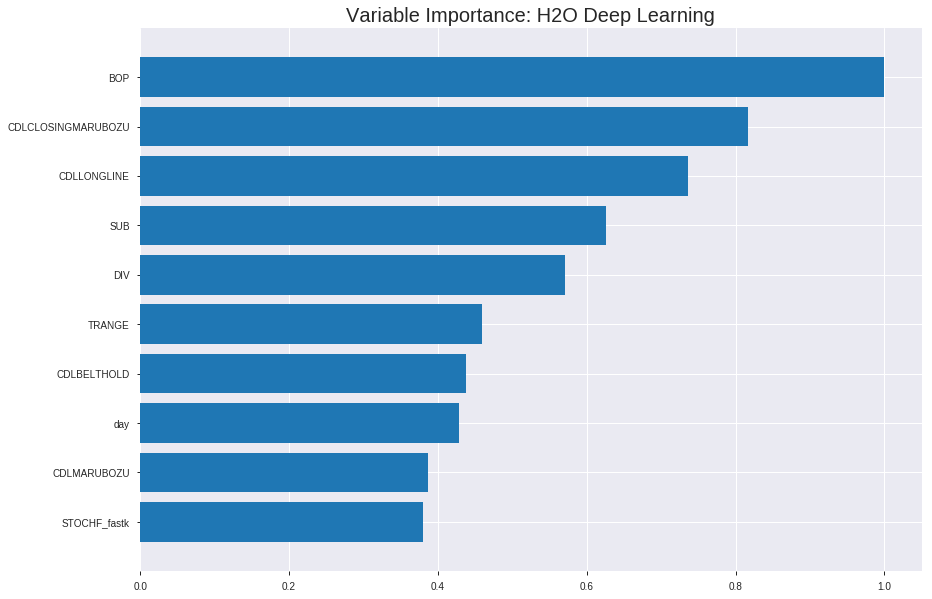

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_131123_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20113569559657732
RMSE: 0.4484815443210315
LogLoss: 0.5862364542499239
Mean Per-Class Error: 0.30642744325079296
AUC: 0.7549902752940255
pr_auc: 0.7581582530832806
Gini: 0.509980550588051
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5257304252060946: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      423  407   0.4904   (407.0/830.0)
1      119  804   0.1289   (119.0/923.0)
Total  542  1211  0.3001   (526.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52573      0.753515  213
max f2                       0.229953     0.859419  327
max f0point5                 0.566041     0.703747  186
max accuracy                 0.555136     0.699943  194
max precision                0.978        1         0
max recall                   0.0497091    1         388
max specificity              0.978        1         0
max absolute_mcc             0.52573      0.411305  213
max min_per_class_accuracy   0.593594     0.671084  164
max mean_per_class_accuracy  0.555136     0.693573  194

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 55.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.894959           1.79373   1.79373            0.944444         0.921206  0.944444                    0.921206            0.0184182       0.0184182                  79.3728   79.3728
    2        0.0205362                   0.866502           1.89924   1.84648            1                0.878892  0.972222                    0.900049            0.0195016       0.0379198                  89.9242   84.6485
    3        0.0302339                   0.853991           1.6758    1.79174            0.882353         0.859732  0.943396                    0.887117            0.0162514       0.0541712                  67.5801   79.1737
    4        0.040502                    0.824782           1.68821   1.76549            0.888889         0.838823  0.929577                    0.874874            0.0173348       0.071506                   68.8215   76.5492
    5        0.0501997                   0.806505           1.6758    1.74817            0.882353         0.816312  0.920455                    0.863561            0.0162514       0.0877573                  67.5801   74.8166
    6        0.100399                    0.757528           1.55392   1.65105            0.818182         0.778267  0.869318                    0.820914            0.0780065       0.165764                   55.3925   65.1045
    7        0.150029                    0.722812           1.37531   1.55983            0.724138         0.74011   0.821293                    0.794184            0.0682557       0.23402                    37.5313   55.9833
    8        0.200228                    0.698283           1.40285   1.52048            0.738636         0.710876  0.80057                     0.773298            0.0704225       0.304442                   40.2849   52.0475
    9        0.300057                    0.659372           1.30234   1.4479             0.685714         0.676845  0.762357                    0.741208            0.130011        0.434453                   30.2337   44.7901
    10       0.399886                    0.626068           1.24807   1.39802            0.657143         0.643581  0.736091                    0.716836            0.124594        0.559047                   24.8073   39.8015
    11       0.500285                    0.596715           1.02516   1.32319            0.539773         0.611652  0.696693                    0.695727            0.102925        0.661972                   2.51588   32.3189
    12       0.600114                    0.566604           1.19381   1.30167            0.628571         0.58352   0.685361                    0.677062            0.119177        0.781148                   19.3809   30.1667
    13       0.699943                    0.518224           0.9659    1.25378            0.508571         0.546242  0.660147                    0.658404            0.0964247       0.877573                   -3.41     25.3778
    14       0.799772                    0.408107           0.607757  1.17314            0.32             0.473326  0.617689                    0.635302            0.0606717       0.938245                   -39.2243  17.3141
    15       0.899601                    0.229734           0.42326   1.08993            0.222857         0.319812  0.573874                    0.600292            0.0422535       0.980498                   -57.674   8.99262
    16       1                           0.00700519         0.194241  1                  0.102273         0.126184  0.526526                    0.552692         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21862752927434412
RMSE: 0.4675762283033047
LogLoss: 0.6243518886300237
Mean Per-Class Error: 0.3118144132653061
AUC: 0.7409199617346939
pr_auc: 0.7512934007312362
Gini: 0.48183992346938775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5430564867211561: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  120  0.4898   (120.0/245.0)
1      49   207  0.1914   (49.0/256.0)
Total  174  327  0.3373   (169.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.543056     0.71012   238
max f2                       0.220492     0.849434  375
max f0point5                 0.591846     0.71281   138
max accuracy                 0.579569     0.686627  163
max precision                0.863379     1         0
max recall                   0.129481     1         388
max specificity              0.863379     1         0
max absolute_mcc             0.591846     0.392505  138
max min_per_class_accuracy   0.566826     0.677551  188
max mean_per_class_accuracy  0.579569     0.688186  163

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 53.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.808967           1.95703   1.95703            1                0.829098  1                           0.829098            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.78312            1.95703   1.95703            1                0.788521  1                           0.810654            0.0195312       0.0429688                  95.7031   95.7031
    3        0.0319361                   0.746153           1.56563   1.83472            0.8              0.761484  0.9375                      0.795289            0.015625        0.0585938                  56.5625   83.4717
    4        0.0419162                   0.715537           1.56563   1.77065            0.8              0.723192  0.904762                    0.778123            0.015625        0.0742188                  56.5625   77.0647
    5        0.0518962                   0.700123           1.56563   1.73122            0.8              0.705772  0.884615                    0.764209            0.015625        0.0898438                  56.5625   73.122
    6        0.101796                    0.650058           1.72219   1.72679            0.88             0.670338  0.882353                    0.718194            0.0859375       0.175781                   72.2188   72.6792
    7        0.151697                    0.629258           1.40906   1.62228            0.72             0.636178  0.828947                    0.691215            0.0703125       0.246094                   40.9063   62.2276
    8        0.201597                    0.619047           1.56563   1.60825            0.8              0.623384  0.821782                    0.674425            0.078125        0.324219                   56.5625   60.8253
    9        0.301397                    0.597427           1.40906   1.5423             0.72             0.605681  0.788079                    0.651662            0.140625        0.464844                   40.9063   54.2296
    10       0.401198                    0.586812           1.13508   1.441              0.58             0.592216  0.736318                    0.636874            0.113281        0.578125                   13.5078   44.0998
    11       0.500998                    0.567957           0.939375  1.34107            0.48             0.577013  0.685259                    0.62495             0.09375         0.671875                   -6.0625   34.1073
    12       0.600798                    0.551208           0.900234  1.26784            0.46             0.558804  0.647841                    0.613962            0.0898438       0.761719                   -9.97656  26.7844
    13       0.700599                    0.531528           0.665391  1.18202            0.34             0.541985  0.603989                    0.603709            0.0664062       0.828125                   -33.4609  18.2025
    14       0.800399                    0.480679           0.782813  1.13225            0.4              0.510088  0.578554                    0.592035            0.078125        0.90625                    -21.7187  13.2248
    15       0.9002                      0.349028           0.587109  1.07181            0.3              0.421794  0.547672                    0.573162            0.0585938       0.964844                   -41.2891  7.18109
    16       1                           0.00374446         0.352266  1                  0.18             0.203623  0.510978                    0.536282          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:40:17  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:40:19  11 min  6.842 sec  199 obs/sec       0.224758  1             394        0.63938          3.03883             -0.639844      0.53734         0.39587            1.05513          0.467199                         0.597589           1.06117               -0.429141        0.564931          0.571937             1.63086            0.469062
    2019-08-27 13:41:14  12 min  2.067 sec  185 obs/sec       5.45864   23            9569       0.496612         0.686384            0.0107198      0.577923        0.564858           0.949621         0.438677                         0.501765           0.696718              -0.00755712      0.507087          0.520144             0.652344           0.473054
    2019-08-27 13:42:11  12 min 58.790 sec  201 obs/sec       11.8437   50            20762      0.492898         0.678836            0.0254614      0.642072        0.647125           1.68821          0.408443                         0.497421           0.687998              0.00981393       0.625327          0.621008             1.30469            0.443114
    2019-08-27 13:43:07  13 min 54.261 sec  208 obs/sec       18.162    77            31838      0.478339         0.64873             0.0821855      0.70459         0.709209           1.79373          0.371363                         0.495595           0.684116              0.0170705        0.676515          0.690058             1.95703            0.437126
    2019-08-27 13:44:04  14 min 51.532 sec  213 obs/sec       24.8551   106           43571      0.467971         0.627348            0.121539       0.713088        0.717876           1.79373          0.351398                         0.482029           0.6561                0.0701435        0.664007          0.669601             1.63086            0.409182
    2019-08-27 13:45:01  15 min 48.666 sec  216 obs/sec       31.6315   135           55450      0.458116         0.606676            0.158149       0.745306        0.744549           1.79373          0.313177                         0.478609           0.648352              0.0832917        0.71521           0.719757             1.95703            0.345309
    2019-08-27 13:45:58  16 min 45.537 sec  217 obs/sec       38.1962   163           66958      0.458974         0.608327            0.154993       0.754074        0.757617           1.89924          0.332573                         0.480498           0.652008              0.0760414        0.718431          0.729596             1.95703            0.371257
    2019-08-27 13:46:51  17 min 39.046 sec  220 obs/sec       44.7165   191           78388      0.448482         0.586236            0.193186       0.75499         0.758158           1.79373          0.300057                         0.467576           0.624352              0.125068         0.74092           0.751293             1.95703            0.337325
    2019-08-

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.006766549043694183
CDLCLOSINGMARUBOZU       0.8172288537025452     0.8172288537025452   0.0055298191185002505
CDLLONGLINE              0.7365763783454895     0.7365763783454895   0.004984080188501397
SUB                      0.6257965564727783     0.6257965564727783   0.0042344830907479905
DIV                      0.5710915327072144     0.5710915327072144   0.0038643188645018467
---                      ---                    ---                  ---
BBANDS_upperband_30_2_2  0.10990668088197708    0.10990668088197708  0.0007436889464175438
LINEARREG_20             0.10955122113227844    0.10955122113227844  0.0007412837105881487
KAMA_24                  0.10621578246355057    0.10621578246355057  0.0007187143012539675
CDLBREAKAWAY             0.1001986637711525     0.1001986637711525   0.0006779991725201269
CDL3LINESTRIKE           0.09831135720014572    0.09831135720014572  0.0006652286200469232


See the whole table with table.as_data_frame()


('accuracy', 0.7051792828685259)

('F1', 0.7337662337662337)

('auc', 0.6981649037848859)

('logloss', 0.6527619968570281)

('mean_per_class_error', 0.2968331846565566)

('rmse', 0.4794594413210197)

('mse', 0.22988135587186434)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


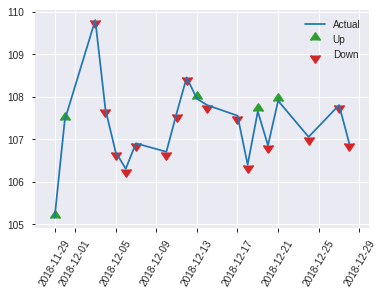


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22988135587186434
RMSE: 0.4794594413210197
LogLoss: 0.6527619968570281
Mean Per-Class Error: 0.2968331846565566
AUC: 0.6981649037848859
pr_auc: 0.6565978295169637
Gini: 0.3963298075697719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5323914404197517: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   62   0.5254   (62.0/118.0)
1      20   113  0.1504   (20.0/133.0)
Total  76   175  0.3267   (82.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.532391     0.733766  174
max f2                       0.415589     0.853977  234
max f0point5                 0.57059      0.71953   136
max accuracy                 0.57059      0.705179  136
max precision                0.745306     0.75      7
max recall                   0.134755     1         249
max specificity              0.801683     0.991525  0
max absolute_mcc             0.57059      0.407321  136
max min_per_class_accuracy   0.576367     0.686441  128
max mean_per_class_accuracy  0.57059      0.703167  136

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 56.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.777893           1.25815   1.25815            0.666667         0.787652  0.666667                    0.787652            0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.763417           1.25815   1.25815            0.666667         0.771189  0.666667                    0.77942             0.0150376       0.0300752                  25.8145   25.8145
    3        0.0318725                   0.744786           1.88722   1.41541            1                0.746822  0.75                        0.771271            0.0150376       0.0451128                  88.7218   41.5414
    4        0.0438247                   0.728319           1.25815   1.37252            0.666667         0.738462  0.727273                    0.762323            0.0150376       0.0601504                  25.8145   37.2522
    5        0.0517928                   0.715177           0.943609  1.30654            0.5              0.720589  0.692308                    0.755902            0.0075188       0.0676692                  -5.6391   30.6536
    6        0.103586                    0.671647           1.01619   1.16136            0.538462         0.6911    0.615385                    0.723501            0.0526316       0.120301                   1.61943   16.1365
    7        0.151394                    0.639494           1.41541   1.24159            0.75             0.652444  0.657895                    0.701062            0.0676692       0.18797                    41.5414   24.1591
    8        0.203187                    0.629416           1.01619   1.18414            0.538462         0.633185  0.627451                    0.68376             0.0526316       0.240602                   1.61943   18.4137
    9        0.302789                    0.599379           1.50977   1.29125            0.8              0.609656  0.684211                    0.659384            0.150376        0.390977                   50.9774   29.1254
    10       0.40239                     0.588579           1.3588    1.30797            0.72             0.593884  0.693069                    0.643171            0.135338        0.526316                   35.8797   30.7973
    11       0.501992                    0.577744           1.43429   1.33303            0.76             0.583865  0.706349                    0.631404            0.142857        0.669173                   43.4286   33.3035
    12       0.601594                    0.555547           1.13233   1.29981            0.6              0.567914  0.688742                    0.620892            0.112782        0.781955                   13.2331   29.9806
    13       0.701195                    0.532359           0.679398  1.21168            0.36             0.544349  0.642045                    0.61002             0.0676692       0.849624                   -32.0602  21.168
    14       0.800797                    0.517824           0.60391   1.13609            0.32             0.52487   0.60199                     0.599429            0.0601504       0.909774                   -39.609   13.6086
    15       0.900398                    0.451965           0.528421  1.06887            0.28             0.492678  0.566372                    0.58762             0.0526316       0.962406                   -47.1579  6.88669
    16       1                           0.0925181          0.377444  1                  0.2              0.3381    0.52988                     0.562767          

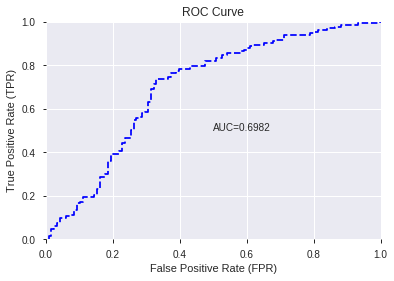

This function is available for GLM models only


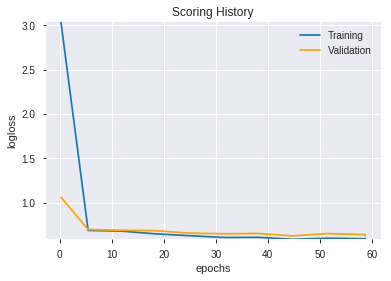

--2019-08-27 13:49:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  75.1MB/s    in 4.7s    

2019-08-27 13:49:09 (74.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_131123_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_131123_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_134920_model_8  0.693832  0.636248              0.314802  0.470105  0.220998
1  DeepLearning_grid_1_AutoML_20190827_134920_model_9  0.688543  0.644473              0.413343  0.474297  0.224958
2  DeepLearning_grid_1_AutoML_20190827_134920_model_5  0.688225  0.679783              0.341181  0.479717  0.230128
3  DeepLearning_grid_1_AutoML_20190827_134920_model_6  0.675481  0.647873              0.403434  0.476060  0.226633
4               DeepLearning_1_AutoML_20190827_134920  0.671339  0.682394              0.368580  0.483174  0.233457
5  DeepLearning_grid_1_AutoML_20190827_134920_model_3  0.666560  0.780902              0.409520  0.500257  0.250257
6  DeepLearning_grid_1_AutoML_20190827_134920_model_1  0.663757  0.960058              0.369472  0.521692  0.272162
7  DeepLearning_grid_1_AutoML_20190827_134920_model_7  0.648273  0.841661              0.402957  0.533642  0.284774
8  DeepLearning_grid_1_AutoML_20190827_134920_model_2  0.638397  0.814773              0.369950  0.517794  0.268111
9  DeepLearning_grid_1_AutoML_20190827_134920_model_4  0.582898  0.917232              0.434529  0.548291  0.300623

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.031834
1   CDLCLOSINGMARUBOZU             0.830718           0.830718    0.026445
2                  SUB             0.768848           0.768848    0.024476
3           MINUS_DI_8             0.715349           0.715349    0.022773
4         CDLSHORTLINE             0.706789           0.706789    0.022500
5               TRANGE             0.704800           0.704800    0.022437
6                  day             0.695216           0.695216    0.022132
7            CORREL_12             0.681678           0.681678    0.021701
8         HT_TRENDMODE             0.680418           0.680418    0.021661
9         aroondown_14             0.674934           0.674934    0.021486
10       days_in_month             0.667472           0.667472    0.021248
11                 SIN             0.667336           0.667336    0.021244
12           aroonup_8             0.657608           0.657608    0.020934
13       CDLHANGINGMAN             0.655908           0.655908    0.020880
14             quarter             0.647550           0.647550    0.020614
15        weekday_name             0.645003           0.645003    0.020533
16              ULTOSC             0.642987           0.642987    0.020469
17        STOCHF_fastk             0.629155           0.629155    0.020029
18         CDLLONGLINE             0.629001           0.629001    0.020024
19                 DIV             0.617059           0.617059    0.019644
20      STOCHRSI_fastk             0.616852           0.616852    0.019637
21              VAR_20             0.615870           0.615870    0.019606
22          AROONOSC_8             0.612394           0.612394    0.019495
23              ROCR_8             0.611841           0.611841    0.019477
24         aroondown_8             0.611035           0.611035    0.019452
25         CDLMARUBOZU             0.609227           0.609227    0.019394
26    CDLDRAGONFLYDOJI             0.605330           0.605330    0.019270
27              SAREXT             0.605017           0.605017    0.019260
28           CDLTAKURI             0.599695           0.599695    0.019091
29        CDLTHRUSTING             0.597244           0.597244    0.019013
30               ROC_8             0.594549           0.594549    0.018927
31         STOCH_slowd             0.592309           0.592309    0.018856
32            WILLR_12             0.588848           0.588848    0.018745
33             WILLR_8             0.587554           0.587554    0.018704
34           dayofweek             0.587179           0.587179    0.018692
35               MOM_8             0.585029           0.585029    0.018624
36           CDLHAMMER             0.581333           0.581333    0.018506
37               ADOSC             0.580873           0.580873    0.018492
38            CORREL_8             0.578935           0.578935    0.018430
39             weekday             0.577173           0.577173    0.018374
40             CDLDOJI             0.576883           0.576883    0.018365
41            WILLR_14             0.574521           0.574521    0.018289
42            WILLR_20             0.567879           0.567879    0.018078
43         CDLBELTHOLD             0.566705           0.566705    0.018041
44           CORREL_14             0.565567           0.565567    0.018004
45        CDLENGULFING             0.562631           0.562631    0.017911
46      CDLRICKSHAWMAN             0.549589           0.549589    0.017496
47      CDLMORNINGSTAR             0.533945           0.533945    0.016998
48        is_month_end             0.533928           0.533928    0.016997
49   CDLLONGLEGGEDDOJI             0.525042           0.525042    0.016714

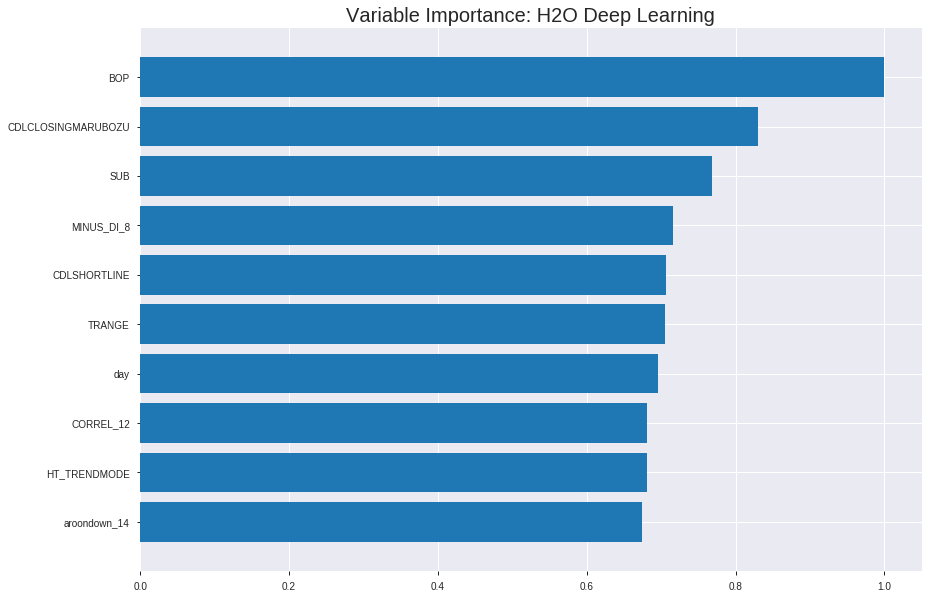

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_134920_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20605019258232707
RMSE: 0.4539275190846299
LogLoss: 0.59806090818841
Mean Per-Class Error: 0.31406427443250795
AUC: 0.7500450338733047
pr_auc: 0.7545010922662463
Gini: 0.5000900677466094
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4722117078569335: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      384  446   0.5373   (446.0/830.0)
1      125  798   0.1354   (125.0/923.0)
Total  509  1244  0.3257   (571.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472212     0.736502  222
max f2                       0.196069     0.859741  345
max f0point5                 0.581299     0.707423  146
max accuracy                 0.543816     0.687963  175
max precision                0.765361     0.962963  12
max recall                   0.0789519    1         387
max specificity              0.835053     0.998795  0
max absolute_mcc             0.543816     0.372982  175
max min_per_class_accuracy   0.568905     0.679307  156
max mean_per_class_accuracy  0.581299     0.685936  146

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.773025           1.79373   1.79373            0.944444         0.789948  0.944444                    0.789948            0.0184182       0.0184182                  79.3728   79.3728
    2        0.0205362                   0.759217           1.79373   1.79373            0.944444         0.765893  0.944444                    0.777921            0.0184182       0.0368364                  79.3728   79.3728
    3        0.0302339                   0.747339           1.45236   1.68423            0.764706         0.752272  0.886792                    0.769694            0.0140845       0.0509209                  45.2361   68.4233
    4        0.040502                    0.738755           1.79373   1.71199            0.944444         0.742935  0.901408                    0.76291             0.0184182       0.0693391                  79.3728   71.1992
    5        0.0501997                   0.729918           1.56408   1.68342            0.823529         0.734426  0.886364                    0.757407            0.0151679       0.084507                   56.4081   68.3419
    6        0.100399                    0.70079            1.61867   1.65105            0.852273         0.714864  0.869318                    0.736136            0.0812568       0.165764                   61.8672   65.1045
    7        0.150029                    0.67563            1.52813   1.61038            0.804598         0.687605  0.847909                    0.720082            0.0758397       0.241603                   52.8125   61.0384
    8        0.200228                    0.653082           1.38127   1.55294            0.727273         0.664729  0.817664                    0.706204            0.0693391       0.310943                   38.1267   55.2941
    9        0.300057                    0.619898           1.28063   1.46234            0.674286         0.636022  0.769962                    0.682855            0.127844        0.438787                   28.0631   46.2344
    10       0.399886                    0.596048           1.23722   1.40614            0.651429         0.607407  0.740371                    0.66402             0.12351         0.562297                   23.722    40.6143
    11       0.500285                    0.570215           1.1007    1.34484            0.579545         0.583722  0.708096                    0.647905            0.110509        0.672806                   10.0697   34.4845
    12       0.600114                    0.53947            0.976753  1.28361            0.514286         0.556416  0.675856                    0.632686            0.0975081       0.770314                   -2.32472  28.3613
    13       0.699943                    0.478217           0.846519  1.22127            0.445714         0.512613  0.643032                    0.615561            0.084507        0.854821                   -15.3481  22.1273
    14       0.799772                    0.393496           0.640316  1.14876            0.337143         0.43772   0.60485                     0.593362            0.063922        0.918743                   -35.9684  14.8757
    15       0.899601                    0.256635           0.564346  1.0839             0.297143         0.333453  0.570704                    0.56452             0.056338        0.975081                   -43.5654  8.39045
    16       1                           0.0398564          0.248196  1                  0.130682         0.159171  0.526526                    0.523823         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21487077572270546
RMSE: 0.46354155770837363
LogLoss: 0.6175524097920247
Mean Per-Class Error: 0.3269132653061224
AUC: 0.7278698979591837
pr_auc: 0.7334185850783529
Gini: 0.45573979591836733
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4582027420350527: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  139  0.5673   (139.0/245.0)
1      37   219  0.1445   (37.0/256.0)
Total  143  358  0.3513   (176.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458203     0.713355  269
max f2                       0.124732     0.848244  383
max f0point5                 0.59394      0.689655  150
max accuracy                 0.59394      0.670659  150
max precision                0.812168     1         0
max recall                   0.124732     1         383
max specificity              0.812168     1         0
max absolute_mcc             0.59394      0.354264  150
max min_per_class_accuracy   0.566557     0.653061  188
max mean_per_class_accuracy  0.59394      0.673087  150

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.77369            1.63086   1.63086            0.833333         0.785355  0.833333                    0.785355            0.0195312       0.0195312                  63.0859   63.0859
    2        0.0219561                   0.749487           1.56563   1.60121            0.8              0.759795  0.818182                    0.773737            0.015625        0.0351562                  56.5625   60.1207
    3        0.0319361                   0.744201           1.95703   1.7124             1                0.746156  0.875                       0.765118            0.0195312       0.0546875                  95.7031   71.2402
    4        0.0419162                   0.735688           1.95703   1.77065            1                0.739266  0.904762                    0.758963            0.0195312       0.0742188                  95.7031   77.0647
    5        0.0518962                   0.731812           1.95703   1.80649            1                0.732908  0.923077                    0.753952            0.0195312       0.09375                    95.7031   80.649
    6        0.101796                    0.696155           1.72219   1.76517            0.88             0.712552  0.901961                    0.733658            0.0859375       0.179688                   72.2188   76.5165
    7        0.151697                    0.668273           1.56563   1.69953            0.8              0.68284   0.868421                    0.716941            0.078125        0.257812                   56.5625   69.9527
    8        0.201597                    0.644748           1.2525    1.58888            0.64             0.657594  0.811881                    0.702251            0.0625          0.320312                   25.25     58.8877
    9        0.301397                    0.614037           1.29164   1.49045            0.66             0.627991  0.761589                    0.677662            0.128906        0.449219                   29.1641   49.0454
    10       0.401198                    0.591336           1.21336   1.42153            0.62             0.602795  0.726368                    0.659038            0.121094        0.570312                   21.3359   42.1525
    11       0.500998                    0.56792            0.821953  1.30209            0.42             0.57782   0.665339                    0.642859            0.0820312       0.652344                   -17.8047  30.2089
    12       0.600798                    0.532495           0.978516  1.24834            0.5              0.548748  0.637874                    0.627226            0.0976562       0.75                       -2.14844  24.8339
    13       0.700599                    0.471697           0.821953  1.1876             0.42             0.504302  0.606838                    0.609716            0.0820312       0.832031                   -17.8047  18.76
    14       0.800399                    0.375635           0.665391  1.12249            0.34             0.427965  0.573566                    0.587053            0.0664062       0.898438                   -33.4609  12.2487
    15       0.9002                      0.270439           0.62625   1.06747            0.32             0.320673  0.545455                    0.557521            0.0625          0.960938                   -37.375   6.74716
    16       1                           0.0270158          0.391406  1                  0.2              0.164085  0.510978                    0.518256            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:54:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:54:49  1 min 21.696 sec  548 obs/sec       0.512265  1             898        0.513452         0.735734            -0.0575072     0.702872        0.705343           1.79373          0.367941                         0.520871           0.752165              -0.08575         0.700199          0.704529             1.30469            0.387226
    2019-08-27 13:55:00  1 min 33.080 sec  910 obs/sec       6.19624   12            10862      0.453928         0.598061            0.173473       0.750045        0.754501           1.79373          0.325727                         0.463542           0.617552              0.140102         0.72787           0.733419             1.63086            0.351297
    2019-08-27 13:55:12  1 min 44.252 sec  1033 obs/sec      12.9658   25            22729      0.448011         0.584248            0.19488        0.762754        0.771355           1.79373          0.322305                         0.465669           0.624222              0.13219          0.718814          0.71991              1.63086            0.351297
    2019-08-27 13:55:23  1 min 55.919 sec  1121 obs/sec      20.8585   40            36565      0.447913         0.581791            0.195229       0.776979        0.78306            1.79373          0.323446                         0.470341           0.632561              0.114691         0.723549          0.727542             1.63086            0.371257
    2019-08-27 13:55:35  2 min  7.257 sec  1173 obs/sec      28.6691   55            50257      0.426838         0.53673             0.269179       0.801368        0.805286           1.68821          0.295493                         0.461749           0.626579              0.146741         0.732302          0.729132             1.30469            0.341317
    2019-08-27 13:55:46  2 min 18.878 sec  1214 obs/sec      36.9903   71            64844      0.418045         0.518673            0.298982       0.815372        0.820082           1.79373          0.285796                         0.465896           0.633725              0.131344         0.723988          0.720003             1.63086            0.325349
    2019-08-27 13:55:58  2 min 30.131 sec  1209 obs/sec      43.8511   84            76871      0.412864         0.507386            0.316249       0.837015        0.841135           1.89924          0.25328                          0.470633           0.6638                0.11359          0.718638          0.714968             1.63086            0.343313
    2019-08-27 13:55:59  2 min 31.252 sec  1209 obs/sec      43.8511   84            76871      0.453928         0.598061            0.173473       0.750045        0.754501           1.79373          0.325727                         0.463542           0.617552              0.140102         0.72787           0.733419             1.63086            0.351297

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03183414788324009
CDLCLOSINGMARUBOZU  0.8307181000709534     0.8307181000709534   0.026445202846942975
SUB                 0.7688481211662292     0.7688481211662292   0.02447562478895704
MINUS_DI_8          0.7153485417366028     0.7153485417366028   0.022772511265703163
CDLSHORTLINE        0.7067893743515015     0.7067893743515015   0.02250003746540844
---                 ---                    ---                  ---
CDLENGULFING        0.5626310110092163     0.5626310110092163   0.017910878808164277
CDLRICKSHAWMAN      0.5495890974998474     0.5495890974998474   0.0174957006048266
CDLMORNINGSTAR      0.5339450836181641     0.5339450836181641   0.016997686753429633
is_month_end        0.5339283347129822     0.5339283347129822   0.01699715356630519
CDLLONGLEGGEDDOJI   0.525041937828064      0.525041937828064    0.01671426269372154


See the whole table with table.as_data_frame()


('accuracy', 0.6932270916334662)

('F1', 0.7389830508474576)

('auc', 0.6938320377214222)

('logloss', 0.6362480817297337)

('mean_per_class_error', 0.3148018350962152)

('rmse', 0.47010461470771775)

('mse', 0.22099834876949173)

deeplearning prediction progress: |███████████████████████████████████████| 100%


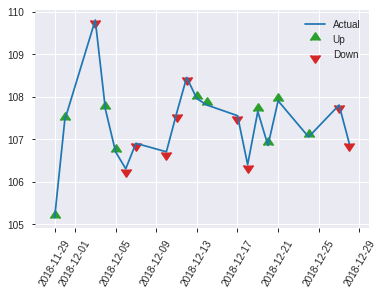


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22099834876949173
RMSE: 0.47010461470771775
LogLoss: 0.6362480817297337
Mean Per-Class Error: 0.3148018350962152
AUC: 0.6938320377214222
pr_auc: 0.6543589917557369
Gini: 0.3876640754428444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49846284802295676: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   53   0.4492   (53.0/118.0)
1      24   109  0.1805   (24.0/133.0)
Total  89   162  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498463     0.738983  161
max f2                       0.244812     0.8519    230
max f0point5                 0.498463     0.697823  161
max accuracy                 0.498463     0.693227  161
max precision                0.607626     0.72973   73
max recall                   0.0524832    1         248
max specificity              0.791926     0.991525  0
max absolute_mcc             0.498463     0.386439  161
max min_per_class_accuracy   0.55644      0.635593  127
max mean_per_class_accuracy  0.498463     0.685198  161

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.753744           0.629073  0.629073           0.333333         0.767777  0.333333                    0.767777            0.0075188       0.0075188                  -37.0927  -37.0927
    2        0.0239044                   0.749204           1.25815   0.943609           0.666667         0.751157  0.5                         0.759467            0.0150376       0.0225564                  25.8145   -5.6391
    3        0.0318725                   0.74187            1.88722   1.17951            1                0.747063  0.625                       0.756366            0.0150376       0.037594                   88.7218   17.9511
    4        0.0438247                   0.734327           0.629073  1.02939            0.333333         0.736222  0.545455                    0.750872            0.0075188       0.0451128                  -37.0927  2.93917
    5        0.0517928                   0.727542           0.943609  1.01619            0.5              0.730424  0.538462                    0.747726            0.0075188       0.0526316                  -5.6391   1.61943
    6        0.103586                    0.690086           1.45171   1.23395            0.769231         0.71244   0.653846                    0.730083            0.075188        0.12782                    45.1706   23.395
    7        0.151394                    0.664091           1.25815   1.24159            0.666667         0.676548  0.657895                    0.713177            0.0601504       0.18797                    25.8145   24.1591
    8        0.203187                    0.637817           1.59688   1.33215            0.846154         0.650084  0.705882                    0.697095            0.0827068       0.270677                   59.6877   33.2154
    9        0.302789                    0.606918           1.3588    1.34092            0.72             0.62054   0.710526                    0.671912            0.135338        0.406015                   35.8797   34.0918
    10       0.40239                     0.582877           1.20782   1.30797            0.64             0.593923  0.693069                    0.652608            0.120301        0.526316                   20.782    30.7973
    11       0.501992                    0.55662            0.981353  1.24317            0.52             0.571416  0.65873                     0.636498            0.0977444       0.62406                    -1.86466  24.3167
    12       0.601594                    0.527297           1.20782   1.23732            0.64             0.541365  0.655629                    0.620748            0.120301        0.744361                   20.782    23.7315
    13       0.701195                    0.452343           0.905865  1.19023            0.48             0.49149   0.630682                    0.602387            0.0902256       0.834586                   -9.41353  19.0234
    14       0.800797                    0.366176           0.905865  1.15486            0.48             0.4077    0.61194                     0.578172            0.0902256       0.924812                   -9.41353  15.4865
    15       0.900398                    0.284384           0.301955  1.06052            0.16             0.326176  0.561947                    0.550297            0.0300752       0.954887                   -69.8045  6.05163
    16       1                           0.0454308          0.452932  1                  0.24             0.170473  0.52988                     0.512466         

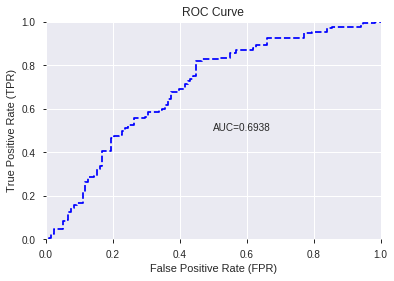

This function is available for GLM models only


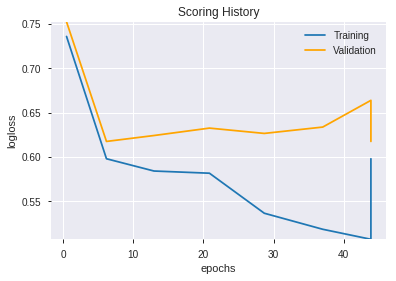

--2019-08-27 13:57:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_134920_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_134920_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'MINUS_DI_8',
 'CDLSHORTLINE',
 'TRANGE',
 'day',
 'CORREL_12',
 'HT_TRENDMODE',
 'aroondown_14',
 'days_in_month',
 'SIN',
 'aroonup_8',
 'CDLHANGINGMAN',
 'quarter',
 'weekday_name',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'DIV',
 'STOCHRSI_fastk',
 'VAR_20',
 'AROONOSC_8',
 'ROCR_8',
 'aroondown_8',
 'CDLMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'SAREXT',
 'CDLTAKURI',
 'CDLTHRUSTING',
 'ROC_8',
 'STOCH_slowd',
 'WILLR_12',
 'WILLR_8',
 'dayofweek',
 'MOM_8',
 'CDLHAMMER',
 'ADOSC',
 'CORREL_8',
 'weekday',
 'CDLDOJI',
 'WILLR_14',
 'WILLR_20',
 'CDLBELTHOLD',
 'CORREL_14',
 'CDLENGULFING',
 'CDLRICKSHAWMAN',
 'CDLMORNINGSTAR',
 'is_month_end',
 'CDLLONGLEGGEDDOJI']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_135729_model_1  0.690646  0.643532               0.33414  0.472655  0.223402

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.480068           1.000000    0.101276
1   CDLCLOSINGMARUBOZU             0.271093           0.564697    0.057190
2           MINUS_DI_8             0.261476           0.544665    0.055161
3                  SUB             0.258436           0.538332    0.054520
4            CORREL_12             0.205572           0.428215    0.043368
5             WILLR_14             0.170337           0.354819    0.035935
6              WILLR_8             0.150837           0.314200    0.031821
7          STOCH_slowd             0.140838           0.293371    0.029711
8             WILLR_20             0.139706           0.291012    0.029473
9        CDLHANGINGMAN             0.132075           0.275117    0.027863
10                 day             0.128168           0.266980    0.027039
11      CDLRICKSHAWMAN             0.113577           0.236586    0.023960
12              ULTOSC             0.112659           0.234673    0.023767
13           CDLHAMMER             0.108535           0.226083    0.022897
14       days_in_month             0.108501           0.226012    0.022890
15        aroondown_14             0.104706           0.218107    0.022089
16      STOCHRSI_fastk             0.103458           0.215508    0.021826
17           aroonup_8             0.101513           0.211455    0.021415
18               MOM_8             0.099422           0.207101    0.020974
19              VAR_20             0.098721           0.205640    0.020826
20           CORREL_14             0.095730           0.199409    0.020195
21        weekday_name             0.094098           0.196009    0.019851
22              ROCR_8             0.093725           0.195234    0.019772
23               ROC_8             0.093626           0.195026    0.019751
24         CDLLONGLINE             0.093049           0.193825    0.019630
25          AROONOSC_8             0.079370           0.165330    0.016744
26                 DIV             0.075382           0.157023    0.015903
27        CDLTHRUSTING             0.066954           0.139467    0.014125
28              SAREXT             0.066343           0.138195    0.013996
29         CDLMARUBOZU             0.059916           0.124807    0.012640
30        CDLSHORTLINE             0.056411           0.117507    0.011901
31              TRANGE             0.048916           0.101894    0.010319
32   CDLLONGLEGGEDDOJI             0.048909           0.101879    0.010318
33         CDLBELTHOLD             0.041576           0.086605    0.008771
34           CDLTAKURI             0.041310           0.086050    0.008715
35    CDLDRAGONFLYDOJI             0.041229           0.085883    0.008698
36         aroondown_8             0.037711           0.078553    0.007956
37               ADOSC             0.036410           0.075843    0.007681
38            WILLR_12             0.031500           0.065616    0.006645
39        CDLENGULFING             0.027561           0.057410    0.005814
40        is_month_end             0.025777           0.053694    0.005438
41        STOCHF_fastk             0.025637           0.053402    0.005408
42      CDLMORNINGSTAR             0.025285           0.052670    0.005334
43             quarter             0.023735           0.049441    0.005007
44           dayofweek             0.023474           0.048897    0.004952
45             weekday             0.023175           0.048275    0.004889
46            CORREL_8             0.022550           0.046972    0.004757
47                 SIN             0.022170           0.046181    0.004677
48        HT_TRENDMODE             0.020848           0.043427    0.004398
49             CDLDOJI             0.008120           0.016915    0.001713

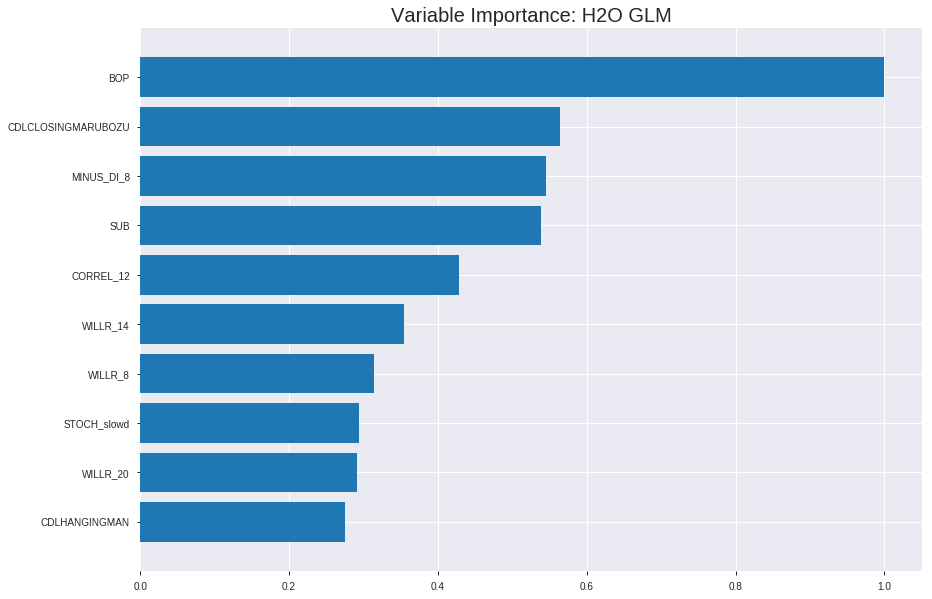

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_135729_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20197540514581305
RMSE: 0.44941673883580824
LogLoss: 0.589161473125286
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2425.2378703291097
Residual deviance: 2065.600124777253
AIC: 2167.600124777253
AUC: 0.7513510161991411
pr_auc: 0.7530389178569667
Gini: 0.5027020323982823
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37482234718759155: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      349  481   0.5795   (481.0/830.0)
1      94   829   0.1018   (94.0/923.0)
Total  443  1310  0.328    (575.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374822     0.742499  276
max f2                       0.119777     0.853997  379
max f0point5                 0.553186     0.70956   186
max accuracy                 0.496114     0.691386  216
max precision                0.964657     1         0
max recall                   0.119777     1         379
max specificity              0.964657     1         0
max absolute_mcc             0.553186     0.380614  186
max min_per_class_accuracy   0.54516      0.684337  191
max mean_per_class_accuracy  0.553186     0.690559  186

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.886515           1.5827    1.5827             0.833333         0.909065  0.833333                    0.909065            0.0162514       0.0162514                  58.2701   58.2701
    2        0.0205362                   0.868331           1.68821   1.63546            0.888889         0.875923  0.861111                    0.892494            0.0173348       0.0335861                  68.8215   63.5458
    3        0.0302339                   0.853573           1.78752   1.68423            0.941176         0.861664  0.886792                    0.882605            0.0173348       0.0509209                  78.7522   68.4233
    4        0.040502                    0.842255           1.68821   1.68524            0.888889         0.847505  0.887324                    0.873706            0.0173348       0.0682557                  68.8215   68.5243
    5        0.0501997                   0.829959           1.6758    1.68342            0.882353         0.83719   0.886364                    0.866652            0.0162514       0.084507                   67.5801   68.3419
    6        0.100399                    0.787057           1.61867   1.65105            0.852273         0.808968  0.869318                    0.83781             0.0812568       0.165764                   61.8672   65.1045
    7        0.150029                    0.747793           1.48446   1.59594            0.781609         0.766974  0.840304                    0.814378            0.0736728       0.239437                   48.4465   59.5941
    8        0.200228                    0.716326           1.31652   1.52589            0.693182         0.731722  0.803419                    0.793655            0.0660888       0.305525                   31.652    52.5886
    9        0.300057                    0.665973           1.34575   1.46595            0.708571         0.689708  0.771863                    0.759072            0.134345        0.43987                    34.5748   46.5955
    10       0.399886                    0.604912           1.20466   1.40072            0.634286         0.638192  0.737518                    0.728895            0.12026         0.56013                    20.4662   40.0725
    11       0.500285                    0.547894           1.17623   1.35567            0.619318         0.577426  0.713797                    0.698497            0.118093        0.678223                   17.6235   35.5673
    12       0.600114                    0.483834           0.944194  1.28722            0.497143         0.516421  0.677757                    0.668209            0.0942579       0.772481                   -5.58056  28.7224
    13       0.699943                    0.413359           0.835666  1.22282            0.44             0.450722  0.643847                    0.63719             0.0834236       0.855905                   -16.4334  22.2821
    14       0.799772                    0.329989           0.716285  1.15959            0.377143         0.369932  0.610556                    0.603831            0.071506        0.927411                   -28.3715  15.9594
    15       0.899601                    0.222122           0.401554  1.07547            0.211429         0.281875  0.566265                    0.568103            0.0400867       0.967497                   -59.8446  7.54742
    16       1                           0.0133558          0.323734  1                  0.170455         0.153985  0.526526                    0.526526         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2057728919161099
RMSE: 0.45362197027493045
LogLoss: 0.5939811690963668
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.7772912382
Residual deviance: 595.1691314345595
AIC: 697.1691314345595
AUC: 0.7412866709183673
pr_auc: 0.7574176798841538
Gini: 0.4825733418367346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4029964924163015: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  136  0.5551   (136.0/245.0)
1      36   220  0.1406   (36.0/256.0)
Total  145  356  0.3433   (172.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402996     0.718954  276
max f2                       0.220903     0.858008  363
max f0point5                 0.657047     0.686047  120
max accuracy                 0.523075     0.676647  216
max precision                0.937329     1         0
max recall                   0.186626     1         374
max specificity              0.937329     1         0
max absolute_mcc             0.657047     0.355404  120
max min_per_class_accuracy   0.55699      0.669388  194
max mean_per_class_accuracy  0.523075     0.675351  216

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.89786            1.95703   1.95703            1                0.922252  1                           0.922252            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.886917           1.56563   1.77912            0.8              0.890373  0.909091                    0.907761            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.879392           1.95703   1.83472            1                0.882458  0.9375                      0.899854            0.0195312       0.0585938                  95.7031   83.4717
    4        0.0419162                   0.843641           1.95703   1.86384            1                0.85377   0.952381                    0.888882            0.0195312       0.078125                   95.7031   86.3839
    5        0.0518962                   0.834369           1.95703   1.88176            1                0.840021  0.961538                    0.879485            0.0195312       0.0976562                  95.7031   88.1761
    6        0.101796                    0.788199           1.95703   1.91866            1                0.807005  0.980392                    0.843956            0.0976562       0.195312                   95.7031   91.8658
    7        0.151697                    0.749541           1.17422   1.67378            0.6              0.767971  0.855263                    0.818961            0.0585938       0.253906                   17.4219   67.3777
    8        0.201597                    0.718902           1.2525    1.5695             0.64             0.735094  0.80198                     0.798202            0.0625          0.316406                   25.25     56.95
    9        0.301397                    0.657047           1.4482    1.52934            0.74             0.688596  0.781457                    0.761908            0.144531        0.460938                   44.8203   52.9336
    10       0.401198                    0.606895           0.978516  1.39232            0.5              0.631961  0.711443                    0.729583            0.0976562       0.558594                   -2.14844  39.2316
    11       0.500998                    0.5591             1.0568    1.32548            0.54             0.58208   0.677291                    0.7002              0.105469        0.664062                   5.67969   32.5479
    12       0.600798                    0.487835           0.900234  1.25484            0.46             0.527268  0.641196                    0.671474            0.0898438       0.753906                   -9.97656  25.4841
    13       0.700599                    0.406837           0.900234  1.20433            0.46             0.44784   0.615385                    0.639617            0.0898438       0.84375                    -9.97656  20.4327
    14       0.800399                    0.338902           0.62625   1.13225            0.32             0.373021  0.578554                    0.606376            0.0625          0.90625                    -37.375   13.2248
    15       0.9002                      0.239409           0.704531  1.08483            0.36             0.29008   0.554324                    0.57131             0.0703125       0.976562                   -29.5469  8.48289
    16       1                           0.0262877          0.234844  1                  0.12             0.174353  0.510978                    0.531693           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 13:57:30  0.000 sec   2            .17E2     49            1.3660108979677104  1.369983406407556
     2019-08-27 13:57:30  0.029 sec   4            .11E2     51            1.3573940858110625  1.361563702716995
     2019-08-27 13:57:30  0.055 sec   6            .66E1     51            1.3456995927879827  1.3499873937728784
     2019-08-27 13:57:30  0.080 sec   8            .41E1     51            1.3307172261280393  1.334895168350799
     2019-08-27 13:57:30  0.104 sec   10           .25E1     51            1.312647834234549   1.3163409278920506
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 13:57:30  0.471 sec   34           .84E-2    51            1.1766109067563708  1.1885548340822285
     2019-08-27 13:57:30  0.498 sec   36           .52E-2    51            1.1754597755555272  1.1896375194067401
     2019-08-27 13:57:30  0.523 sec   38           .32E-2    51            1.1746762948526905  1.1909499453301047
     2019-08-27 13:57:30  0.546 sec   40           .2E-2     51            1.1741448225368432  1.1923137934852819
     2019-08-27 13:57:30  0.558 sec   41           .12E-2    51            1.1737944553914925  1.1935864351526944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7378640776699029)

('auc', 0.6906461067924047)

('logloss', 0.6435317321238309)

('mean_per_class_error', 0.3292341022046642)

('rmse', 0.47265467177614545)

('mse', 0.2234024387518158)

glm prediction progress: |████████████████████████████████████████████████| 100%


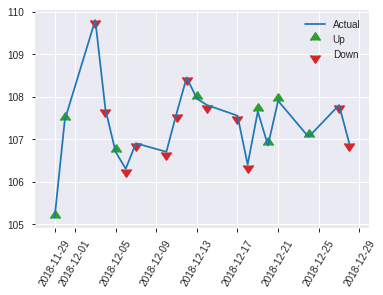


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2234024387518158
RMSE: 0.47265467177614545
LogLoss: 0.6435317321238309
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.07426846610866
Residual deviance: 323.0529295261631
AIC: 425.0529295261631
AUC: 0.6906461067924047
pr_auc: 0.6532572450427905
Gini: 0.38129221358480936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40643087089034585: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   62   0.5254   (62.0/118.0)
1      19   114  0.1429   (19.0/133.0)
Total  75   176  0.3227   (81.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406431     0.737864  175
max f2                       0.116139     0.851613  242
max f0point5                 0.537987     0.692432  121
max accuracy                 0.406431     0.677291  175
max precision                0.918482     1         0
max recall                   0.0655845    1         249
max specificity              0.918482     1         0
max absolute_mcc             0.406431     0.361702  175
max min_per_class_accuracy   0.537987     0.646617  121
max mean_per_class_accuracy  0.537987     0.670766  121

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.880088           1.25815   1.25815            0.666667         0.901326  0.666667                    0.901326            0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.867255           0.629073  0.943609           0.333333         0.868682  0.5                         0.885004            0.0075188       0.0225564                  -37.0927  -5.6391
    3        0.0318725                   0.856576           0.943609  0.943609           0.5              0.861226  0.5                         0.879059            0.0075188       0.0300752                  -5.6391   -5.6391
    4        0.0438247                   0.834509           1.25815   1.02939            0.666667         0.845132  0.545455                    0.869806            0.0150376       0.0451128                  25.8145   2.93917
    5        0.0517928                   0.825474           1.88722   1.16136            1                0.829713  0.615385                    0.863638            0.0150376       0.0601504                  88.7218   16.1365
    6        0.103586                    0.784464           1.30654   1.23395            0.692308         0.807644  0.653846                    0.835641            0.0676692       0.12782                    30.6536   23.395
    7        0.151394                    0.744124           1.72995   1.39058            0.916667         0.772935  0.736842                    0.815839            0.0827068       0.210526                   72.995    39.0582
    8        0.203187                    0.706823           0.871024  1.25815            0.461538         0.725717  0.666667                    0.792867            0.0451128       0.255639                   -12.8976  25.8145
    9        0.302789                    0.654811           1.3588    1.29125            0.72             0.676212  0.684211                    0.754493            0.135338        0.390977                   35.8797   29.1254
    10       0.40239                     0.587837           1.43429   1.32666            0.76             0.621792  0.70297                     0.721647            0.142857        0.533835                   43.4286   32.6658
    11       0.501992                    0.523379           1.13233   1.2881             0.6              0.554007  0.68254                     0.688385            0.112782        0.646617                   13.2331   28.8101
    12       0.601594                    0.473416           0.905865  1.22482            0.48             0.493962  0.649007                    0.656196            0.0902256       0.736842                   -9.41353  22.4817
    13       0.701195                    0.406431           1.20782   1.2224             0.64             0.436103  0.647727                    0.624932            0.120301        0.857143                   20.782    22.2403
    14       0.800797                    0.339479           0.452932  1.1267             0.24             0.370511  0.597015                    0.593288            0.0451128       0.902256                   -54.7068  12.6697
    15       0.900398                    0.241853           0.452932  1.05217            0.24             0.287809  0.557522                    0.559496            0.0451128       0.947368                   -54.7068  5.21658
    16       1                           0.0570058          0.528421  1                  0.28             0.151547  0.52988                     0.518864          

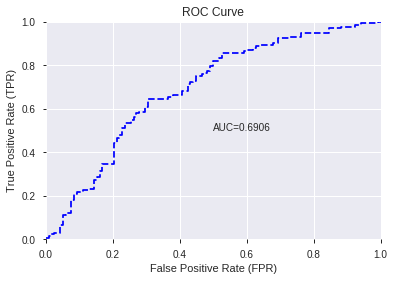

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


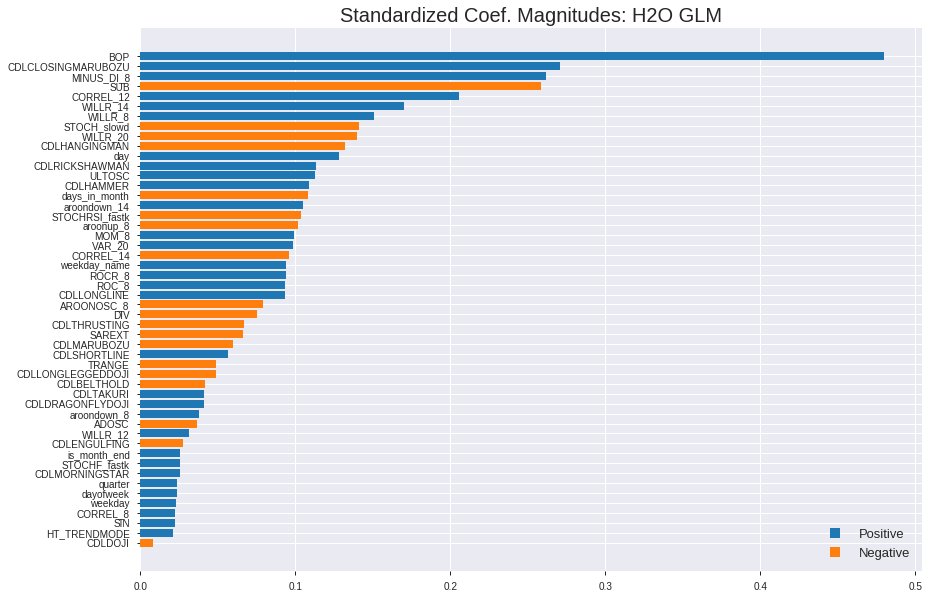

'log_likelihood'
--2019-08-27 13:57:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_135729_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_135729_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'MINUS_DI_8',
 'SUB',
 'CORREL_12',
 'WILLR_14',
 'WILLR_8',
 'STOCH_slowd',
 'WILLR_20',
 'CDLHANGINGMAN',
 'day',
 'CDLRICKSHAWMAN',
 'ULTOSC',
 'CDLHAMMER',
 'days_in_month',
 'aroondown_14',
 'STOCHRSI_fastk',
 'aroonup_8',
 'MOM_8',
 'VAR_20',
 'CORREL_14',
 'weekday_name',
 'ROCR_8',
 'ROC_8',
 'CDLLONGLINE',
 'AROONOSC_8',
 'DIV',
 'CDLTHRUSTING',
 'SAREXT',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLLONGLEGGEDDOJI',
 'CDLBELTHOLD',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'aroondown_8',
 'ADOSC',
 'WILLR_12',
 'CDLENGULFING',
 'is_month_end',
 'STOCHF_fastk',
 'CDLMORNINGSTAR',
 'quarter',
 'dayofweek',
 'weekday',
 'CORREL_8',
 'SIN',
 'HT_TRENDMODE',
 'CDLDOJI']

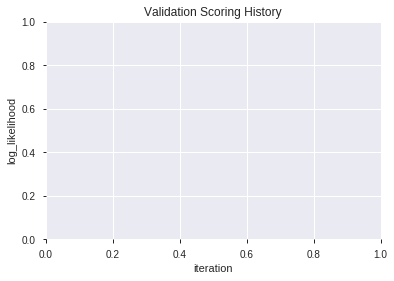

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_135741  0.735122  0.608259              0.333248  0.456156  0.208078
1  XGBoost_grid_1_AutoML_20190827_135741_model_4  0.732764  0.608068              0.311042  0.457348  0.209167
2  XGBoost_grid_1_AutoML_20190827_135741_model_2  0.731872  0.609212              0.348828  0.457616  0.209412
3  XGBoost_grid_1_AutoML_20190827_135741_model_6  0.728431  0.616702              0.358672  0.460641  0.212190
4  XGBoost_grid_1_AutoML_20190827_135741_model_3  0.726583  0.620873              0.349720  0.461250  0.212752
5               XGBoost_3_AutoML_20190827_135741  0.721932  0.621147              0.355391  0.462265  0.213689
6  XGBoost_grid_1_AutoML_20190827_135741_model_5  0.719128  0.623010              0.363387  0.462816  0.214199
7               XGBoost_2_AutoML_20190827_135741  0.716707  0.624185              0.353479  0.464118  0.215405
8  XGBoost_grid_1_AutoML_20190827_135741_model_7  0.707595  0.633095              0.318083  0.467692  0.218736
9  XGBoost_grid_1_AutoML_20190827_135741_model_1  0.704346  0.632036              0.339334  0.467176  0.218253

variable  relative_importance  scaled_importance  percentage
0                  BOP          1551.175171           1.000000    0.175096
1         STOCHF_fastk           536.288452           0.345730    0.060536
2              WILLR_8           369.469116           0.238187    0.041705
3                  SUB           360.048950           0.232114    0.040642
4                  SIN           345.398834           0.222669    0.038988
5            CORREL_12           335.034393           0.215987    0.037819
6             CORREL_8           322.112244           0.207657    0.036360
7           MINUS_DI_8           312.854950           0.201689    0.035315
8          STOCH_slowd           306.457367           0.197565    0.034593
9            CORREL_14           302.349609           0.194916    0.034129
10                 DIV           284.569580           0.183454    0.032122
11              TRANGE           283.609711           0.182835    0.032014
12              VAR_20           251.289368           0.161999    0.028365
13              SAREXT           233.085022           0.150264    0.026311
14               ROC_8           229.526337           0.147969    0.025909
15               ADOSC           219.214249           0.141321    0.024745
16               MOM_8           216.306580           0.139447    0.024417
17  CDLCLOSINGMARUBOZU           214.659332           0.138385    0.024231
18                 day           212.157074           0.136772    0.023948
19            WILLR_20           209.971024           0.135363    0.023701
20      STOCHRSI_fastk           208.973770           0.134720    0.023589
21            WILLR_14           200.909805           0.129521    0.022679
22          AROONOSC_8           188.923920           0.121794    0.021326
23              ULTOSC           184.097748           0.118683    0.020781
24           aroonup_8           147.787964           0.095275    0.016682
25            WILLR_12           140.711624           0.090713    0.015883
26        aroondown_14           137.980911           0.088953    0.015575
27           dayofweek            99.391914           0.064075    0.011219
28        weekday_name            88.898941           0.057311    0.010035
29       days_in_month            71.678391           0.046209    0.008091
30         aroondown_8            67.856270           0.043745    0.007660
31             quarter            58.453892           0.037684    0.006598
32              ROCR_8            44.750229           0.028849    0.005051
33             weekday            37.349300           0.024078    0.004216
34        HT_TRENDMODE            35.310413           0.022764    0.003986
35         CDLLONGLINE            15.723479           0.010136    0.001775
36         CDLBELTHOLD            11.171500           0.007202    0.001261
37      CDLRICKSHAWMAN             8.471166           0.005461    0.000956
38        CDLSHORTLINE             7.480824           0.004823    0.000844
39             CDLDOJI             3.870665           0.002495    0.000437
40       CDLHANGINGMAN             3.635294           0.002344    0.000410

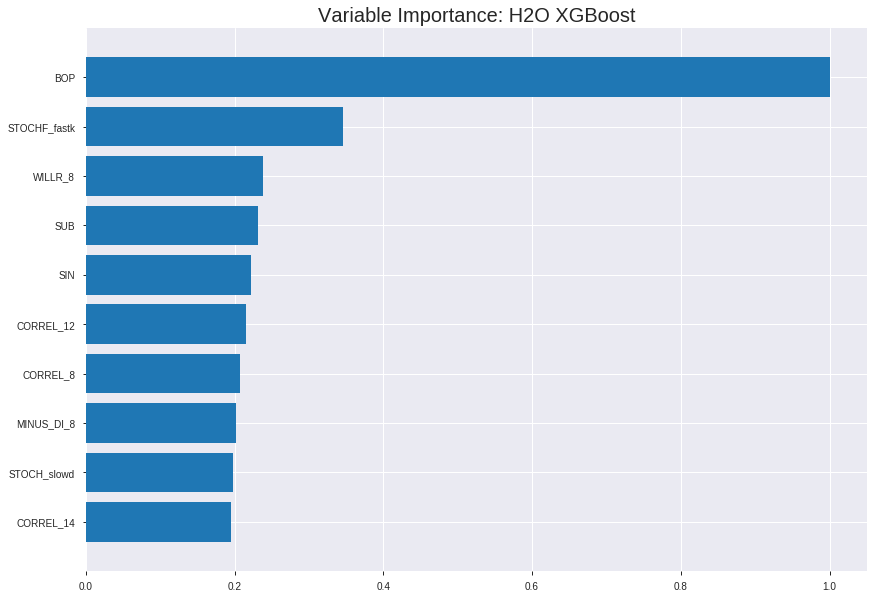

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_135741


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1302515516324346
RMSE: 0.3609037983070206
LogLoss: 0.4293494216395069
Mean Per-Class Error: 0.13181218916837445
AUC: 0.9420316150843895
pr_auc: 0.9487894620976371
Gini: 0.884063230168779
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5216418385505677: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      700  130  0.1566   (130.0/830.0)
1      104  819  0.1127   (104.0/923.0)
Total  804  949  0.1335   (234.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.521642     0.875     195
max f2                       0.443295     0.91155   234
max f0point5                 0.589874     0.898004  157
max accuracy                 0.536734     0.868226  187
max precision                0.921713     1         0
max recall                   0.179605     1         358
max specificity              0.921713     1         0
max absolute_mcc             0.536734     0.735942  187
max min_per_class_accuracy   0.536734     0.86747   187
max mean_per_class_accuracy  0.536734     0.868188  187

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.872871           1.89924    1.89924            1                0.88952   1                           0.88952             0.0195016       0.0195016                  89.9242   89.9242
    2        0.0205362                   0.860199           1.89924    1.89924            1                0.865276  1                           0.877398            0.0195016       0.0390033                  89.9242   89.9242
    3        0.0302339                   0.846845           1.89924    1.89924            1                0.852263  1                           0.869336            0.0184182       0.0574215                  89.9242   89.9242
    4        0.040502                    0.837411           1.89924    1.89924            1                0.843389  1                           0.862758            0.0195016       0.0769231                  89.9242   89.9242
    5        0.0501997                   0.831052           1.89924    1.89924            1                0.834147  1                           0.857231            0.0184182       0.0953413                  89.9242   89.9242
    6        0.100399                    0.800213           1.89924    1.89924            1                0.81323   1                           0.83523             0.0953413       0.190683                   89.9242   89.9242
    7        0.150029                    0.766342           1.89924    1.89924            1                0.783387  1                           0.818081            0.0942579       0.28494                    89.9242   89.9242
    8        0.200228                    0.741952           1.76975    1.86678            0.931818         0.754805  0.982906                    0.802217            0.0888407       0.373781                   76.9748   86.6776
    9        0.300057                    0.689036           1.83412    1.85591            0.965714         0.718645  0.977186                    0.774412            0.183099        0.55688                    83.4125   85.5913
    10       0.399886                    0.622637           1.66048    1.80712            0.874286         0.657211  0.951498                    0.745154            0.165764        0.722644                   66.048    80.7124
    11       0.500285                    0.551985           1.24098    1.69351            0.653409         0.586402  0.891676                    0.713295            0.124594        0.847237                   24.0982   69.3508
    12       0.600114                    0.467541           0.748844   1.53636            0.394286         0.511336  0.808935                    0.679699            0.0747562       0.921993                   -25.1156  53.6364
    13       0.699943                    0.387864           0.455818   1.38225            0.24             0.428279  0.727791                    0.64384             0.0455038       0.967497                   -54.4182  38.2252
    14       0.799772                    0.296207           0.282173   1.24494            0.148571         0.342383  0.655492                    0.606212            0.028169        0.995666                   -71.7827  24.4938
    15       0.899601                    0.203962           0.0325584  1.1104             0.0171429        0.250326  0.584654                    0.566719            0.00325027      0.998917                   -96.7442  11.04
    16       1                           0.0631507          0.0107911  1                  0.00568182       0.145884  0.526526                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21135468090295248
RMSE: 0.45973327147700815
LogLoss: 0.6091239736811682
Mean Per-Class Error: 0.30683195153061227
AUC: 0.7267777423469388
pr_auc: 0.7315059711469957
Gini: 0.45355548469387763
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29030589759349823: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   188  0.7673   (188.0/245.0)
1      13   243  0.0508   (13.0/256.0)
Total  70   431  0.4012   (201.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290306     0.707424  338
max f2                       0.175459     0.84893   372
max f0point5                 0.534609     0.703125  184
max accuracy                 0.534609     0.692615  184
max precision                0.897318     1         0
max recall                   0.144947     1         385
max specificity              0.897318     1         0
max absolute_mcc             0.534609     0.386583  184
max min_per_class_accuracy   0.525313     0.6875    193
max mean_per_class_accuracy  0.534609     0.693168  184

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.864491           1.95703   1.95703            1                0.879229  1                           0.879229            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.848719           1.56563   1.77912            0.8              0.852072  0.909091                    0.866885            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.841369           1.95703   1.83472            1                0.843594  0.9375                      0.859607            0.0195312       0.0585938                  95.7031   83.4717
    4        0.0419162                   0.821561           1.95703   1.86384            1                0.829242  0.952381                    0.852377            0.0195312       0.078125                   95.7031   86.3839
    5        0.0518962                   0.802818           1.95703   1.88176            1                0.806361  0.961538                    0.843528            0.0195312       0.0976562                  95.7031   88.1761
    6        0.101796                    0.761587           1.40906   1.65005            0.72             0.784935  0.843137                    0.814806            0.0703125       0.167969                   40.9063   65.0046
    7        0.151697                    0.723661           1.2525    1.51927            0.64             0.743313  0.776316                    0.791288            0.0625          0.230469                   25.25     51.9274
    8        0.201597                    0.684807           1.48734   1.51137            0.76             0.702434  0.772277                    0.769295            0.0742188       0.304688                   48.7344   51.1371
    9        0.301397                    0.633987           1.33078   1.45157            0.68             0.65942   0.741722                    0.732912            0.132812        0.4375                     33.0781   45.1573
    10       0.401198                    0.582794           1.33078   1.42153            0.68             0.609667  0.726368                    0.702254            0.132812        0.570312                   33.0781   42.1525
    11       0.500998                    0.52548            1.17422   1.37226            0.6              0.551277  0.701195                    0.672179            0.117188        0.6875                     17.4219   37.2261
    12       0.600798                    0.479094           0.587109  1.24184            0.3              0.504647  0.634551                    0.64435             0.0585938       0.746094                   -41.2891  24.1837
    13       0.700599                    0.416031           0.782813  1.17645            0.4              0.448334  0.60114                     0.616427            0.078125        0.824219                   -21.7187  17.6449
    14       0.800399                    0.346683           0.743672  1.12249            0.38             0.378742  0.573566                    0.586791            0.0742188       0.898438                   -25.6328  12.2487
    15       0.9002                      0.242617           0.704531  1.07615            0.36             0.295719  0.549889                    0.554521            0.0703125       0.96875                    -29.5469  7.61502
    16       1                           0.0724206          0.313125  1                  0.16             0.166434  0.510978                    0.51579          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:57:42  0.225 sec   0                  0.5              0.693147            0.5             0                  1                0.473474                         0.5                0.693147              0.5               0                    1                  0.489022
    2019-08-27 13:57:42  0.493 sec   5                  0.475797         0.645657            0.824287        0.830091           1.89924          0.261266                         0.485482           0.664381              0.712994          0.698469             1.30469            0.373253
    2019-08-27 13:57:42  0.636 sec   10                 0.4562           0.608089            0.855158        0.865442           1.89924          0.229321                         0.477837           0.64918               0.715195          0.699752             1.63086            0.351297
    2019-08-27 13:57:42  0.784 sec   15                 0.44043          0.578047            0.871439        0.879851           1.89924          0.224187                         0.471283           0.63592               0.723007          0.708441             1.63086            0.359281
    2019-08-27 13:57:43  0.916 sec   20                 0.42746          0.553348            0.880656        0.887391           1.89924          0.212208                         0.466809           0.626562              0.725526          0.71508              1.95703            0.363273
    2019-08-27 13:57:43  1.069 sec   25                 0.415675         0.530898            0.890703        0.898367           1.89924          0.18939                          0.464449           0.62116               0.721285          0.712017             1.95703            0.369261
    2019-08-27 13:57:43  1.219 sec   30                 0.404997         0.510662            0.899238        0.90816            1.89924          0.183115                         0.46193            0.615862              0.728197          0.719519             1.95703            0.355289
    2019-08-27 13:57:43  1.370 sec   35                 0.396629         0.494656            0.905237        0.91336            1.89924          0.185967                         0.459835           0.611159              0.731529          0.728033             1.95703            0.351297
    2019-08-27 13:57:43  1.519 sec   40                 0.388671         0.479707            0.914082        0.923371           1.89924          0.169424                         0.459061           0.608909              0.731043          0.732758             1.95703            0.371257
    2019-08-27 13:57:43  1.658 sec   45                 0.381967         0.46705             0.920209        0.92911            1.89924          0.16486                          0.459154           0.608531              0.730301          0.733258             1.95703            0.377246
    2019-08-27 13:57:44  1.825 sec   50                 0.374736         0.453739            0.927014        0.936165           1.89924          0.153451                         0.460576           0.611174              0.724833          0.727425             1.95703            0.389222
    2019-08-27 13:57:44  1.974 sec   55                 0.367727         0.441161            0.934531        0.943103           1.89924          0.148888                         0.459733           0.609121              0.726419          0

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ----------------------
BOP             1551.1751708984375     1.0                   0.17509586053977136
STOCHF_fastk    536.2884521484375      0.3457304256861076    0.06053596640029048
WILLR_8         369.4691162109375      0.2381865846891694    0.04170548501517924
SUB             360.0489501953125      0.2321136625638308    0.04064214148965206
SIN             345.3988342285156      0.22266913544552247   0.03898844388648066
---             ---                    ---                   ---
CDLBELTHOLD     11.171500205993652     0.007201959143997349  0.001261033233890491
CDLRICKSHAWMAN  8.471165657043457      0.005461127676596947  0.0009562208500513047
CDLSHORTLINE    7.480823516845703      0.004822681317489646  0.0008444315353949278
CDLDOJI         3.8706648349761963     0.002495311237308108  0.00043691866841102483
CDLHANGINGMAN   3.635294198989868      0.002343574257241568  0.00041035015131056783


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.751552795031056)

('auc', 0.7351217025614885)

('logloss', 0.6082590305740684)

('mean_per_class_error', 0.2925958965209634)

('rmse', 0.45615576857742485)

('mse', 0.20807808520646115)

xgboost prediction progress: |████████████████████████████████████████████| 100%


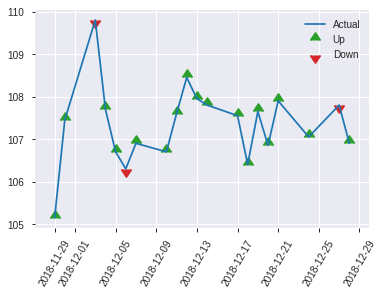


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20807808520646115
RMSE: 0.45615576857742485
LogLoss: 0.6082590305740684
Mean Per-Class Error: 0.2925958965209634
AUC: 0.7351217025614885
pr_auc: 0.6801893960364107
Gini: 0.4702434051229769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3635583221912384: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   68   0.5763   (68.0/118.0)
1      12   121  0.0902   (12.0/133.0)
Total  62   189  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363558     0.751553  188
max f2                       0.261352     0.861148  216
max f0point5                 0.526191     0.723781  135
max accuracy                 0.526191     0.709163  135
max precision                0.61155      0.768421  94
max recall                   0.107973     1         247
max specificity              0.876411     0.991525  0
max absolute_mcc             0.472271     0.417825  157
max min_per_class_accuracy   0.542134     0.694915  128
max mean_per_class_accuracy  0.526191     0.707404  135

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 51.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.862237           0.629073  0.629073           0.333333         0.868775  0.333333                    0.868775            0.0075188       0.0075188                  -37.0927  -37.0927
    2        0.0239044                   0.855458           1.25815   0.943609           0.666667         0.85794   0.5                         0.863357            0.0150376       0.0225564                  25.8145   -5.6391
    3        0.0318725                   0.835365           0.943609  0.943609           0.5              0.842107  0.5                         0.858045            0.0075188       0.0300752                  -5.6391   -5.6391
    4        0.0438247                   0.820852           1.88722   1.20096            1                0.82507   0.636364                    0.849052            0.0225564       0.0526316                  88.7218   20.0957
    5        0.0517928                   0.807337           0         1.01619            0                0.810111  0.538462                    0.843061            0               0.0526316                  -100      1.61943
    6        0.103586                    0.772167           1.59688   1.30654            0.846154         0.791412  0.692308                    0.817236            0.0827068       0.135338                   59.6877   30.6536
    7        0.151394                    0.728946           1.25815   1.29125            0.666667         0.747543  0.684211                    0.795228            0.0601504       0.195489                   25.8145   29.1254
    8        0.203187                    0.693822           1.59688   1.36916            0.846154         0.706774  0.72549                     0.772681            0.0827068       0.278195                   59.6877   36.9158
    9        0.302789                    0.641933           1.43429   1.39058            0.76             0.667268  0.736842                    0.738006            0.142857        0.421053                   43.4286   39.0582
    10       0.40239                     0.60183            1.3588    1.38271            0.72             0.62114   0.732673                    0.709079            0.135338        0.556391                   35.8797   38.2714
    11       0.501992                    0.554502           1.20782   1.34801            0.64             0.576531  0.714286                    0.682779            0.120301        0.676692                   20.782    34.8013
    12       0.601594                    0.502723           1.13233   1.3123             0.6              0.523737  0.695364                    0.656448            0.112782        0.789474                   13.2331   31.2304
    13       0.701195                    0.396627           0.679398  1.2224             0.36             0.453683  0.647727                    0.627646            0.0676692       0.857143                   -32.0602  22.2403
    14       0.800797                    0.326191           0.679398  1.15486            0.36             0.364435  0.61194                     0.594908            0.0676692       0.924812                   -32.0602  15.4865
    15       0.900398                    0.224794           0.452932  1.07722            0.24             0.278255  0.570796                    0.55988             0.0451128       0.969925                   -54.7068  7.72174
    16       1                           0.0907636          0.301955  1                  0.16             0.155953  0.52988                     0.519649        

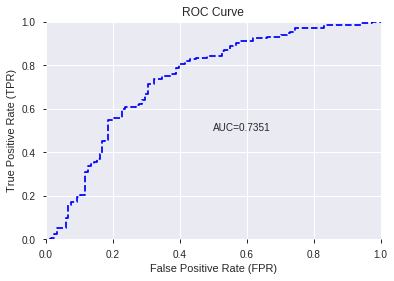

This function is available for GLM models only


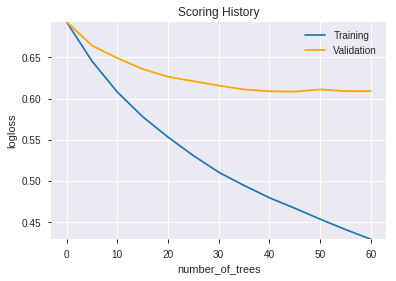

--2019-08-27 13:58:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.48.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.48.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_135741',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_135741',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_9baf',
   'type

['BOP',
 'STOCHF_fastk',
 'WILLR_8',
 'SUB',
 'SIN',
 'CORREL_12',
 'CORREL_8',
 'MINUS_DI_8',
 'STOCH_slowd',
 'CORREL_14',
 'DIV',
 'TRANGE',
 'VAR_20',
 'SAREXT',
 'ROC_8',
 'ADOSC',
 'MOM_8',
 'CDLCLOSINGMARUBOZU',
 'day',
 'WILLR_20',
 'STOCHRSI_fastk',
 'WILLR_14',
 'AROONOSC_8',
 'ULTOSC',
 'aroonup_8',
 'WILLR_12',
 'aroondown_14',
 'dayofweek',
 'weekday_name',
 'days_in_month',
 'aroondown_8',
 'quarter',
 'ROCR_8',
 'weekday',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLRICKSHAWMAN',
 'CDLSHORTLINE',
 'CDLDOJI',
 'CDLHANGINGMAN']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_135814_model_1  0.698101  0.637049               0.33653  0.469968  0.22087

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.260841           1.000000  2.780747e-02
1           CDLCLOSINGMARUBOZU             0.192354           0.737437  2.050625e-02
2                          DIV             0.138213           0.529874  1.473446e-02
3                          SUB             0.129238           0.495466  1.377766e-02
4                    CORREL_12             0.124060           0.475614  1.322563e-02
...                        ...                  ...                ...           ...
1037   BBANDS_lowerband_12_1_3             0.000030           0.000116  3.218007e-06
1038   BBANDS_middleband_8_3_4             0.000026           0.000100  2.779263e-06
1039  BBANDS_middleband_20_5_5             0.000025           0.000094  2.621590e-06
1040   BBANDS_middleband_8_3_5             0.000013           0.000050  1.395718e-06
1041   BBANDS_lowerband_12_4_3             0.000004           0.000013  3.733972e-07

[1042 rows x 4 columns]

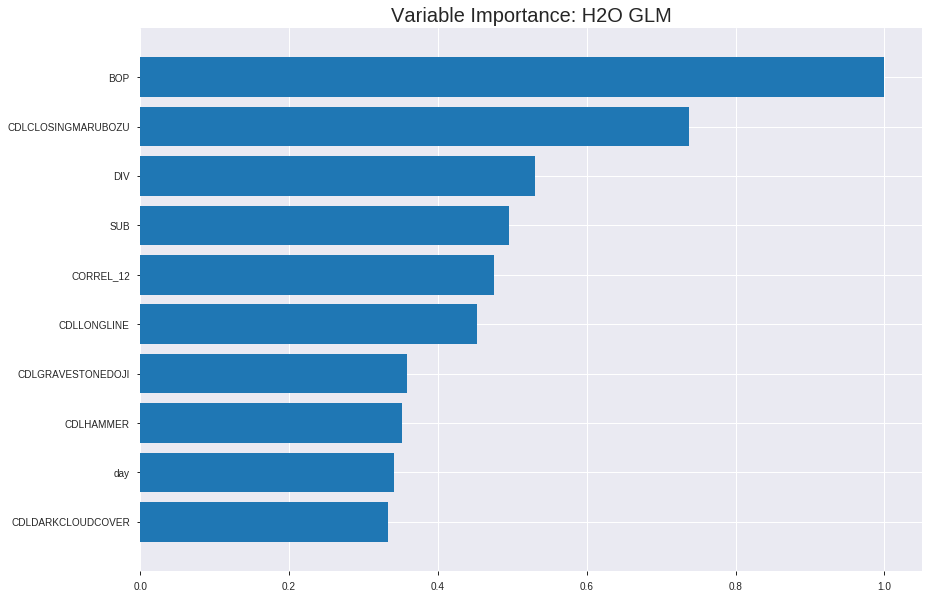

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_135814_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19448287449443274
RMSE: 0.44100212527201355
LogLoss: 0.5721428209746792
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2425.2378703291097
Residual deviance: 2005.9327303372252
AIC: 4091.932730337225
AUC: 0.7736989126603924
pr_auc: 0.7771096846147837
Gini: 0.5473978253207847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44823013615255264: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      459  371   0.447    (371.0/830.0)
1      136  787   0.1473   (136.0/923.0)
Total  595  1158  0.2892   (507.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44823      0.756367  236
max f2                       0.178298     0.856503  362
max f0point5                 0.560749     0.722878  174
max accuracy                 0.453724     0.712493  233
max precision                0.951664     1         0
max recall                   0.143599     1         374
max specificity              0.951664     1         0
max absolute_mcc             0.453724     0.429383  233
max min_per_class_accuracy   0.543683     0.698795  184
max mean_per_class_accuracy  0.453724     0.705126  233

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.890326           1.79373   1.79373            0.944444         0.912774  0.944444                    0.912774            0.0184182       0.0184182                  79.3728   79.3728
    2        0.0205362                   0.856579           1.79373   1.79373            0.944444         0.870056  0.944444                    0.891415            0.0184182       0.0368364                  79.3728   79.3728
    3        0.0302339                   0.842124           1.89924   1.82757            1                0.849432  0.962264                    0.877949            0.0184182       0.0552546                  89.9242   82.7572
    4        0.040502                    0.830565           1.5827    1.76549            0.833333         0.835315  0.929577                    0.86714             0.0162514       0.071506                   58.2701   76.5492
    5        0.0501997                   0.823476           1.56408   1.72658            0.823529         0.827096  0.909091                    0.859404            0.0151679       0.0866739                  56.4081   72.6583
    6        0.100399                    0.773922           1.64025   1.68342            0.863636         0.799822  0.886364                    0.829613            0.0823402       0.169014                   64.0254   68.3419
    7        0.150029                    0.734655           1.52813   1.63205            0.804598         0.753611  0.859316                    0.804472            0.0758397       0.244854                   52.8125   63.2048
    8        0.200228                    0.708268           1.44601   1.58541            0.761364         0.721015  0.834758                    0.783548            0.0725894       0.317443                   44.6013   58.5407
    9        0.300057                    0.652839           1.42172   1.53095            0.748571         0.680367  0.806084                    0.74922             0.141928        0.459372                   42.1718   53.0948
    10       0.399886                    0.602181           1.16125   1.43866            0.611429         0.627502  0.757489                    0.718834            0.115926        0.575298                   16.1251   43.8655
    11       0.500285                    0.549241           1.14386   1.37949            0.602273         0.57712   0.72634                     0.690394            0.114843        0.690141                   14.3861   37.9495
    12       0.600114                    0.486202           0.9659    1.31069            0.508571         0.51779   0.690114                    0.661682            0.0964247       0.786566                   -3.41     31.0693
    13       0.699943                    0.419601           0.88993   1.25068            0.468571         0.453317  0.658517                    0.631964            0.0888407       0.875406                   -11.007   25.0682
    14       0.799772                    0.338788           0.607757  1.17043            0.32             0.37814   0.616262                    0.600281            0.0606717       0.936078                   -39.2243  17.0431
    15       0.899601                    0.245776           0.379848  1.0827             0.2              0.293164  0.57007                     0.5662              0.0379198       0.973998                   -62.0152  8.27002
    16       1                           0.00827103         0.258987  1                  0.136364         0.171036  0.526526                    0.526526         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2039023663137485
RMSE: 0.4515554963830564
LogLoss: 0.5921871198892583
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 694.7772912382
Residual deviance: 593.3714941290368
AIC: 2679.371494129037
AUC: 0.749154974489796
pr_auc: 0.7477797913767799
Gini: 0.4983099489795919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39804120410664423: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  135  0.551    (135.0/245.0)
1      36   220  0.1406   (36.0/256.0)
Total  146  355  0.3413   (171.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398041     0.720131  278
max f2                       0.180027     0.854473  372
max f0point5                 0.632593     0.705556  122
max accuracy                 0.517964     0.690619  206
max precision                0.904626     1         0
max recall                   0.180027     1         372
max specificity              0.904626     1         0
max absolute_mcc             0.632593     0.382477  122
max min_per_class_accuracy   0.541246     0.679688  193
max mean_per_class_accuracy  0.517964     0.6899    206

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.864919           1.63086   1.63086            0.833333         0.883604  0.833333                    0.883604            0.0195312       0.0195312                  63.0859   63.0859
    2        0.0219561                   0.837694           1.95703   1.77912            1                0.853499  0.909091                    0.86992             0.0195312       0.0390625                  95.7031   77.9119
    3        0.0319361                   0.827565           1.95703   1.83472            1                0.831489  0.9375                      0.85791             0.0195312       0.0585938                  95.7031   83.4717
    4        0.0419162                   0.820167           1.17422   1.67746            0.6              0.822707  0.857143                    0.849529            0.0117188       0.0703125                  17.4219   67.7455
    5        0.0518962                   0.807841           1.56563   1.65595            0.8              0.810179  0.846154                    0.841961            0.015625        0.0859375                  56.5625   65.595
    6        0.101796                    0.761856           1.64391   1.65005            0.84             0.783901  0.843137                    0.8135              0.0820312       0.167969                   64.3906   65.0046
    7        0.151697                    0.730572           1.72219   1.67378            0.88             0.74469   0.855263                    0.790865            0.0859375       0.253906                   72.2188   67.3777
    8        0.201597                    0.699977           1.56563   1.64701            0.8              0.713212  0.841584                    0.771644            0.078125        0.332031                   56.5625   64.7006
    9        0.301397                    0.643162           1.36992   1.55526            0.7              0.668839  0.794702                    0.737603            0.136719        0.46875                    36.9922   55.5257
    10       0.401198                    0.592527           0.978516  1.41179            0.5              0.614764  0.721393                    0.707046            0.0976562       0.566406                   -2.14844  41.1789
    11       0.500998                    0.541246           1.13508   1.35667            0.58             0.564906  0.693227                    0.678731            0.113281        0.679688                   13.5078   35.6667
    12       0.600798                    0.484782           0.821953  1.26784            0.42             0.511014  0.647841                    0.650871            0.0820312       0.761719                   -17.8047  26.7844
    13       0.700599                    0.405039           0.861094  1.2099             0.44             0.442364  0.618234                    0.621169            0.0859375       0.847656                   -13.8906  20.9903
    14       0.800399                    0.330081           0.665391  1.14201            0.34             0.368828  0.583541                    0.589705            0.0664062       0.914062                   -33.4609  14.2008
    15       0.9002                      0.239147           0.547969  1.07615            0.28             0.284903  0.549889                    0.555914            0.0546875       0.96875                    -45.2031  7.61502
    16       1                           0.0261798          0.313125  1                  0.16             0.167705  0.510978                    0.51717           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 13:58:19  0.000 sec   2            .17E2     1026          1.3591780076236464  1.3632119793734263
     2019-08-27 13:58:21  2.356 sec   4            .12E2     1042          1.3525031239643188  1.3569263827017581
     2019-08-27 13:58:24  4.753 sec   6            .91E1     1043          1.3443180182193968  1.3490369699689828
     2019-08-27 13:58:26  7.097 sec   8            .66E1     1043          1.3345255318992364  1.339510242193205
     2019-08-27 13:58:28  9.460 sec   10           .48E1     1043          1.3231148211235622  1.3283654035530978
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 13:59:02  43.031 sec  38           .56E-1    1043          1.136434295642705   1.185562199038736
     2019-08-27 13:59:04  45.435 sec  40           .41E-1    1043          1.129513082764986   1.1885776600640414
     2019-08-27 13:59:07  47.949 sec  42           .3E-1     1043          1.1233953498695621  1.1932143581029568
     2019-08-27 13:59:09  50.328 sec  44           .22E-1    1043          1.117958694606084   1.1985733216471255
     2019-08-27 13:59:12  52.685 sec  46           .16E-1    1043          1.113051718392566   1.2046376560237329


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7460815047021944)

('auc', 0.6981011851663056)

('logloss', 0.637049498172329)

('mean_per_class_error', 0.31712756467439784)

('rmse', 0.4699679501143324)

('mse', 0.22086987413466763)

glm prediction progress: |████████████████████████████████████████████████| 100%


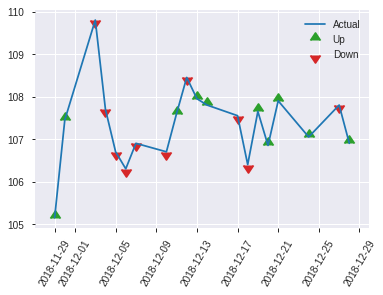


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22086987413466763
RMSE: 0.4699679501143324
LogLoss: 0.637049498172329
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 347.07426846610866
Residual deviance: 319.7988480825092
AIC: 2405.7988480825093
AUC: 0.6981011851663056
pr_auc: 0.6576907780743979
Gini: 0.3962023703326112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3893945166034505: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   67   0.5678   (67.0/118.0)
1      14   119  0.1053   (14.0/133.0)
Total  65   186  0.3227   (81.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389395     0.746082  185
max f2                       0.162883     0.854922  239
max f0point5                 0.461972     0.697211  154
max accuracy                 0.461972     0.689243  154
max precision                0.949974     1         0
max recall                   0.0662964    1         250
max specificity              0.949974     1         0
max absolute_mcc             0.446449     0.37857   162
max min_per_class_accuracy   0.543346     0.661654  126
max mean_per_class_accuracy  0.461972     0.682872  154

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 52.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.861512           1.88722   1.88722            1                0.903791  1                           0.903791            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.846097           0.629073  1.25815            0.333333         0.850661  0.666667                    0.877226            0.0075188       0.0300752                  -37.0927  25.8145
    3        0.0318725                   0.837553           1.88722   1.41541            1                0.842617  0.75                        0.868574            0.0150376       0.0451128                  88.7218   41.5414
    4        0.0438247                   0.825595           0.629073  1.20096            0.333333         0.828292  0.636364                    0.857588            0.0075188       0.0526316                  -37.0927  20.0957
    5        0.0517928                   0.822088           0.943609  1.16136            0.5              0.822932  0.615385                    0.852256            0.0075188       0.0601504                  -5.6391   16.1365
    6        0.103586                    0.781036           1.16136   1.16136            0.615385         0.805668  0.615385                    0.828962            0.0601504       0.120301                   16.1365   16.1365
    7        0.151394                    0.749575           1.41541   1.24159            0.75             0.764806  0.657895                    0.808702            0.0676692       0.18797                    41.5414   24.1591
    8        0.203187                    0.722876           1.16136   1.22114            0.615385         0.73472   0.647059                    0.789844            0.0601504       0.24812                    16.1365   22.1141
    9        0.302789                    0.646097           1.43429   1.29125            0.76             0.679885  0.684211                    0.753673            0.142857        0.390977                   43.4286   29.1254
    10       0.40239                     0.579132           1.28331   1.28929            0.68             0.613213  0.683168                    0.718906            0.12782         0.518797                   28.3308   28.9288
    11       0.501992                    0.544767           1.3588    1.30308            0.72             0.563046  0.690476                    0.687981            0.135338        0.654135                   35.8797   30.3079
    12       0.601594                    0.474387           1.13233   1.27481            0.6              0.509147  0.675497                    0.658373            0.112782        0.766917                   13.2331   27.481
    13       0.701195                    0.403914           0.754887  1.20096            0.4              0.440439  0.636364                    0.627416            0.075188        0.842105                   -24.5113  20.0957
    14       0.800797                    0.353446           0.754887  1.14548            0.4              0.383016  0.606965                    0.597018            0.075188        0.917293                   -24.5113  14.5476
    15       0.900398                    0.24967            0.452932  1.06887            0.24             0.302169  0.566372                    0.564402            0.0451128       0.962406                   -54.7068  6.88669
    16       1                           0.0662964          0.377444  1                  0.2              0.168751  0.52988                     0.524995          

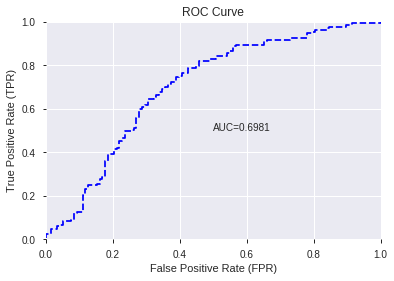

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


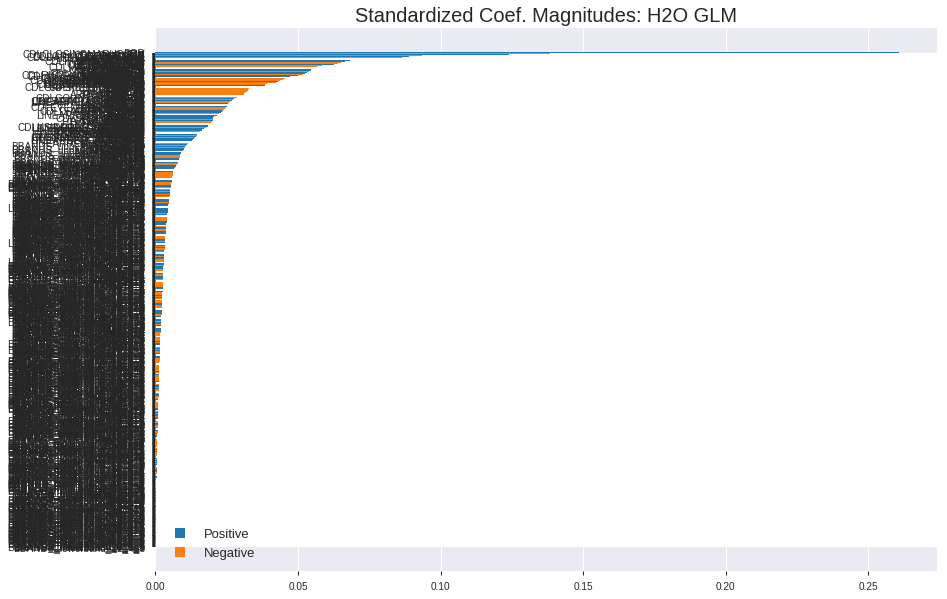

'log_likelihood'
--2019-08-27 13:59:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.136
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.136|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_135814_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_135814_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

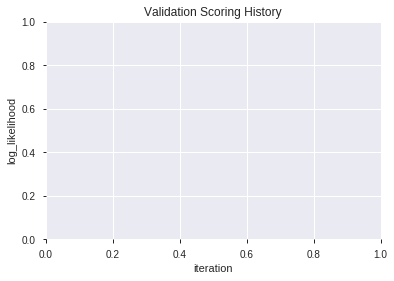

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_135944_model_2  0.736014  0.605902              0.366733  0.455701  0.207664
1  XGBoost_grid_1_AutoML_20190827_135944_model_3  0.731553  0.607202              0.339397  0.456604  0.208487
2  XGBoost_grid_1_AutoML_20190827_135944_model_4  0.731362  0.606707              0.315821  0.456198  0.208117
3               XGBoost_2_AutoML_20190827_135944  0.729005  0.609843              0.328533  0.457018  0.208865
4               XGBoost_3_AutoML_20190827_135944  0.727921  0.615387              0.310628  0.459552  0.211188
5  XGBoost_grid_1_AutoML_20190827_135944_model_5  0.727794  0.618896              0.324774  0.459263  0.210922
6  XGBoost_grid_1_AutoML_20190827_135944_model_1  0.724226  0.619599              0.360106  0.461267  0.212767
7  XGBoost_grid_1_AutoML_20190827_135944_model_7  0.721677  0.615956              0.317191  0.459606  0.211238
8  XGBoost_grid_1_AutoML_20190827_135944_model_6  0.720084  0.614902              0.315343  0.459475  0.211117
9               XGBoost_1_AutoML_20190827_135944  0.712820  0.626355              0.286033  0.464843  0.216079

variable  relative_importance  scaled_importance  percentage
0                        BOP          1837.409302           1.000000    0.187430
1               STOCHF_fastk           388.663147           0.211528    0.039647
2                        SUB           354.184540           0.192763    0.036130
3                   CORREL_8           187.541901           0.102069    0.019131
4       HT_PHASOR_quadrature           168.322128           0.091608    0.017170
..                       ...                  ...                ...         ...
354   BBANDS_upperband_8_6_3             0.344154           0.000187    0.000035
355  BBANDS_upperband_20_3_5             0.289098           0.000157    0.000029
356   BBANDS_lowerband_8_1_4             0.260721           0.000142    0.000027
357  BBANDS_upperband_14_0_4             0.175603           0.000096    0.000018
358  BBANDS_lowerband_20_7_4             0.153301           0.000083    0.000016

[359 rows x 4 columns]

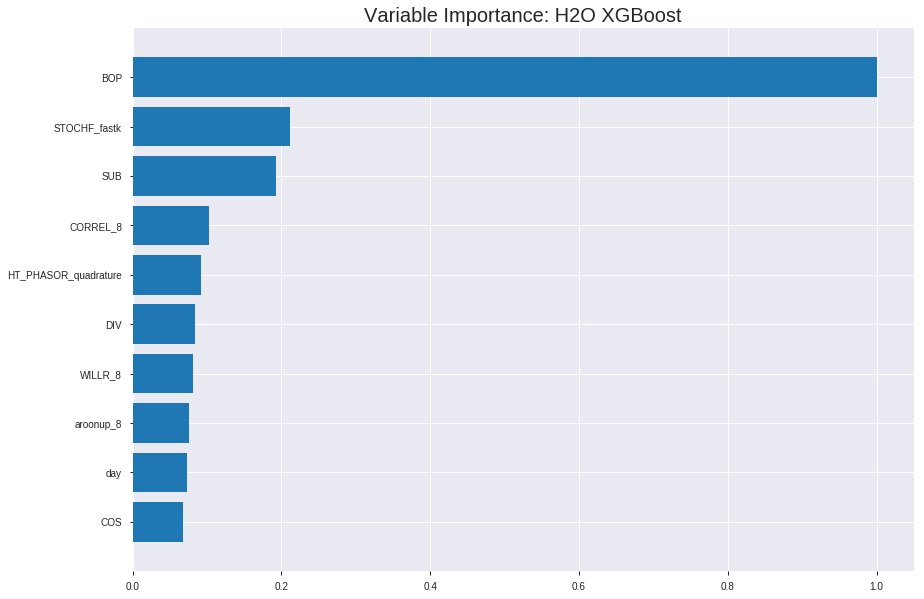

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_135944_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14191305346517671
RMSE: 0.3767134898900977
LogLoss: 0.45658408161548597
Mean Per-Class Error: 0.16038781344228492
AUC: 0.9229855500006527
pr_auc: 0.9333939970643026
Gini: 0.8459711000013055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5250303745269775: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      663  167  0.2012   (167.0/830.0)
1      119  804  0.1289   (119.0/923.0)
Total  782  971  0.1631   (286.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52503      0.848997  194
max f2                       0.376713     0.902316  269
max f0point5                 0.625929     0.880766  137
max accuracy                 0.581331     0.836851  161
max precision                0.887423     1         0
max recall                   0.231632     1         339
max specificity              0.887423     1         0
max absolute_mcc             0.588428     0.681005  157
max min_per_class_accuracy   0.548503     0.833735  180
max mean_per_class_accuracy  0.588428     0.839612  157

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.847951           1.89924   1.89924            1                0.860128  1                           0.860128            0.0195016       0.0195016                  89.9242   89.9242
    2        0.0205362                   0.837539           1.89924   1.89924            1                0.843418  1                           0.851773            0.0195016       0.0390033                  89.9242   89.9242
    3        0.0302339                   0.826615           1.89924   1.89924            1                0.831253  1                           0.845191            0.0184182       0.0574215                  89.9242   89.9242
    4        0.040502                    0.817798           1.89924   1.89924            1                0.821741  1                           0.839246            0.0195016       0.0769231                  89.9242   89.9242
    5        0.0501997                   0.808375           1.89924   1.89924            1                0.813415  1                           0.834256            0.0184182       0.0953413                  89.9242   89.9242
    6        0.100399                    0.771744           1.87766   1.88845            0.988636         0.789144  0.994318                    0.8117              0.0942579       0.189599                   87.7659   88.845
    7        0.150029                    0.747318           1.89924   1.89202            1                0.758679  0.996198                    0.794161            0.0942579       0.283857                   89.9242   89.202
    8        0.200228                    0.723582           1.83449   1.8776             0.965909         0.735737  0.988604                    0.779513            0.092091        0.375948                   83.4495   87.7598
    9        0.300057                    0.680162           1.7473    1.83425            0.92             0.702719  0.965779                    0.753964            0.174431        0.550379                   74.7302   83.4249
    10       0.399886                    0.623954           1.60622   1.77732            0.845714         0.652682  0.935806                    0.72868             0.160347        0.710726                   60.6216   77.7322
    11       0.500285                    0.559511           1.01437   1.62421            0.534091         0.591138  0.855188                    0.701077            0.101842        0.812568                   1.43677   62.4209
    12       0.600114                    0.484013           0.879078  1.50026            0.462857         0.524783  0.789924                    0.671751            0.0877573       0.900325                   -12.0922  50.0256
    13       0.699943                    0.403687           0.564346  1.36677            0.297143         0.444919  0.719641                    0.639399            0.056338        0.956663                   -43.5654  36.6773
    14       0.799772                    0.304506           0.314731  1.23546            0.165714         0.35289   0.650499                    0.603636            0.0314193       0.988082                   -68.5269  23.5455
    15       0.899601                    0.211506           0.119381  1.1116             0.0628571        0.256613  0.585289                    0.565127            0.0119177       1                          -88.0619  11.1604
    16       1                           0.092309           0         1                  0                0.158707  0.526526                    0.524323           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2012169075467074
RMSE: 0.4485720762003665
LogLoss: 0.587549728777377
Mean Per-Class Error: 0.301498724489796
AUC: 0.7605867346938775
pr_auc: 0.767604502513864
Gini: 0.521173469387755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4301891326904297: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  123  0.502    (123.0/245.0)
1      37   219  0.1445   (37.0/256.0)
Total  159  342  0.3194   (160.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430189     0.732441  261
max f2                       0.204314     0.853414  372
max f0point5                 0.530608     0.705329  198
max accuracy                 0.530608     0.698603  198
max precision                0.857837     1         0
max recall                   0.186957     1         379
max specificity              0.857837     1         0
max absolute_mcc             0.530608     0.396971  198
max min_per_class_accuracy   0.531913     0.693878  196
max mean_per_class_accuracy  0.530608     0.698501  198

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.821621           1.95703   1.95703            1                0.837866  1                           0.837866            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.804601           1.95703   1.95703            1                0.815017  1                           0.82748             0.0195312       0.0429688                  95.7031   95.7031
    3        0.0319361                   0.790089           1.95703   1.95703            1                0.795466  1                           0.817476            0.0195312       0.0625                     95.7031   95.7031
    4        0.0419162                   0.786745           1.95703   1.95703            1                0.787751  1                           0.810398            0.0195312       0.0820312                  95.7031   95.7031
    5        0.0518962                   0.766723           1.56563   1.88176            0.8              0.772786  0.961538                    0.803165            0.015625        0.0976562                  56.5625   88.1761
    6        0.101796                    0.723893           1.48734   1.68842            0.76             0.738906  0.862745                    0.771666            0.0742188       0.171875                   48.7344   68.8419
    7        0.151697                    0.693919           1.72219   1.69953            0.88             0.70867   0.868421                    0.750943            0.0859375       0.257812                   72.2188   69.9527
    8        0.201597                    0.66232            1.56563   1.66638            0.8              0.677074  0.851485                    0.732659            0.078125        0.335938                   56.5625   66.6383
    9        0.301397                    0.620844           1.21336   1.51638            0.62             0.643679  0.774834                    0.703195            0.121094        0.457031                   21.3359   51.6375
    10       0.401198                    0.576589           1.17422   1.43126            0.6              0.59949   0.731343                    0.677398            0.117188        0.574219                   17.4219   43.1262
    11       0.500998                    0.532876           1.13508   1.37226            0.58             0.554015  0.701195                    0.65282             0.113281        0.6875                     13.5078   37.2261
    12       0.600798                    0.481739           1.01766   1.31336            0.52             0.508652  0.671096                    0.628871            0.101562        0.789062                   1.76563   31.3357
    13       0.700599                    0.420464           0.743672  1.2322             0.38             0.450218  0.62963                     0.603422            0.0742188       0.863281                   -25.6328  23.2205
    14       0.800399                    0.343066           0.587109  1.15177            0.3              0.381555  0.588529                    0.575758            0.0585938       0.921875                   -41.2891  15.1769
    15       0.9002                      0.243806           0.547969  1.08483            0.28             0.290638  0.554324                    0.544148            0.0546875       0.976562                   -45.2031  8.48289
    16       1                           0.112796           0.234844  1                  0.12             0.184949  0.510978                    0.5083           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:00:13  4.706 sec   0                  0.5              0.693147            0.5             0                  1                0.473474                         0.5                0.693147              0.5               0                    1                  0.489022
    2019-08-27 14:00:14  5.919 sec   5                  0.481181         0.656099            0.809129        0.77655            1.63728          0.260696                         0.486238           0.665911              0.739461          0.680524             1.67746            0.323353
    2019-08-27 14:00:14  6.197 sec   10                 0.465734         0.626282            0.824443        0.816621           1.70932          0.268682                         0.477125           0.647957              0.743455          0.733922             1.73958            0.333333
    2019-08-27 14:00:15  6.480 sec   15                 0.453419         0.602601            0.830561        0.831151           1.79928          0.266971                         0.469508           0.632841              0.749872          0.74639              1.95703            0.317365
    2019-08-27 14:00:15  6.766 sec   20                 0.443263         0.583017            0.839452        0.842705           1.89924          0.247005                         0.464429           0.622585              0.752423          0.754563             1.95703            0.347305
    2019-08-27 14:00:15  7.045 sec   25                 0.434139         0.565324            0.850827        0.861482           1.89924          0.247576                         0.460804           0.615042              0.753173          0.750619             1.95703            0.339321
    2019-08-27 14:00:15  7.323 sec   30                 0.426227         0.549984            0.859661        0.870214           1.89924          0.229321                         0.458364           0.60987               0.752487          0.751459             1.95703            0.343313
    2019-08-27 14:00:16  7.596 sec   35                 0.420019         0.537739            0.865002        0.875576           1.89924          0.225328                         0.455902           0.604521              0.754775          0.755874             1.95703            0.319361
    2019-08-27 14:00:16  7.901 sec   40                 0.413653         0.525251            0.872133        0.882876           1.89924          0.21506                          0.453668           0.599642              0.756521          0.756864             1.95703            0.329341
    2019-08-27 14:00:16  8.271 sec   45                 0.407889         0.514227            0.881308        0.893233           1.89924          0.209355                         0.452648           0.597376              0.757733          0.758314             1.95703            0.311377
    2019-08-27 14:00:17  8.557 sec   50                 0.402353         0.503656            0.889166        0.89971            1.89924          0.203651                         0.451697           0.595172              0.758618          0.761372             1.95703            0.301397
    2019-08-27 14:00:17  8.842 sec   55                 0.397324         0.494267            0.896457        0.90779            1.89924          0.194524                         0.450324           0.592175              0.762157          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1837.4093017578125     1.0                     0.18742998448151876
STOCHF_fastk             388.66314697265625     0.21152779982164563     0.03964665223798085
SUB                      354.1845397949219      0.19276300574732078     0.03612956717583125
CORREL_8                 187.54190063476562     0.10206865745990731     0.019130726883759882
HT_PHASOR_quadrature     168.32212829589844     0.09160840109760414     0.01717016119610069
---                      ---                    ---                     ---
BBANDS_upperband_8_6_3   0.34415364265441895    0.00018730374463935394  3.510633795108446e-05
BBANDS_upperband_20_3_5  0.2890976369380951     0.00015733981354155614  2.9490198810418924e-05
BBANDS_lowerband_8_1_4   0.2607209384441376     0.00014189595001762052  2.6595555709792976e-05
BBANDS_upperband_14_0_4  0.175603449344635      9.55712204007233e-05    1.7912912356587378e-05
BBANDS_lowerband_20_7_4  0.1533014327287674     8.343346938654714e-05   1.56379338723598e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7478260869565218)

('auc', 0.7360137632216134)

('logloss', 0.6059022806256132)

('mean_per_class_error', 0.30059258315279724)

('rmse', 0.45570133810623914)

('mse', 0.20766370955181687)

xgboost prediction progress: |████████████████████████████████████████████| 100%


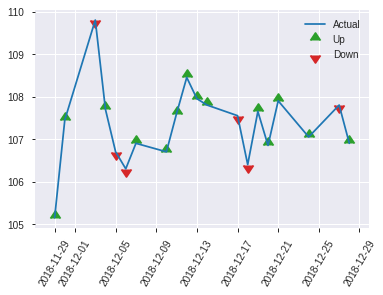


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20766370955181687
RMSE: 0.45570133810623914
LogLoss: 0.6059022806256132
Mean Per-Class Error: 0.30059258315279724
AUC: 0.7360137632216134
pr_auc: 0.68489931804757
Gini: 0.47202752644322676
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2607628107070923: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      35   83   0.7034   (83.0/118.0)
1      4    129  0.0301   (4.0/133.0)
Total  39   212  0.3466   (87.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260763     0.747826  211
max f2                       0.260763     0.866935  211
max f0point5                 0.58171      0.721925  106
max accuracy                 0.518429     0.701195  135
max precision                0.868807     1         0
max recall                   0.140674     1         249
max specificity              0.868807     1         0
max absolute_mcc             0.518429     0.399503  135
max min_per_class_accuracy   0.533617     0.677966  128
max mean_per_class_accuracy  0.518429     0.699407  135

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.829638           1.25815   1.25815            0.666667         0.844627  0.666667                    0.844627            0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.821468           0.629073  0.943609           0.333333         0.825325  0.5                         0.834976            0.0075188       0.0225564                  -37.0927  -5.6391
    3        0.0318725                   0.81576            0.943609  0.943609           0.5              0.818367  0.5                         0.830824            0.0075188       0.0300752                  -5.6391   -5.6391
    4        0.0438247                   0.797538           1.88722   1.20096            1                0.803852  0.636364                    0.823468            0.0225564       0.0526316                  88.7218   20.0957
    5        0.0517928                   0.787427           0.943609  1.16136            0.5              0.794918  0.615385                    0.819076            0.0075188       0.0601504                  -5.6391   16.1365
    6        0.103586                    0.751126           1.30654   1.23395            0.692308         0.76827   0.653846                    0.793673            0.0676692       0.12782                    30.6536   23.395
    7        0.151394                    0.711682           1.41541   1.29125            0.75             0.725648  0.684211                    0.772191            0.0676692       0.195489                   41.5414   29.1254
    8        0.203187                    0.690472           1.74205   1.40616            0.923077         0.698294  0.745098                    0.753355            0.0902256       0.285714                   74.2047   40.6162
    9        0.302789                    0.651678           1.50977   1.44025            0.8              0.670723  0.763158                    0.726173            0.150376        0.43609                    50.9774   44.0245
    10       0.40239                     0.596864           1.43429   1.43877            0.76             0.625045  0.762376                    0.701142            0.142857        0.578947                   43.4286   43.877
    11       0.501992                    0.536527           0.905865  1.33303            0.48             0.565552  0.706349                    0.674239            0.0902256       0.669173                   -9.41353  33.3035
    12       0.601594                    0.492094           0.981353  1.27481            0.52             0.512612  0.675497                    0.647479            0.0977444       0.766917                   -1.86466  27.481
    13       0.701195                    0.416135           0.905865  1.2224             0.48             0.450691  0.647727                    0.619527            0.0902256       0.857143                   -9.41353  22.2403
    14       0.800797                    0.315913           0.754887  1.16425            0.4              0.365163  0.616915                    0.587889            0.075188        0.932331                   -24.5113  16.4254
    15       0.900398                    0.223589           0.377444  1.07722            0.2              0.261231  0.570796                    0.551754            0.037594        0.969925                   -62.2556  7.72174
    16       1                           0.129006           0.301955  1                  0.16             0.176505  0.52988                     0.514379            

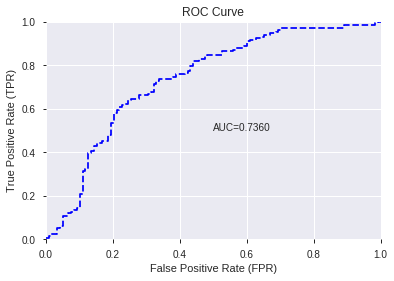

This function is available for GLM models only


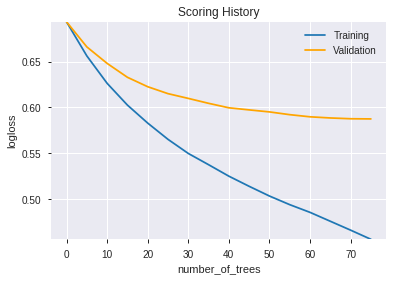

--2019-08-27 14:01:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.60
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.60|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_135944_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_135944_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_140109_model_8  0.693067  0.650926              0.375143  0.475829  0.226413
1  DeepLearning_grid_1_AutoML_20190827_140109_model_9  0.691793  0.650884              0.361954  0.475305  0.225915
2  DeepLearning_grid_1_AutoML_20190827_140109_model_6  0.688862  0.670311              0.394482  0.479302  0.229731
3  DeepLearning_grid_1_AutoML_20190827_140109_model_3  0.665031  0.839421              0.387855  0.507558  0.257615
4               DeepLearning_1_AutoML_20190827_140109  0.657958  0.702874              0.391678  0.489784  0.239888
5  DeepLearning_grid_1_AutoML_20190827_140109_model_4  0.651650  0.886723              0.353001  0.525673  0.276332
6  DeepLearning_grid_1_AutoML_20190827_140109_model_2  0.649930  0.887506              0.371320  0.518399  0.268738
7  DeepLearning_grid_1_AutoML_20190827_140109_model_7  0.644641  0.808992              0.392570  0.520987  0.271427
8  DeepLearning_grid_1_AutoML_20190827_140109_model_1  0.641901  0.999097              0.369472  0.547103  0.299321
9  DeepLearning_grid_1_AutoML_20190827_140109_model_5  0.641328  0.725326              0.404868  0.501047  0.251048

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.031048
1   CDLCLOSINGMARUBOZU             0.945476           0.945476    0.029355
2                  SUB             0.804345           0.804345    0.024974
3        CDLHANGINGMAN             0.745347           0.745347    0.023142
4                  day             0.734981           0.734981    0.022820
5         weekday_name             0.727908           0.727908    0.022600
6           MINUS_DI_8             0.712585           0.712585    0.022125
7                  DIV             0.707246           0.707246    0.021959
8            CORREL_12             0.684707           0.684707    0.021259
9               SAREXT             0.682427           0.682427    0.021188
10       days_in_month             0.679817           0.679817    0.021107
11        CDLSHORTLINE             0.675955           0.675955    0.020987
12             quarter             0.665745           0.665745    0.020670
13                 SIN             0.658717           0.658717    0.020452
14             weekday             0.658568           0.658568    0.020447
15              TRANGE             0.658347           0.658347    0.020441
16           dayofweek             0.651709           0.651709    0.020234
17         CDLLONGLINE             0.650761           0.650761    0.020205
18           aroonup_8             0.647546           0.647546    0.020105
19      STOCHRSI_fastk             0.644187           0.644187    0.020001
20         STOCH_slowd             0.636582           0.636582    0.019765
21             CDLDOJI             0.632806           0.632806    0.019648
22            CORREL_8             0.631364           0.631364    0.019603
23        aroondown_14             0.628382           0.628382    0.019510
24         aroondown_8             0.622997           0.622997    0.019343
25        STOCHF_fastk             0.619918           0.619918    0.019247
26              VAR_20             0.616668           0.616668    0.019147
27        HT_TRENDMODE             0.613467           0.613467    0.019047
28           CDLHAMMER             0.613390           0.613390    0.019045
29              ROCR_8             0.605802           0.605802    0.018809
30         CDLMARUBOZU             0.605397           0.605397    0.018797
31             WILLR_8             0.603477           0.603477    0.018737
32      CDLRICKSHAWMAN             0.603448           0.603448    0.018736
33               ROC_8             0.602500           0.602500    0.018707
34               ADOSC             0.602499           0.602499    0.018707
35            WILLR_12             0.594915           0.594915    0.018471
36          AROONOSC_8             0.594561           0.594561    0.018460
37   CDLLONGLEGGEDDOJI             0.592811           0.592811    0.018406
38    CDLDRAGONFLYDOJI             0.589053           0.589053    0.018289
39           CORREL_14             0.588773           0.588773    0.018280
40      CDLMORNINGSTAR             0.588234           0.588234    0.018264
41              ULTOSC             0.586216           0.586216    0.018201
42           CDLTAKURI             0.582168           0.582168    0.018075
43         CDLBELTHOLD             0.577823           0.577823    0.017940
44               MOM_8             0.577261           0.577261    0.017923
45            WILLR_20             0.564579           0.564579    0.017529
46            WILLR_14             0.562214           0.562214    0.017456
47        is_month_end             0.549191           0.549191    0.017051
48        CDLTHRUSTING             0.548395           0.548395    0.017027
49        CDLENGULFING             0.536554           0.536554    0.016659

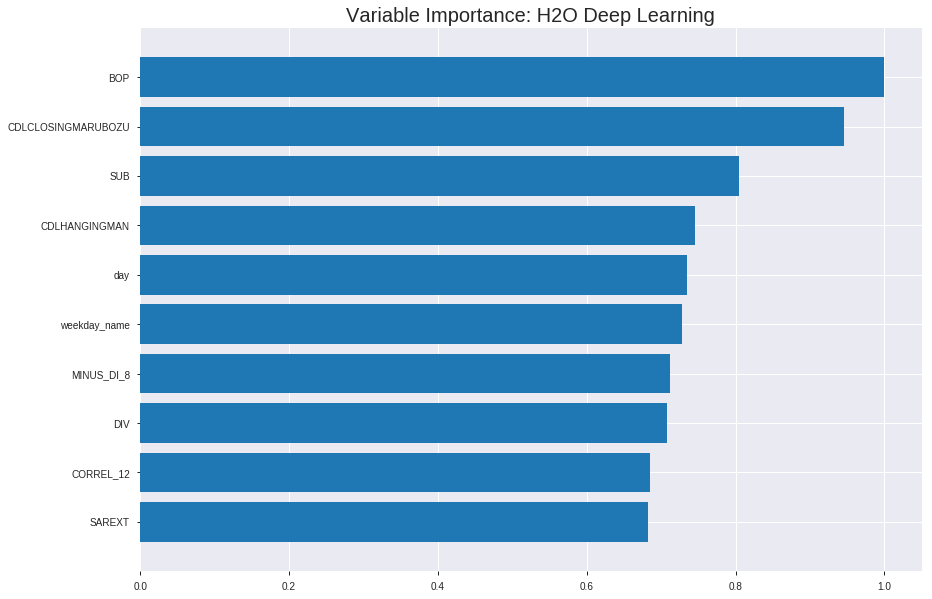

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_140109_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.204873407860857
RMSE: 0.4526294376870079
LogLoss: 0.5947992705249299
Mean Per-Class Error: 0.3179065122896787
AUC: 0.7476849978462061
pr_auc: 0.7545557779687533
Gini: 0.49536999569241225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42428888350251354: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      332  498   0.6      (498.0/830.0)
1      96   827   0.104    (96.0/923.0)
Total  428  1325  0.3388   (594.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424289     0.735765  265
max f2                       0.219087     0.859962  351
max f0point5                 0.541926     0.700434  182
max accuracy                 0.52333      0.685682  204
max precision                0.951819     1         0
max recall                   0.11807      1         390
max specificity              0.951819     1         0
max absolute_mcc             0.52333      0.368099  204
max min_per_class_accuracy   0.529385     0.679518  196
max mean_per_class_accuracy  0.52333      0.682093  204

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.884459           1.68821   1.68821            0.888889         0.912314  0.888889                    0.912314            0.0173348       0.0173348                  68.8215   68.8215
    2        0.0205362                   0.861634           1.89924   1.79373            1                0.872097  0.944444                    0.892205            0.0195016       0.0368364                  89.9242   79.3728
    3        0.0302339                   0.848257           1.6758    1.7559             0.882353         0.854839  0.924528                    0.88022             0.0162514       0.0530878                  67.5801   75.5903
    4        0.040502                    0.833934           1.47719   1.68524            0.777778         0.841106  0.887324                    0.870304            0.0151679       0.0682557                  47.7188   68.5243
    5        0.0501997                   0.821629           1.78752   1.705              0.941176         0.828097  0.897727                    0.86215             0.0173348       0.0855905                  78.7522   70.5001
    6        0.100399                    0.759126           1.61867   1.66184            0.852273         0.790226  0.875                       0.826188            0.0812568       0.166847                   61.8672   66.1836
    7        0.150029                    0.704609           1.61545   1.64649            0.850575         0.731382  0.86692                     0.794826            0.0801733       0.247021                   61.5447   64.6491
    8        0.200228                    0.649638           1.23019   1.54212            0.647727         0.675656  0.811966                    0.764949            0.0617551       0.308776                   23.0191   54.2119
    9        0.300057                    0.59054            1.29148   1.45873            0.68             0.619351  0.768061                    0.716508            0.128927        0.437703                   29.1484   45.8733
    10       0.399886                    0.549984           1.22637   1.40072            0.645714         0.568453  0.737518                    0.679547            0.122427        0.56013                    22.6367   40.0725
    11       0.500285                    0.529964           1.1007    1.34051            0.579545         0.537388  0.705815                    0.651018            0.110509        0.670639                   10.0697   34.0514
    12       0.600114                    0.516299           0.955047  1.27639            0.502857         0.525039  0.672053                    0.630062            0.0953413       0.76598                    -4.49528  27.6391
    13       0.699943                    0.469201           0.835666  1.21353            0.44             0.495499  0.638957                    0.61087             0.0834236       0.849404                   -16.4334  21.3533
    14       0.799772                    0.37718            0.716285  1.15147            0.377143         0.428182  0.606277                    0.588066            0.071506        0.92091                    -28.3715  15.1466
    15       0.899601                    0.260293           0.54264   1.0839             0.285714         0.323159  0.570704                    0.55867             0.0541712       0.975081                   -45.736   8.39045
    16       1                           0.0655824          0.248196  1                  0.130682         0.185229  0.526526                    0.521176         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21150558229314562
RMSE: 0.4598973606068485
LogLoss: 0.6088935640038423
Mean Per-Class Error: 0.32076690051020407
AUC: 0.7288663903061224
pr_auc: 0.7375914354460584
Gini: 0.45773278061224487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45753837248201096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  142  0.5796   (142.0/245.0)
1      39   217  0.1523   (39.0/256.0)
Total  142  359  0.3613   (181.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457538     0.705691  275
max f2                       0.21315      0.851135  373
max f0point5                 0.533251     0.688944  196
max accuracy                 0.533251     0.678643  196
max precision                0.940092     1         0
max recall                   0.175963     1         382
max specificity              0.940092     1         0
max absolute_mcc             0.533251     0.358758  196
max min_per_class_accuracy   0.529833     0.673469  203
max mean_per_class_accuracy  0.533251     0.679233  196

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.884769           1.63086   1.63086            0.833333         0.908133  0.833333                    0.908133            0.0195312       0.0195312                  63.0859   63.0859
    2        0.0219561                   0.864954           1.56563   1.60121            0.8              0.873282  0.818182                    0.892292            0.015625        0.0351562                  56.5625   60.1207
    3        0.0319361                   0.850634           1.95703   1.7124             1                0.856158  0.875                       0.881               0.0195312       0.0546875                  95.7031   71.2402
    4        0.0419162                   0.838947           1.95703   1.77065            1                0.843569  0.904762                    0.872088            0.0195312       0.0742188                  95.7031   77.0647
    5        0.0518962                   0.823455           1.95703   1.80649            1                0.828173  0.923077                    0.863643            0.0195312       0.09375                    95.7031   80.649
    6        0.101796                    0.745986           1.72219   1.76517            0.88             0.78398   0.901961                    0.824593            0.0859375       0.179688                   72.2188   76.5165
    7        0.151697                    0.681428           1.64391   1.72528            0.84             0.716221  0.881579                    0.788944            0.0820312       0.261719                   64.3906   72.5278
    8        0.201597                    0.627332           1.2525    1.60825            0.64             0.647873  0.821782                    0.754026            0.0625          0.324219                   25.25     60.8253
    9        0.301397                    0.571331           1.17422   1.46453            0.6              0.597052  0.748344                    0.702047            0.117188        0.441406                   17.4219   46.4533
    10       0.401198                    0.546944           1.0568    1.36311            0.54             0.558441  0.696517                    0.666325            0.105469        0.546875                   5.67969   36.3106
    11       0.500998                    0.529947           1.2525    1.34107            0.64             0.536138  0.685259                    0.640391            0.125           0.671875                   25.25     34.1073
    12       0.600798                    0.516567           0.821953  1.25484            0.42             0.52404   0.641196                    0.621064            0.0820312       0.753906                   -17.8047  25.4841
    13       0.700599                    0.464011           0.782813  1.1876             0.4              0.491357  0.606838                    0.602587            0.078125        0.832031                   -21.7187  18.76
    14       0.800399                    0.366832           0.587109  1.11273            0.3              0.417668  0.568579                    0.57953             0.0585938       0.890625                   -41.2891  11.2726
    15       0.9002                      0.271698           0.743672  1.07181            0.38             0.320925  0.547672                    0.550859            0.0742188       0.964844                   -25.6328  7.18109
    16       1                           0.0609056          0.352266  1                  0.18             0.19326   0.510978                    0.515171            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:07:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:07:12  1 min 26.342 sec  547 obs/sec       0.490017  1             859        0.535185         0.839662            -0.148924      0.697972        0.70053            1.79373          0.378209                         0.540379           0.838974              -0.168603        0.70047           0.692512             1.95703            0.419162
    2019-08-27 14:07:24  1 min 38.519 sec  903 obs/sec       6.51226   13            11416      0.452629         0.594799            0.178193       0.747685        0.754556           1.68821          0.338848                         0.459897           0.608894              0.15357          0.728866          0.737591             1.63086            0.361277
    2019-08-27 14:07:36  1 min 50.317 sec  1017 obs/sec      13.5299   27            23718      0.445857         0.580303            0.202603       0.765759        0.770305           1.68821          0.317741                         0.464509           0.622577              0.13651          0.723493          0.737383             1.63086            0.355289
    2019-08-27 14:07:48  2 min  2.096 sec  1088 obs/sec      21.0993   42            36987      0.439152         0.56484             0.226404       0.782283        0.784925           1.68821          0.312037                         0.463973           0.621459              0.138502         0.727144          0.736123             1.63086            0.357285
    2019-08-27 14:07:59  2 min 13.753 sec  1147 obs/sec      29.1546   58            51108      0.438488         0.563467            0.228743       0.797526        0.80322            1.79373          0.292641                         0.478091           0.678013              0.0852765        0.724761          0.732445             1.95703            0.329341
    2019-08-27 14:08:11  2 min 25.109 sec  1187 obs/sec      37.1363   74            65100      0.420474         0.521269            0.290812       0.814278        0.823016           1.79373          0.281803                         0.472659           0.666252              0.105944         0.7228            0.706102             1.30469            0.337325
    2019-08-27 14:08:22  2 min 36.116 sec  1223 obs/sec      45.1426   90            79135      0.404614         0.487495            0.343302       0.835975        0.835681           1.79373          0.260696                         0.468752           0.6459                0.120661         0.735308          0.739229             1.63086            0.331337
    2019-08-27 14:08:23  2 min 37.245 sec  1222 obs/sec      45.1426   90            79135      0.452629         0.594799            0.178193       0.747685        0.754556           1.68821          0.338848                         0.459897           0.608894              0.15357          0.728866          0.737591             1.63086            0.361277

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.031048363811711527
CDLCLOSINGMARUBOZU  0.9454755187034607     0.9454755187034607   0.029355467879771713
SUB                 0.8043449521064758     0.8043449521064758   0.024973594703115543
CDLHANGINGMAN       0.7453474402427673     0.7453474402427673   0.023141818490785355
day                 0.7349808812141418     0.7349808812141418   0.02281995379458901
---                 ---                    ---                  ---
WILLR_20            0.564578652381897      0.564578652381897    0.01752924339947895
WILLR_14            0.562213659286499      0.562213659286499    0.01745581423344085
is_month_end        0.5491905212402344     0.5491905212402344   0.017051467105410282
CDLTHRUSTING        0.5483946800231934     0.5483946800231934   0.017026757537767237
CDLENGULFING        0.5365539193153381     0.5365539193153381   0.01665912129150233


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7272727272727273)

('auc', 0.6930674142984581)

('logloss', 0.6509256555349067)

('mean_per_class_error', 0.32744998088441446)

('rmse', 0.4758285469538583)

('mse', 0.2264128060962201)

deeplearning prediction progress: |███████████████████████████████████████| 100%


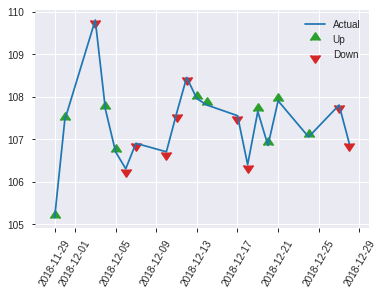


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2264128060962201
RMSE: 0.4758285469538583
LogLoss: 0.6509256555349067
Mean Per-Class Error: 0.32744998088441446
AUC: 0.6930674142984581
pr_auc: 0.6574432867338036
Gini: 0.38613482859691617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.381379426219914: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   77   0.6525   (77.0/118.0)
1      13   120  0.0977   (13.0/133.0)
Total  54   197  0.3586   (90.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381379     0.727273  196
max f2                       0.166121     0.851613  242
max f0point5                 0.516194     0.689655  147
max accuracy                 0.516194     0.677291  147
max precision                0.86044      0.75      3
max recall                   0.086847     1         250
max specificity              0.939378     0.991525  0
max absolute_mcc             0.516194     0.350157  147
max min_per_class_accuracy   0.525381     0.654135  125
max mean_per_class_accuracy  0.516194     0.67255   147

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 51.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.861742           1.25815   1.25815            0.666667         0.888956  0.666667                    0.888956            0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.855853           1.25815   1.25815            0.666667         0.858166  0.666667                    0.873561            0.0150376       0.0300752                  25.8145   25.8145
    3        0.0318725                   0.847061           0.943609  1.17951            0.5              0.84759   0.625                       0.867068            0.0075188       0.037594                   -5.6391   17.9511
    4        0.0438247                   0.84432            0.629073  1.02939            0.333333         0.845181  0.545455                    0.861099            0.0075188       0.0451128                  -37.0927  2.93917
    5        0.0517928                   0.832147           0.943609  1.01619            0.5              0.834848  0.538462                    0.85706             0.0075188       0.0526316                  -5.6391   1.61943
    6        0.103586                    0.760183           1.45171   1.23395            0.769231         0.79303   0.653846                    0.825045            0.075188        0.12782                    45.1706   23.395
    7        0.151394                    0.715724           1.41541   1.29125            0.75             0.737493  0.684211                    0.797397            0.0676692       0.195489                   41.5414   29.1254
    8        0.203187                    0.629284           1.45171   1.33215            0.769231         0.665214  0.705882                    0.763703            0.075188        0.270677                   45.1706   33.2154
    9        0.302789                    0.567455           1.3588    1.34092            0.72             0.592406  0.710526                    0.707356            0.135338        0.406015                   35.8797   34.0918
    10       0.40239                     0.53545            1.05684   1.2706             0.56             0.550535  0.673267                    0.668539            0.105263        0.511278                   5.68421   27.0602
    11       0.501992                    0.525381           1.43429   1.30308            0.76             0.530831  0.690476                    0.641216            0.142857        0.654135                   43.4286   30.3079
    12       0.601594                    0.508709           0.981353  1.24981            0.52             0.521293  0.662252                    0.621361            0.0977444       0.75188                    -1.86466  24.9813
    13       0.701195                    0.454131           0.830376  1.19023            0.44             0.483311  0.630682                    0.601752            0.0827068       0.834586                   -16.9624  19.0234
    14       0.800797                    0.372052           0.754887  1.13609            0.4              0.413743  0.60199                     0.578367            0.075188        0.909774                   -24.5113  13.6086
    15       0.900398                    0.27779            0.528421  1.06887            0.28             0.327108  0.566372                    0.550573            0.0526316       0.962406                   -47.1579  6.88669
    16       1                           0.086847           0.377444  1                  0.2              0.19256   0.52988                     0.514915          

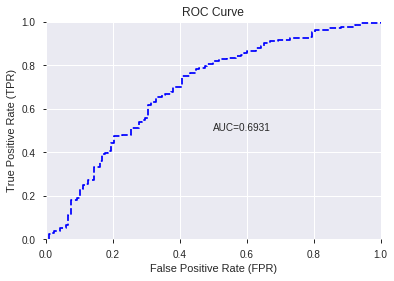

This function is available for GLM models only


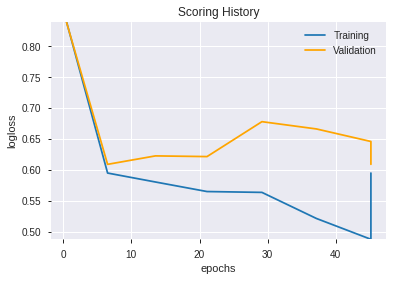

--2019-08-27 14:09:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_140109_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_140109_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLHANGINGMAN',
 'day',
 'weekday_name',
 'MINUS_DI_8',
 'DIV',
 'CORREL_12',
 'SAREXT',
 'days_in_month',
 'CDLSHORTLINE',
 'quarter',
 'SIN',
 'weekday',
 'TRANGE',
 'dayofweek',
 'CDLLONGLINE',
 'aroonup_8',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'CDLDOJI',
 'CORREL_8',
 'aroondown_14',
 'aroondown_8',
 'STOCHF_fastk',
 'VAR_20',
 'HT_TRENDMODE',
 'CDLHAMMER',
 'ROCR_8',
 'CDLMARUBOZU',
 'WILLR_8',
 'CDLRICKSHAWMAN',
 'ROC_8',
 'ADOSC',
 'WILLR_12',
 'AROONOSC_8',
 'CDLLONGLEGGEDDOJI',
 'CDLDRAGONFLYDOJI',
 'CORREL_14',
 'CDLMORNINGSTAR',
 'ULTOSC',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'MOM_8',
 'WILLR_20',
 'WILLR_14',
 'is_month_end',
 'CDLTHRUSTING',
 'CDLENGULFING']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_140949_model_1  0.690646  0.643532               0.33414  0.472655  0.223402

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.480068           1.000000    0.101276
1   CDLCLOSINGMARUBOZU             0.271093           0.564697    0.057190
2           MINUS_DI_8             0.261476           0.544665    0.055161
3                  SUB             0.258436           0.538332    0.054520
4            CORREL_12             0.205572           0.428215    0.043368
5             WILLR_14             0.170337           0.354819    0.035935
6              WILLR_8             0.150837           0.314200    0.031821
7          STOCH_slowd             0.140838           0.293371    0.029711
8             WILLR_20             0.139706           0.291012    0.029473
9        CDLHANGINGMAN             0.132075           0.275117    0.027863
10                 day             0.128168           0.266980    0.027039
11      CDLRICKSHAWMAN             0.113577           0.236586    0.023960
12              ULTOSC             0.112659           0.234673    0.023767
13           CDLHAMMER             0.108535           0.226083    0.022897
14       days_in_month             0.108501           0.226012    0.022890
15        aroondown_14             0.104706           0.218107    0.022089
16      STOCHRSI_fastk             0.103458           0.215508    0.021826
17           aroonup_8             0.101513           0.211455    0.021415
18               MOM_8             0.099422           0.207101    0.020974
19              VAR_20             0.098721           0.205640    0.020826
20           CORREL_14             0.095730           0.199409    0.020195
21        weekday_name             0.094098           0.196009    0.019851
22              ROCR_8             0.093725           0.195234    0.019772
23               ROC_8             0.093626           0.195026    0.019751
24         CDLLONGLINE             0.093049           0.193825    0.019630
25          AROONOSC_8             0.079370           0.165330    0.016744
26                 DIV             0.075382           0.157023    0.015903
27        CDLTHRUSTING             0.066954           0.139467    0.014125
28              SAREXT             0.066343           0.138195    0.013996
29         CDLMARUBOZU             0.059916           0.124807    0.012640
30        CDLSHORTLINE             0.056411           0.117507    0.011901
31              TRANGE             0.048916           0.101894    0.010319
32   CDLLONGLEGGEDDOJI             0.048909           0.101879    0.010318
33         CDLBELTHOLD             0.041576           0.086605    0.008771
34           CDLTAKURI             0.041310           0.086050    0.008715
35    CDLDRAGONFLYDOJI             0.041229           0.085883    0.008698
36         aroondown_8             0.037711           0.078553    0.007956
37               ADOSC             0.036410           0.075843    0.007681
38            WILLR_12             0.031500           0.065616    0.006645
39        CDLENGULFING             0.027561           0.057410    0.005814
40        is_month_end             0.025777           0.053694    0.005438
41        STOCHF_fastk             0.025637           0.053402    0.005408
42      CDLMORNINGSTAR             0.025285           0.052670    0.005334
43             quarter             0.023735           0.049441    0.005007
44           dayofweek             0.023474           0.048897    0.004952
45             weekday             0.023175           0.048275    0.004889
46            CORREL_8             0.022550           0.046972    0.004757
47                 SIN             0.022170           0.046181    0.004677
48        HT_TRENDMODE             0.020848           0.043427    0.004398
49             CDLDOJI             0.008120           0.016915    0.001713

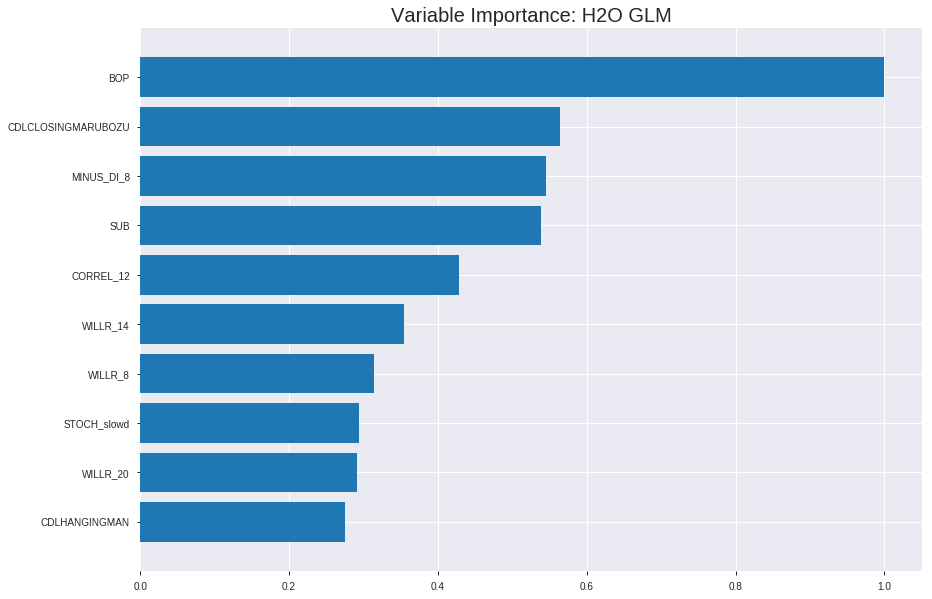

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_140949_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20197540514581305
RMSE: 0.44941673883580824
LogLoss: 0.589161473125286
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2425.2378703291097
Residual deviance: 2065.600124777253
AIC: 2167.600124777253
AUC: 0.7513510161991411
pr_auc: 0.7530389178569667
Gini: 0.5027020323982823
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37482234718759155: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      349  481   0.5795   (481.0/830.0)
1      94   829   0.1018   (94.0/923.0)
Total  443  1310  0.328    (575.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374822     0.742499  276
max f2                       0.119777     0.853997  379
max f0point5                 0.553186     0.70956   186
max accuracy                 0.496114     0.691386  216
max precision                0.964657     1         0
max recall                   0.119777     1         379
max specificity              0.964657     1         0
max absolute_mcc             0.553186     0.380614  186
max min_per_class_accuracy   0.54516      0.684337  191
max mean_per_class_accuracy  0.553186     0.690559  186

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.886515           1.5827    1.5827             0.833333         0.909065  0.833333                    0.909065            0.0162514       0.0162514                  58.2701   58.2701
    2        0.0205362                   0.868331           1.68821   1.63546            0.888889         0.875923  0.861111                    0.892494            0.0173348       0.0335861                  68.8215   63.5458
    3        0.0302339                   0.853573           1.78752   1.68423            0.941176         0.861664  0.886792                    0.882605            0.0173348       0.0509209                  78.7522   68.4233
    4        0.040502                    0.842255           1.68821   1.68524            0.888889         0.847505  0.887324                    0.873706            0.0173348       0.0682557                  68.8215   68.5243
    5        0.0501997                   0.829959           1.6758    1.68342            0.882353         0.83719   0.886364                    0.866652            0.0162514       0.084507                   67.5801   68.3419
    6        0.100399                    0.787057           1.61867   1.65105            0.852273         0.808968  0.869318                    0.83781             0.0812568       0.165764                   61.8672   65.1045
    7        0.150029                    0.747793           1.48446   1.59594            0.781609         0.766974  0.840304                    0.814378            0.0736728       0.239437                   48.4465   59.5941
    8        0.200228                    0.716326           1.31652   1.52589            0.693182         0.731722  0.803419                    0.793655            0.0660888       0.305525                   31.652    52.5886
    9        0.300057                    0.665973           1.34575   1.46595            0.708571         0.689708  0.771863                    0.759072            0.134345        0.43987                    34.5748   46.5955
    10       0.399886                    0.604912           1.20466   1.40072            0.634286         0.638192  0.737518                    0.728895            0.12026         0.56013                    20.4662   40.0725
    11       0.500285                    0.547894           1.17623   1.35567            0.619318         0.577426  0.713797                    0.698497            0.118093        0.678223                   17.6235   35.5673
    12       0.600114                    0.483834           0.944194  1.28722            0.497143         0.516421  0.677757                    0.668209            0.0942579       0.772481                   -5.58056  28.7224
    13       0.699943                    0.413359           0.835666  1.22282            0.44             0.450722  0.643847                    0.63719             0.0834236       0.855905                   -16.4334  22.2821
    14       0.799772                    0.329989           0.716285  1.15959            0.377143         0.369932  0.610556                    0.603831            0.071506        0.927411                   -28.3715  15.9594
    15       0.899601                    0.222122           0.401554  1.07547            0.211429         0.281875  0.566265                    0.568103            0.0400867       0.967497                   -59.8446  7.54742
    16       1                           0.0133558          0.323734  1                  0.170455         0.153985  0.526526                    0.526526         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2057728919161099
RMSE: 0.45362197027493045
LogLoss: 0.5939811690963668
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.7772912382
Residual deviance: 595.1691314345595
AIC: 697.1691314345595
AUC: 0.7412866709183673
pr_auc: 0.7574176798841538
Gini: 0.4825733418367346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4029964924163015: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  136  0.5551   (136.0/245.0)
1      36   220  0.1406   (36.0/256.0)
Total  145  356  0.3433   (172.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402996     0.718954  276
max f2                       0.220903     0.858008  363
max f0point5                 0.657047     0.686047  120
max accuracy                 0.523075     0.676647  216
max precision                0.937329     1         0
max recall                   0.186626     1         374
max specificity              0.937329     1         0
max absolute_mcc             0.657047     0.355404  120
max min_per_class_accuracy   0.55699      0.669388  194
max mean_per_class_accuracy  0.523075     0.675351  216

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.89786            1.95703   1.95703            1                0.922252  1                           0.922252            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.886917           1.56563   1.77912            0.8              0.890373  0.909091                    0.907761            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.879392           1.95703   1.83472            1                0.882458  0.9375                      0.899854            0.0195312       0.0585938                  95.7031   83.4717
    4        0.0419162                   0.843641           1.95703   1.86384            1                0.85377   0.952381                    0.888882            0.0195312       0.078125                   95.7031   86.3839
    5        0.0518962                   0.834369           1.95703   1.88176            1                0.840021  0.961538                    0.879485            0.0195312       0.0976562                  95.7031   88.1761
    6        0.101796                    0.788199           1.95703   1.91866            1                0.807005  0.980392                    0.843956            0.0976562       0.195312                   95.7031   91.8658
    7        0.151697                    0.749541           1.17422   1.67378            0.6              0.767971  0.855263                    0.818961            0.0585938       0.253906                   17.4219   67.3777
    8        0.201597                    0.718902           1.2525    1.5695             0.64             0.735094  0.80198                     0.798202            0.0625          0.316406                   25.25     56.95
    9        0.301397                    0.657047           1.4482    1.52934            0.74             0.688596  0.781457                    0.761908            0.144531        0.460938                   44.8203   52.9336
    10       0.401198                    0.606895           0.978516  1.39232            0.5              0.631961  0.711443                    0.729583            0.0976562       0.558594                   -2.14844  39.2316
    11       0.500998                    0.5591             1.0568    1.32548            0.54             0.58208   0.677291                    0.7002              0.105469        0.664062                   5.67969   32.5479
    12       0.600798                    0.487835           0.900234  1.25484            0.46             0.527268  0.641196                    0.671474            0.0898438       0.753906                   -9.97656  25.4841
    13       0.700599                    0.406837           0.900234  1.20433            0.46             0.44784   0.615385                    0.639617            0.0898438       0.84375                    -9.97656  20.4327
    14       0.800399                    0.338902           0.62625   1.13225            0.32             0.373021  0.578554                    0.606376            0.0625          0.90625                    -37.375   13.2248
    15       0.9002                      0.239409           0.704531  1.08483            0.36             0.29008   0.554324                    0.57131             0.0703125       0.976562                   -29.5469  8.48289
    16       1                           0.0262877          0.234844  1                  0.12             0.174353  0.510978                    0.531693           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:09:50  0.000 sec   2            .17E2     49            1.3660108979677104  1.369983406407556
     2019-08-27 14:09:50  0.018 sec   4            .11E2     51            1.3573940858110625  1.361563702716995
     2019-08-27 14:09:50  0.040 sec   6            .66E1     51            1.3456995927879827  1.3499873937728784
     2019-08-27 14:09:50  0.055 sec   8            .41E1     51            1.3307172261280393  1.334895168350799
     2019-08-27 14:09:50  0.074 sec   10           .25E1     51            1.312647834234549   1.3163409278920506
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:09:50  0.247 sec   34           .84E-2    51            1.1766109067563708  1.1885548340822285
     2019-08-27 14:09:50  0.262 sec   36           .52E-2    51            1.1754597755555272  1.1896375194067401
     2019-08-27 14:09:50  0.276 sec   38           .32E-2    51            1.1746762948526905  1.1909499453301047
     2019-08-27 14:09:50  0.290 sec   40           .2E-2     51            1.1741448225368432  1.1923137934852819
     2019-08-27 14:09:50  0.298 sec   41           .12E-2    51            1.1737944553914925  1.1935864351526944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7378640776699029)

('auc', 0.6906461067924047)

('logloss', 0.6435317321238309)

('mean_per_class_error', 0.3292341022046642)

('rmse', 0.47265467177614545)

('mse', 0.2234024387518158)

glm prediction progress: |████████████████████████████████████████████████| 100%


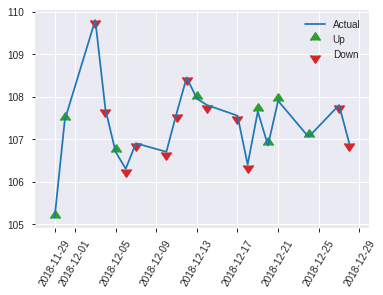


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2234024387518158
RMSE: 0.47265467177614545
LogLoss: 0.6435317321238309
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.07426846610866
Residual deviance: 323.0529295261631
AIC: 425.0529295261631
AUC: 0.6906461067924047
pr_auc: 0.6532572450427905
Gini: 0.38129221358480936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40643087089034585: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   62   0.5254   (62.0/118.0)
1      19   114  0.1429   (19.0/133.0)
Total  75   176  0.3227   (81.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406431     0.737864  175
max f2                       0.116139     0.851613  242
max f0point5                 0.537987     0.692432  121
max accuracy                 0.406431     0.677291  175
max precision                0.918482     1         0
max recall                   0.0655845    1         249
max specificity              0.918482     1         0
max absolute_mcc             0.406431     0.361702  175
max min_per_class_accuracy   0.537987     0.646617  121
max mean_per_class_accuracy  0.537987     0.670766  121

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.880088           1.25815   1.25815            0.666667         0.901326  0.666667                    0.901326            0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.867255           0.629073  0.943609           0.333333         0.868682  0.5                         0.885004            0.0075188       0.0225564                  -37.0927  -5.6391
    3        0.0318725                   0.856576           0.943609  0.943609           0.5              0.861226  0.5                         0.879059            0.0075188       0.0300752                  -5.6391   -5.6391
    4        0.0438247                   0.834509           1.25815   1.02939            0.666667         0.845132  0.545455                    0.869806            0.0150376       0.0451128                  25.8145   2.93917
    5        0.0517928                   0.825474           1.88722   1.16136            1                0.829713  0.615385                    0.863638            0.0150376       0.0601504                  88.7218   16.1365
    6        0.103586                    0.784464           1.30654   1.23395            0.692308         0.807644  0.653846                    0.835641            0.0676692       0.12782                    30.6536   23.395
    7        0.151394                    0.744124           1.72995   1.39058            0.916667         0.772935  0.736842                    0.815839            0.0827068       0.210526                   72.995    39.0582
    8        0.203187                    0.706823           0.871024  1.25815            0.461538         0.725717  0.666667                    0.792867            0.0451128       0.255639                   -12.8976  25.8145
    9        0.302789                    0.654811           1.3588    1.29125            0.72             0.676212  0.684211                    0.754493            0.135338        0.390977                   35.8797   29.1254
    10       0.40239                     0.587837           1.43429   1.32666            0.76             0.621792  0.70297                     0.721647            0.142857        0.533835                   43.4286   32.6658
    11       0.501992                    0.523379           1.13233   1.2881             0.6              0.554007  0.68254                     0.688385            0.112782        0.646617                   13.2331   28.8101
    12       0.601594                    0.473416           0.905865  1.22482            0.48             0.493962  0.649007                    0.656196            0.0902256       0.736842                   -9.41353  22.4817
    13       0.701195                    0.406431           1.20782   1.2224             0.64             0.436103  0.647727                    0.624932            0.120301        0.857143                   20.782    22.2403
    14       0.800797                    0.339479           0.452932  1.1267             0.24             0.370511  0.597015                    0.593288            0.0451128       0.902256                   -54.7068  12.6697
    15       0.900398                    0.241853           0.452932  1.05217            0.24             0.287809  0.557522                    0.559496            0.0451128       0.947368                   -54.7068  5.21658
    16       1                           0.0570058          0.528421  1                  0.28             0.151547  0.52988                     0.518864          

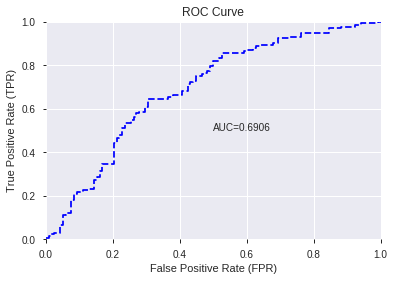

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


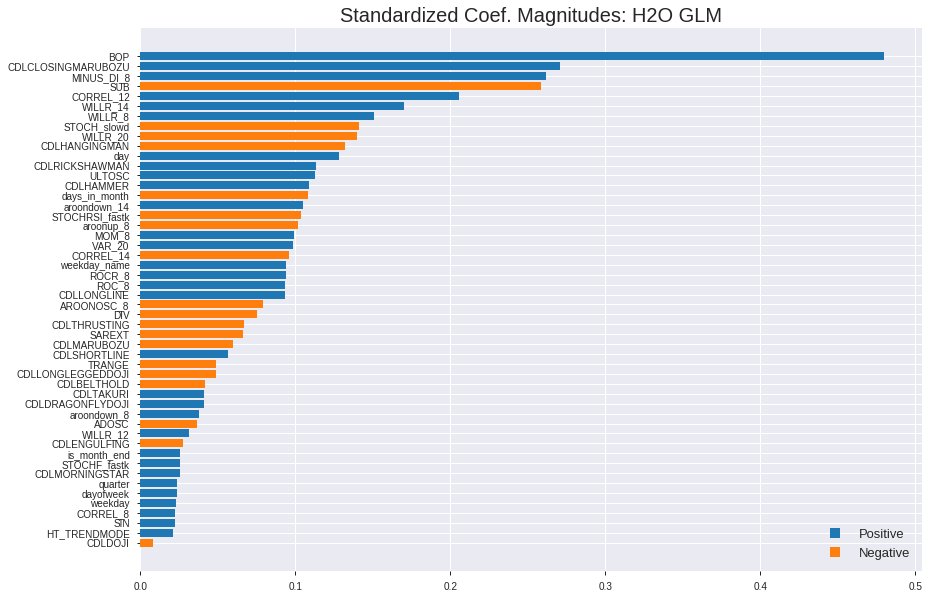

'log_likelihood'
--2019-08-27 14:09:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_140949_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_140949_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'MINUS_DI_8',
 'SUB',
 'CORREL_12',
 'WILLR_14',
 'WILLR_8',
 'STOCH_slowd',
 'WILLR_20',
 'CDLHANGINGMAN',
 'day',
 'CDLRICKSHAWMAN',
 'ULTOSC',
 'CDLHAMMER',
 'days_in_month',
 'aroondown_14',
 'STOCHRSI_fastk',
 'aroonup_8',
 'MOM_8',
 'VAR_20',
 'CORREL_14',
 'weekday_name',
 'ROCR_8',
 'ROC_8',
 'CDLLONGLINE',
 'AROONOSC_8',
 'DIV',
 'CDLTHRUSTING',
 'SAREXT',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLLONGLEGGEDDOJI',
 'CDLBELTHOLD',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'aroondown_8',
 'ADOSC',
 'WILLR_12',
 'CDLENGULFING',
 'is_month_end',
 'STOCHF_fastk',
 'CDLMORNINGSTAR',
 'quarter',
 'dayofweek',
 'weekday',
 'CORREL_8',
 'SIN',
 'HT_TRENDMODE',
 'CDLDOJI']

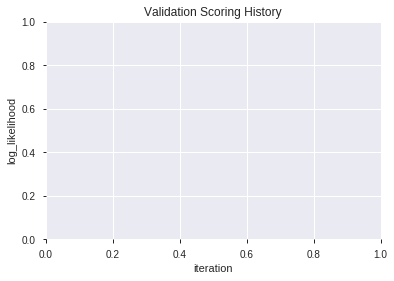

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_141001  0.735122  0.608259              0.333248  0.456156  0.208078
1  XGBoost_grid_1_AutoML_20190827_141001_model_4  0.732764  0.608068              0.311042  0.457348  0.209167
2  XGBoost_grid_1_AutoML_20190827_141001_model_2  0.731872  0.609212              0.348828  0.457616  0.209412
3  XGBoost_grid_1_AutoML_20190827_141001_model_6  0.728431  0.616702              0.358672  0.460641  0.212190
4  XGBoost_grid_1_AutoML_20190827_141001_model_3  0.726583  0.620873              0.349720  0.461250  0.212752
5               XGBoost_3_AutoML_20190827_141001  0.721932  0.621147              0.355391  0.462265  0.213689
6               XGBoost_2_AutoML_20190827_141001  0.716707  0.624185              0.353479  0.464118  0.215405
7  XGBoost_grid_1_AutoML_20190827_141001_model_5  0.715050  0.624399              0.354913  0.463741  0.215055
8  XGBoost_grid_1_AutoML_20190827_141001_model_7  0.707595  0.633095              0.318083  0.467692  0.218736
9  XGBoost_grid_1_AutoML_20190827_141001_model_1  0.704346  0.632036              0.339334  0.467176  0.218253

variable  relative_importance  scaled_importance  percentage
0                  BOP          1551.175171           1.000000    0.175096
1         STOCHF_fastk           536.288452           0.345730    0.060536
2              WILLR_8           369.469116           0.238187    0.041705
3                  SUB           360.048950           0.232114    0.040642
4                  SIN           345.398834           0.222669    0.038988
5            CORREL_12           335.034393           0.215987    0.037819
6             CORREL_8           322.112244           0.207657    0.036360
7           MINUS_DI_8           312.854950           0.201689    0.035315
8          STOCH_slowd           306.457367           0.197565    0.034593
9            CORREL_14           302.349609           0.194916    0.034129
10                 DIV           284.569580           0.183454    0.032122
11              TRANGE           283.609711           0.182835    0.032014
12              VAR_20           251.289368           0.161999    0.028365
13              SAREXT           233.085022           0.150264    0.026311
14               ROC_8           229.526337           0.147969    0.025909
15               ADOSC           219.214249           0.141321    0.024745
16               MOM_8           216.306580           0.139447    0.024417
17  CDLCLOSINGMARUBOZU           214.659332           0.138385    0.024231
18                 day           212.157074           0.136772    0.023948
19            WILLR_20           209.971024           0.135363    0.023701
20      STOCHRSI_fastk           208.973770           0.134720    0.023589
21            WILLR_14           200.909805           0.129521    0.022679
22          AROONOSC_8           188.923920           0.121794    0.021326
23              ULTOSC           184.097748           0.118683    0.020781
24           aroonup_8           147.787964           0.095275    0.016682
25            WILLR_12           140.711624           0.090713    0.015883
26        aroondown_14           137.980911           0.088953    0.015575
27           dayofweek            99.391914           0.064075    0.011219
28        weekday_name            88.898941           0.057311    0.010035
29       days_in_month            71.678391           0.046209    0.008091
30         aroondown_8            67.856270           0.043745    0.007660
31             quarter            58.453892           0.037684    0.006598
32              ROCR_8            44.750229           0.028849    0.005051
33             weekday            37.349300           0.024078    0.004216
34        HT_TRENDMODE            35.310413           0.022764    0.003986
35         CDLLONGLINE            15.723479           0.010136    0.001775
36         CDLBELTHOLD            11.171500           0.007202    0.001261
37      CDLRICKSHAWMAN             8.471166           0.005461    0.000956
38        CDLSHORTLINE             7.480824           0.004823    0.000844
39             CDLDOJI             3.870665           0.002495    0.000437
40       CDLHANGINGMAN             3.635294           0.002344    0.000410

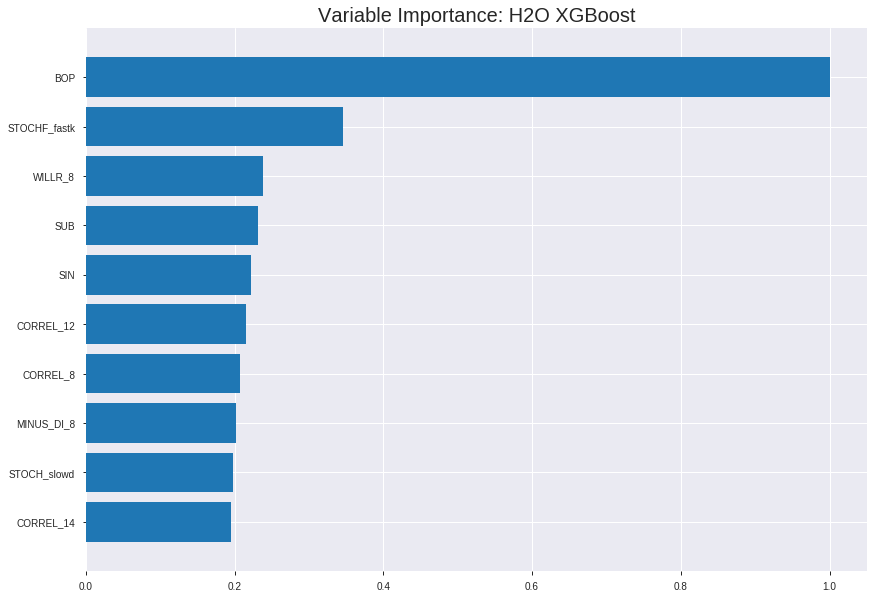

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_141001


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1302515516324346
RMSE: 0.3609037983070206
LogLoss: 0.4293494216395069
Mean Per-Class Error: 0.13181218916837445
AUC: 0.9420316150843895
pr_auc: 0.9487894620976371
Gini: 0.884063230168779
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5216418385505677: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      700  130  0.1566   (130.0/830.0)
1      104  819  0.1127   (104.0/923.0)
Total  804  949  0.1335   (234.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.521642     0.875     195
max f2                       0.443295     0.91155   234
max f0point5                 0.589874     0.898004  157
max accuracy                 0.536734     0.868226  187
max precision                0.921713     1         0
max recall                   0.179605     1         358
max specificity              0.921713     1         0
max absolute_mcc             0.536734     0.735942  187
max min_per_class_accuracy   0.536734     0.86747   187
max mean_per_class_accuracy  0.536734     0.868188  187

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.872871           1.89924    1.89924            1                0.88952   1                           0.88952             0.0195016       0.0195016                  89.9242   89.9242
    2        0.0205362                   0.860199           1.89924    1.89924            1                0.865276  1                           0.877398            0.0195016       0.0390033                  89.9242   89.9242
    3        0.0302339                   0.846845           1.89924    1.89924            1                0.852263  1                           0.869336            0.0184182       0.0574215                  89.9242   89.9242
    4        0.040502                    0.837411           1.89924    1.89924            1                0.843389  1                           0.862758            0.0195016       0.0769231                  89.9242   89.9242
    5        0.0501997                   0.831052           1.89924    1.89924            1                0.834147  1                           0.857231            0.0184182       0.0953413                  89.9242   89.9242
    6        0.100399                    0.800213           1.89924    1.89924            1                0.81323   1                           0.83523             0.0953413       0.190683                   89.9242   89.9242
    7        0.150029                    0.766342           1.89924    1.89924            1                0.783387  1                           0.818081            0.0942579       0.28494                    89.9242   89.9242
    8        0.200228                    0.741952           1.76975    1.86678            0.931818         0.754805  0.982906                    0.802217            0.0888407       0.373781                   76.9748   86.6776
    9        0.300057                    0.689036           1.83412    1.85591            0.965714         0.718645  0.977186                    0.774412            0.183099        0.55688                    83.4125   85.5913
    10       0.399886                    0.622637           1.66048    1.80712            0.874286         0.657211  0.951498                    0.745154            0.165764        0.722644                   66.048    80.7124
    11       0.500285                    0.551985           1.24098    1.69351            0.653409         0.586402  0.891676                    0.713295            0.124594        0.847237                   24.0982   69.3508
    12       0.600114                    0.467541           0.748844   1.53636            0.394286         0.511336  0.808935                    0.679699            0.0747562       0.921993                   -25.1156  53.6364
    13       0.699943                    0.387864           0.455818   1.38225            0.24             0.428279  0.727791                    0.64384             0.0455038       0.967497                   -54.4182  38.2252
    14       0.799772                    0.296207           0.282173   1.24494            0.148571         0.342383  0.655492                    0.606212            0.028169        0.995666                   -71.7827  24.4938
    15       0.899601                    0.203962           0.0325584  1.1104             0.0171429        0.250326  0.584654                    0.566719            0.00325027      0.998917                   -96.7442  11.04
    16       1                           0.0631507          0.0107911  1                  0.00568182       0.145884  0.526526                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21135468090295248
RMSE: 0.45973327147700815
LogLoss: 0.6091239736811682
Mean Per-Class Error: 0.30683195153061227
AUC: 0.7267777423469388
pr_auc: 0.7315059711469957
Gini: 0.45355548469387763
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29030589759349823: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   188  0.7673   (188.0/245.0)
1      13   243  0.0508   (13.0/256.0)
Total  70   431  0.4012   (201.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290306     0.707424  338
max f2                       0.175459     0.84893   372
max f0point5                 0.534609     0.703125  184
max accuracy                 0.534609     0.692615  184
max precision                0.897318     1         0
max recall                   0.144947     1         385
max specificity              0.897318     1         0
max absolute_mcc             0.534609     0.386583  184
max min_per_class_accuracy   0.525313     0.6875    193
max mean_per_class_accuracy  0.534609     0.693168  184

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.864491           1.95703   1.95703            1                0.879229  1                           0.879229            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.848719           1.56563   1.77912            0.8              0.852072  0.909091                    0.866885            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.841369           1.95703   1.83472            1                0.843594  0.9375                      0.859607            0.0195312       0.0585938                  95.7031   83.4717
    4        0.0419162                   0.821561           1.95703   1.86384            1                0.829242  0.952381                    0.852377            0.0195312       0.078125                   95.7031   86.3839
    5        0.0518962                   0.802818           1.95703   1.88176            1                0.806361  0.961538                    0.843528            0.0195312       0.0976562                  95.7031   88.1761
    6        0.101796                    0.761587           1.40906   1.65005            0.72             0.784935  0.843137                    0.814806            0.0703125       0.167969                   40.9063   65.0046
    7        0.151697                    0.723661           1.2525    1.51927            0.64             0.743313  0.776316                    0.791288            0.0625          0.230469                   25.25     51.9274
    8        0.201597                    0.684807           1.48734   1.51137            0.76             0.702434  0.772277                    0.769295            0.0742188       0.304688                   48.7344   51.1371
    9        0.301397                    0.633987           1.33078   1.45157            0.68             0.65942   0.741722                    0.732912            0.132812        0.4375                     33.0781   45.1573
    10       0.401198                    0.582794           1.33078   1.42153            0.68             0.609667  0.726368                    0.702254            0.132812        0.570312                   33.0781   42.1525
    11       0.500998                    0.52548            1.17422   1.37226            0.6              0.551277  0.701195                    0.672179            0.117188        0.6875                     17.4219   37.2261
    12       0.600798                    0.479094           0.587109  1.24184            0.3              0.504647  0.634551                    0.64435             0.0585938       0.746094                   -41.2891  24.1837
    13       0.700599                    0.416031           0.782813  1.17645            0.4              0.448334  0.60114                     0.616427            0.078125        0.824219                   -21.7187  17.6449
    14       0.800399                    0.346683           0.743672  1.12249            0.38             0.378742  0.573566                    0.586791            0.0742188       0.898438                   -25.6328  12.2487
    15       0.9002                      0.242617           0.704531  1.07615            0.36             0.295719  0.549889                    0.554521            0.0703125       0.96875                    -29.5469  7.61502
    16       1                           0.0724206          0.313125  1                  0.16             0.166434  0.510978                    0.51579          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:10:01  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.473474                         0.5                0.693147              0.5               0                    1                  0.489022
    2019-08-27 14:10:01  0.155 sec   5                  0.475797         0.645657            0.824287        0.830091           1.89924          0.261266                         0.485482           0.664381              0.712994          0.698469             1.30469            0.373253
    2019-08-27 14:10:01  0.262 sec   10                 0.4562           0.608089            0.855158        0.865442           1.89924          0.229321                         0.477837           0.64918               0.715195          0.699752             1.63086            0.351297
    2019-08-27 14:10:01  0.372 sec   15                 0.44043          0.578047            0.871439        0.879851           1.89924          0.224187                         0.471283           0.63592               0.723007          0.708441             1.63086            0.359281
    2019-08-27 14:10:02  0.488 sec   20                 0.42746          0.553348            0.880656        0.887391           1.89924          0.212208                         0.466809           0.626562              0.725526          0.71508              1.95703            0.363273
    2019-08-27 14:10:02  0.592 sec   25                 0.415675         0.530898            0.890703        0.898367           1.89924          0.18939                          0.464449           0.62116               0.721285          0.712017             1.95703            0.369261
    2019-08-27 14:10:02  0.714 sec   30                 0.404997         0.510662            0.899238        0.90816            1.89924          0.183115                         0.46193            0.615862              0.728197          0.719519             1.95703            0.355289
    2019-08-27 14:10:02  0.815 sec   35                 0.396629         0.494656            0.905237        0.91336            1.89924          0.185967                         0.459835           0.611159              0.731529          0.728033             1.95703            0.351297
    2019-08-27 14:10:02  0.937 sec   40                 0.388671         0.479707            0.914082        0.923371           1.89924          0.169424                         0.459061           0.608909              0.731043          0.732758             1.95703            0.371257
    2019-08-27 14:10:02  1.071 sec   45                 0.381967         0.46705             0.920209        0.92911            1.89924          0.16486                          0.459154           0.608531              0.730301          0.733258             1.95703            0.377246
    2019-08-27 14:10:02  1.185 sec   50                 0.374736         0.453739            0.927014        0.936165           1.89924          0.153451                         0.460576           0.611174              0.724833          0.727425             1.95703            0.389222
    2019-08-27 14:10:02  1.305 sec   55                 0.367727         0.441161            0.934531        0.943103           1.89924          0.148888                         0.459733           0.609121              0.726419          0

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ----------------------
BOP             1551.1751708984375     1.0                   0.17509586053977136
STOCHF_fastk    536.2884521484375      0.3457304256861076    0.06053596640029048
WILLR_8         369.4691162109375      0.2381865846891694    0.04170548501517924
SUB             360.0489501953125      0.2321136625638308    0.04064214148965206
SIN             345.3988342285156      0.22266913544552247   0.03898844388648066
---             ---                    ---                   ---
CDLBELTHOLD     11.171500205993652     0.007201959143997349  0.001261033233890491
CDLRICKSHAWMAN  8.471165657043457      0.005461127676596947  0.0009562208500513047
CDLSHORTLINE    7.480823516845703      0.004822681317489646  0.0008444315353949278
CDLDOJI         3.8706648349761963     0.002495311237308108  0.00043691866841102483
CDLHANGINGMAN   3.635294198989868      0.002343574257241568  0.00041035015131056783


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.751552795031056)

('auc', 0.7351217025614885)

('logloss', 0.6082590305740684)

('mean_per_class_error', 0.2925958965209634)

('rmse', 0.45615576857742485)

('mse', 0.20807808520646115)

xgboost prediction progress: |████████████████████████████████████████████| 100%


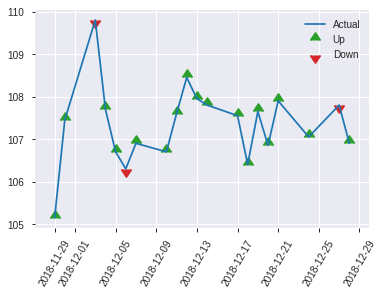


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20807808520646115
RMSE: 0.45615576857742485
LogLoss: 0.6082590305740684
Mean Per-Class Error: 0.2925958965209634
AUC: 0.7351217025614885
pr_auc: 0.6801893960364107
Gini: 0.4702434051229769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3635583221912384: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   68   0.5763   (68.0/118.0)
1      12   121  0.0902   (12.0/133.0)
Total  62   189  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363558     0.751553  188
max f2                       0.261352     0.861148  216
max f0point5                 0.526191     0.723781  135
max accuracy                 0.526191     0.709163  135
max precision                0.61155      0.768421  94
max recall                   0.107973     1         247
max specificity              0.876411     0.991525  0
max absolute_mcc             0.472271     0.417825  157
max min_per_class_accuracy   0.542134     0.694915  128
max mean_per_class_accuracy  0.526191     0.707404  135

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 51.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.862237           0.629073  0.629073           0.333333         0.868775  0.333333                    0.868775            0.0075188       0.0075188                  -37.0927  -37.0927
    2        0.0239044                   0.855458           1.25815   0.943609           0.666667         0.85794   0.5                         0.863357            0.0150376       0.0225564                  25.8145   -5.6391
    3        0.0318725                   0.835365           0.943609  0.943609           0.5              0.842107  0.5                         0.858045            0.0075188       0.0300752                  -5.6391   -5.6391
    4        0.0438247                   0.820852           1.88722   1.20096            1                0.82507   0.636364                    0.849052            0.0225564       0.0526316                  88.7218   20.0957
    5        0.0517928                   0.807337           0         1.01619            0                0.810111  0.538462                    0.843061            0               0.0526316                  -100      1.61943
    6        0.103586                    0.772167           1.59688   1.30654            0.846154         0.791412  0.692308                    0.817236            0.0827068       0.135338                   59.6877   30.6536
    7        0.151394                    0.728946           1.25815   1.29125            0.666667         0.747543  0.684211                    0.795228            0.0601504       0.195489                   25.8145   29.1254
    8        0.203187                    0.693822           1.59688   1.36916            0.846154         0.706774  0.72549                     0.772681            0.0827068       0.278195                   59.6877   36.9158
    9        0.302789                    0.641933           1.43429   1.39058            0.76             0.667268  0.736842                    0.738006            0.142857        0.421053                   43.4286   39.0582
    10       0.40239                     0.60183            1.3588    1.38271            0.72             0.62114   0.732673                    0.709079            0.135338        0.556391                   35.8797   38.2714
    11       0.501992                    0.554502           1.20782   1.34801            0.64             0.576531  0.714286                    0.682779            0.120301        0.676692                   20.782    34.8013
    12       0.601594                    0.502723           1.13233   1.3123             0.6              0.523737  0.695364                    0.656448            0.112782        0.789474                   13.2331   31.2304
    13       0.701195                    0.396627           0.679398  1.2224             0.36             0.453683  0.647727                    0.627646            0.0676692       0.857143                   -32.0602  22.2403
    14       0.800797                    0.326191           0.679398  1.15486            0.36             0.364435  0.61194                     0.594908            0.0676692       0.924812                   -32.0602  15.4865
    15       0.900398                    0.224794           0.452932  1.07722            0.24             0.278255  0.570796                    0.55988             0.0451128       0.969925                   -54.7068  7.72174
    16       1                           0.0907636          0.301955  1                  0.16             0.155953  0.52988                     0.519649        

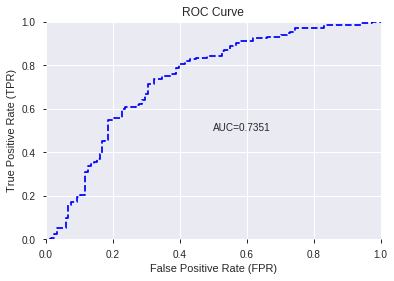

This function is available for GLM models only


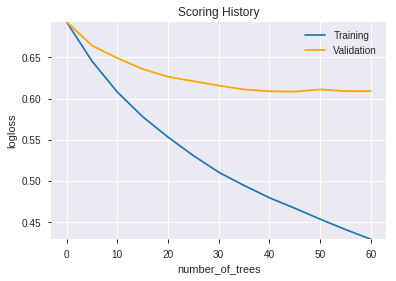

--2019-08-27 14:10:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_141001',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_141001',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_9baf',
   'type

['BOP',
 'STOCHF_fastk',
 'WILLR_8',
 'SUB',
 'SIN',
 'CORREL_12',
 'CORREL_8',
 'MINUS_DI_8',
 'STOCH_slowd',
 'CORREL_14',
 'DIV',
 'TRANGE',
 'VAR_20',
 'SAREXT',
 'ROC_8',
 'ADOSC',
 'MOM_8',
 'CDLCLOSINGMARUBOZU',
 'day',
 'WILLR_20',
 'STOCHRSI_fastk',
 'WILLR_14',
 'AROONOSC_8',
 'ULTOSC',
 'aroonup_8',
 'WILLR_12',
 'aroondown_14',
 'dayofweek',
 'weekday_name',
 'days_in_month',
 'aroondown_8',
 'quarter',
 'ROCR_8',
 'weekday',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLRICKSHAWMAN',
 'CDLSHORTLINE',
 'CDLDOJI',
 'CDLHANGINGMAN']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

31

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CORREL_12',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_141030_model_6  0.711100  0.647532              0.306327  0.468955  0.219919
1  DeepLearning_grid_1_AutoML_20190827_141030_model_9  0.707914  0.630073              0.319995  0.467503  0.218559
2  DeepLearning_grid_1_AutoML_20190827_141030_model_4  0.704346  0.681148              0.313846  0.474110  0.224780
3  DeepLearning_grid_1_AutoML_20190827_141030_model_5  0.701861  0.650402              0.323276  0.475033  0.225656
4               DeepLearning_1_AutoML_20190827_141030  0.700013  0.671190              0.324232  0.479258  0.229688
5  DeepLearning_grid_1_AutoML_20190827_141030_model_2  0.699630  0.687310              0.354435  0.479515  0.229934
6  DeepLearning_grid_1_AutoML_20190827_141030_model_8  0.695552  0.644724              0.342137  0.472362  0.223126
7  DeepLearning_grid_1_AutoML_20190827_141030_model_3  0.688097  0.689636              0.384096  0.480440  0.230823
8  DeepLearning_grid_1_AutoML_20190827_141030_model_7  0.679973  0.693500              0.372340  0.481024  0.231384
9  DeepLearning_grid_1_AutoML_20190827_141030_model_1  0.668663  0.772655              0.377469  0.502020  0.252024

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.067324
1   CDLCLOSINGMARUBOZU             0.952350           0.952350    0.064116
2         CDLSHORTLINE             0.701864           0.701864    0.047253
3                  SUB             0.681634           0.681634    0.045891
4          CDLLONGLINE             0.677203           0.677203    0.045592
5               TRANGE             0.581704           0.581704    0.039163
6          CDLMARUBOZU             0.578660           0.578660    0.038958
7            CORREL_12             0.563070           0.563070    0.037908
8              WILLR_8             0.546561           0.546561    0.036797
9         STOCHF_fastk             0.534618           0.534618    0.035993
10              CCI_12             0.495350           0.495350    0.033349
11               CCI_8             0.485992           0.485992    0.032719
12      STOCHRSI_fastd             0.484966           0.484966    0.032650
13                 DIV             0.481308           0.481308    0.032404
14      STOCHRSI_fastk             0.471029           0.471029    0.031712
15              ULTOSC             0.387526           0.387526    0.026090
16         CDLBELTHOLD             0.381022           0.381022    0.025652
17              CMO_12             0.372186           0.372186    0.025057
18              RSI_12             0.368145           0.368145    0.024785
19               CMO_8             0.362049           0.362049    0.024375
20               RSI_8             0.361351           0.361351    0.024328
21        CDLENGULFING             0.356029           0.356029    0.023969
22            WILLR_14             0.352605           0.352605    0.023739
23            WILLR_20             0.351797           0.351797    0.023685
24            WILLR_12             0.349080           0.349080    0.023502
25            WILLR_24             0.346902           0.346902    0.023355
26           ROCR100_8             0.336649           0.336649    0.022665
27               MOM_8             0.332140           0.332140    0.022361
28               ROC_8             0.326189           0.326189    0.021960
29              ROCP_8             0.322304           0.322304    0.021699
30              ROCR_8             0.311180           0.311180    0.020950

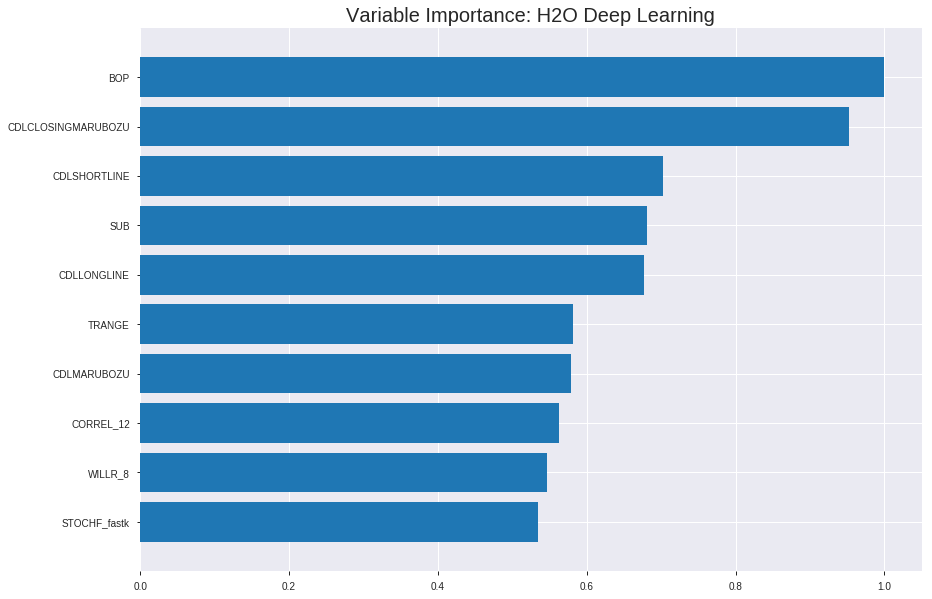

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_141030_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20078722467339422
RMSE: 0.4480928750531459
LogLoss: 0.583256258905755
Mean Per-Class Error: 0.31109791277787213
AUC: 0.7516316620762573
pr_auc: 0.7575988757150507
Gini: 0.5032633241525146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2673887431779803: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      239  591   0.712    (591.0/830.0)
1      34   889   0.0368   (34.0/923.0)
Total  273  1480  0.3565   (625.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267389     0.739908  319
max f2                       0.189171     0.861971  349
max f0point5                 0.590287     0.702935  184
max accuracy                 0.574504     0.691957  197
max precision                0.991898     1         0
max recall                   0.106381     1         381
max specificity              0.991898     1         0
max absolute_mcc             0.574504     0.380768  197
max min_per_class_accuracy   0.592034     0.68364   183
max mean_per_class_accuracy  0.574504     0.688902  197

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 54.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.965266           1.89924   1.89924            1                0.974385  1                           0.974385            0.0195016       0.0195016                  89.9242   89.9242
    2        0.0205362                   0.952983           1.79373   1.84648            0.944444         0.959147  0.972222                    0.966766            0.0184182       0.0379198                  79.3728   84.6485
    3        0.0302339                   0.93562            1.56408   1.7559             0.823529         0.942543  0.924528                    0.958997            0.0151679       0.0530878                  56.4081   75.5903
    4        0.040502                    0.916579           1.68821   1.73874            0.888889         0.923643  0.915493                    0.950034            0.0173348       0.0704225                  68.8215   73.8742
    5        0.0501997                   0.896021           1.6758    1.72658            0.882353         0.906582  0.909091                    0.94164             0.0162514       0.0866739                  67.5801   72.6583
    6        0.100399                    0.820371           1.57551   1.65105            0.829545         0.854456  0.869318                    0.898048            0.0790899       0.165764                   57.5507   65.1045
    7        0.150029                    0.757563           1.61545   1.63927            0.850575         0.78695   0.863118                    0.861297            0.0801733       0.245937                   61.5447   63.9269
    8        0.200228                    0.715978           1.3381    1.56376            0.704545         0.735891  0.823362                    0.829856            0.0671723       0.313109                   33.8102   56.3763
    9        0.300057                    0.654556           1.21551   1.4479             0.64             0.681262  0.762357                    0.780419            0.121343        0.434453                   21.5515   44.7901
    10       0.399886                    0.618808           1.18296   1.38176            0.622857         0.635115  0.727532                    0.744145            0.118093        0.552546                   18.2956   38.1759
    11       0.500285                    0.593684           1.18703   1.34268            0.625            0.606271  0.706956                    0.716476            0.119177        0.671723                   18.7026   34.2679
    12       0.600114                    0.558121           1.02016   1.28903            0.537143         0.578776  0.678707                    0.693569            0.101842        0.773564                   2.01641   28.9029
    13       0.699943                    0.473983           0.824813  1.22282            0.434286         0.522753  0.643847                    0.669207            0.0823402       0.855905                   -17.5187  22.2821
    14       0.799772                    0.351523           0.716285  1.15959            0.377143         0.423078  0.610556                    0.638485            0.071506        0.927411                   -28.3715  15.9594
    15       0.899601                    0.18774            0.564346  1.09354            0.297143         0.262708  0.575777                    0.596785            0.056338        0.983749                   -43.5654  9.35392
    16       1                           0.0448443          0.161867  1                  0.0852273        0.125879  0.526526                    0.549506         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.210852652389152
RMSE: 0.45918694710232344
LogLoss: 0.6101508512557731
Mean Per-Class Error: 0.3076211734693878
AUC: 0.7415098852040817
pr_auc: 0.7569895523836331
Gini: 0.48301977040816335
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4469021026470351: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  133  0.5429   (133.0/245.0)
1      40   216  0.1562   (40.0/256.0)
Total  152  349  0.3453   (173.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446902     0.71405   265
max f2                       0.0796151    0.843215  392
max f0point5                 0.619722     0.702519  149
max accuracy                 0.581202     0.692615  193
max precision                0.98293      1         0
max recall                   0.0796151    1         392
max specificity              0.98293      1         0
max absolute_mcc             0.581202     0.384837  193
max min_per_class_accuracy   0.585294     0.681633  189
max mean_per_class_accuracy  0.581202     0.692379  193

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.951163           1.95703   1.95703            1                0.964981  1                           0.964981            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.933021           1.56563   1.77912            0.8              0.942348  0.909091                    0.954693            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.921584           1.95703   1.83472            1                0.9253    0.9375                      0.945508            0.0195312       0.0585938                  95.7031   83.4717
    4        0.0419162                   0.910936           1.95703   1.86384            1                0.915782  0.952381                    0.93843             0.0195312       0.078125                   95.7031   86.3839
    5        0.0518962                   0.891812           1.56563   1.80649            0.8              0.903313  0.923077                    0.931677            0.015625        0.09375                    56.5625   80.649
    6        0.101796                    0.781735           1.72219   1.76517            0.88             0.819014  0.901961                    0.87645             0.0859375       0.179688                   72.2188   76.5165
    7        0.151697                    0.73559            1.48734   1.67378            0.76             0.7555    0.855263                    0.836664            0.0742188       0.253906                   48.7344   67.3777
    8        0.201597                    0.709619           1.72219   1.68576            0.88             0.720644  0.861386                    0.807946            0.0859375       0.339844                   72.2188   68.576
    9        0.301397                    0.652631           1.17422   1.51638            0.6              0.676024  0.774834                    0.764263            0.117188        0.457031                   17.4219   51.6375
    10       0.401198                    0.6134             1.17422   1.43126            0.6              0.633439  0.731343                    0.73172             0.117188        0.574219                   17.4219   43.1262
    11       0.500998                    0.585951           1.01766   1.34887            0.52             0.599733  0.689243                    0.705428            0.101562        0.675781                   1.76563   34.887
    12       0.600798                    0.540031           0.861094  1.26784            0.44             0.568592  0.647841                    0.682698            0.0859375       0.761719                   -13.8906  26.7844
    13       0.700599                    0.436978           0.821953  1.20433            0.42             0.490164  0.615385                    0.655271            0.0820312       0.84375                    -17.8047  20.4327
    14       0.800399                    0.335604           0.587109  1.12737            0.3              0.395317  0.57606                     0.622858            0.0585938       0.902344                   -41.2891  12.7367
    15       0.9002                      0.176033           0.508828  1.05879            0.26             0.249593  0.54102                     0.581476            0.0507812       0.953125                   -49.1172  5.8793
    16       1                           0.0341828          0.469688  1                  0.24             0.118577  0.510978                    0.535278            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:14:36  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:14:39  2 min 16.368 sec  827 obs/sec       1         1             1753       0.496607         0.750763            0.0107429      0.697331        0.692343           1.68821          0.375357                         0.495801           0.73589               0.0162505        0.70916           0.71006              1.63086            0.389222
    2019-08-27 14:14:45  2 min 22.693 sec  1782 obs/sec      8         8             14024      0.4612           0.612111            0.146778       0.730201        0.723447           1.5827           0.367941                         0.469549           0.629549              0.117671         0.730708          0.743278             1.63086            0.303393
    2019-08-27 14:14:51  2 min 28.622 sec  2388 obs/sec      18        18            31554      0.457043         0.603759            0.162089       0.731734        0.731176           1.79373          0.350257                         0.46423            0.619333              0.137545         0.74198           0.760425             1.95703            0.319361
    2019-08-27 14:14:57  2 min 35.018 sec  2696 obs/sec      29        29            50837      0.45445          0.599653            0.171569       0.735566        0.735003           1.79373          0.358813                         0.460589           0.616999              0.151022         0.739086          0.752985             1.95703            0.323353
    2019-08-27 14:15:05  2 min 42.507 sec  2924 obs/sec      43        43            75379      0.452297         0.593739            0.179401       0.740282        0.744679           1.89924          0.347975                         0.459743           0.615646              0.154136         0.743447          0.757839             1.95703            0.333333
    2019-08-27 14:15:11  2 min 48.391 sec  3046 obs/sec      54        54            94662      0.44962          0.58686             0.189085       0.749371        0.752792           1.89924          0.350257                         0.461342           0.618415              0.148242         0.744021          0.759447             1.95703            0.305389
    2019-08-27 14:15:17  2 min 54.756 sec  3141 obs/sec      66        66            115698     0.448093         0.583256            0.194584       0.751632        0.757599           1.89924          0.356532                         0.459187           0.610151              0.156183         0.74151           0.75699              1.95703            0.345309

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.06732436174160637
CDLCLOSINGMARUBOZU  0.9523501992225647     0.9523501992225647   0.06411636931715084
CDLSHORTLINE        0.70186448097229       0.70186448097229     0.04725257821056325
SUB                 0.6816341280937195     0.6816341280937195   0.045890582615206024
CDLLONGLINE         0.6772034764289856     0.6772034764289856   0.045592291819778426
---                 ---                    ---                  ---
ROCR100_8           0.3366493582725525     0.3366493582725525   0.02266470317642097
MOM_8               0.33213990926742554    0.33213990926742554  0.022361107400344474
ROC_8               0.3261885643005371     0.3261885643005371   0.02196043689894459
ROCP_8              0.3223043978214264     0.3223043978214264   0.021698937869840316
ROCR_8              0.3111802041530609     0.3111802041530609   0.020950008631227594


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7440273037542663)

('auc', 0.7110997833566969)

('logloss', 0.6475324074854769)

('mean_per_class_error', 0.30632725882502865)

('rmse', 0.4689552542361234)

('mse', 0.2199190304756671)

deeplearning prediction progress: |███████████████████████████████████████| 100%


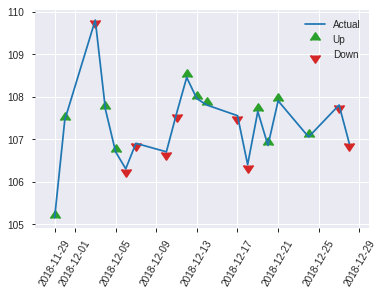


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2199190304756671
RMSE: 0.4689552542361234
LogLoss: 0.6475324074854769
Mean Per-Class Error: 0.30632725882502865
AUC: 0.7110997833566969
pr_auc: 0.6771550231862099
Gini: 0.42219956671339376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5078843309404436: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   51   0.4322   (51.0/118.0)
1      24   109  0.1805   (24.0/133.0)
Total  91   160  0.2988   (75.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507884     0.744027  159
max f2                       0.147958     0.856209  232
max f0point5                 0.507884     0.705045  159
max accuracy                 0.507884     0.701195  159
max precision                0.967724     1         0
max recall                   0.0461067    1         249
max specificity              0.967724     1         0
max absolute_mcc             0.507884     0.402147  159
max min_per_class_accuracy   0.581277     0.661017  127
max mean_per_class_accuracy  0.507884     0.693673  159

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 53.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.95944            1.88722   1.88722            1                0.963719  1                           0.963719            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.942445           0         0.943609           0                0.952032  0.5                         0.957875            0               0.0225564                  -100      -5.6391
    3        0.0318725                   0.932084           1.88722   1.17951            1                0.940849  0.625                       0.953619            0.0150376       0.037594                   88.7218   17.9511
    4        0.0438247                   0.921839           1.25815   1.20096            0.666667         0.922654  0.636364                    0.945174            0.0150376       0.0526316                  25.8145   20.0957
    5        0.0517928                   0.900795           0.943609  1.16136            0.5              0.911811  0.615385                    0.940041            0.0075188       0.0601504                  -5.6391   16.1365
    6        0.103586                    0.811815           1.45171   1.30654            0.769231         0.850291  0.692308                    0.895166            0.075188        0.135338                   45.1706   30.6536
    7        0.151394                    0.744921           1.25815   1.29125            0.666667         0.773218  0.684211                    0.856656            0.0601504       0.195489                   25.8145   29.1254
    8        0.203187                    0.711843           1.59688   1.36916            0.846154         0.729062  0.72549                     0.824132            0.0827068       0.278195                   59.6877   36.9158
    9        0.302789                    0.64832            1.28331   1.34092            0.68             0.674196  0.710526                    0.774811            0.12782         0.406015                   28.3308   34.0918
    10       0.40239                     0.613375           1.50977   1.38271            0.8              0.628306  0.732673                    0.738548            0.150376        0.556391                   50.9774   38.2714
    11       0.501992                    0.582978           0.981353  1.30308            0.52             0.594871  0.690476                    0.71004             0.0977444       0.654135                   -1.86466  30.3079
    12       0.601594                    0.543001           1.20782   1.28731            0.64             0.564947  0.682119                    0.686018            0.120301        0.774436                   20.782    28.7308
    13       0.701195                    0.427311           0.60391   1.19023            0.32             0.489459  0.630682                    0.658098            0.0601504       0.834586                   -39.609   19.0234
    14       0.800797                    0.318944           0.754887  1.13609            0.4              0.373595  0.60199                     0.622712            0.075188        0.909774                   -24.5113  13.6086
    15       0.900398                    0.176115           0.60391   1.07722            0.32             0.235592  0.570796                    0.579889            0.0601504       0.969925                   -39.609   7.72174
    16       1                           0.0439796          0.301955  1                  0.16             0.117374  0.52988                     0.533822         

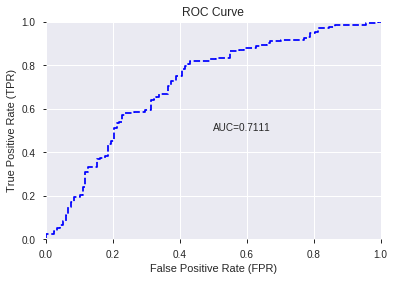

This function is available for GLM models only


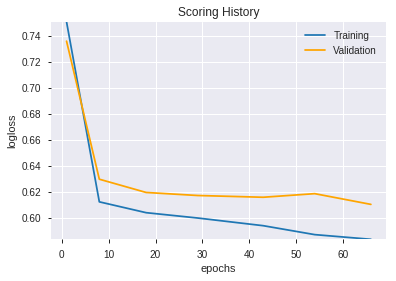

--2019-08-27 14:18:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_141030_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_141030_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'SUB',
 'CDLLONGLINE',
 'TRANGE',
 'CDLMARUBOZU',
 'CORREL_12',
 'WILLR_8',
 'STOCHF_fastk',
 'CCI_12',
 'CCI_8',
 'STOCHRSI_fastd',
 'DIV',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CDLBELTHOLD',
 'CMO_12',
 'RSI_12',
 'CMO_8',
 'RSI_8',
 'CDLENGULFING',
 'WILLR_14',
 'WILLR_20',
 'WILLR_12',
 'WILLR_24',
 'ROCR100_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_141848_model_1  0.71231  0.629771               0.35915  0.465498  0.216688

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.544392           1.000000    0.113291
1                CCI_8             0.469110           0.861714    0.097625
2              WILLR_8             0.426994           0.784351    0.088860
3             WILLR_14             0.368094           0.676155    0.076603
4                  SUB             0.328189           0.602854    0.068298
5         STOCHF_fastk             0.285101           0.523705    0.059331
6             WILLR_20             0.259767           0.477169    0.054059
7   CDLCLOSINGMARUBOZU             0.247237           0.454152    0.051451
8               CCI_12             0.198639           0.364882    0.041338
9            CORREL_12             0.185500           0.340747    0.038604
10              CMO_12             0.184803           0.339467    0.038459
11              RSI_12             0.174473           0.320492    0.036309
12                 DIV             0.141231           0.259429    0.029391
13            WILLR_12             0.115847           0.212801    0.024109
14              TRANGE             0.108090           0.198552    0.022494
15            WILLR_24             0.088184           0.161986    0.018352
16               CMO_8             0.074116           0.136144    0.015424
17         CDLMARUBOZU             0.069338           0.127368    0.014430
18         CDLLONGLINE             0.069013           0.126771    0.014362
19               RSI_8             0.061629           0.113206    0.012825
20      STOCHRSI_fastk             0.061093           0.112222    0.012714
21        CDLENGULFING             0.049948           0.091750    0.010395
22               MOM_8             0.038773           0.071222    0.008069
23              ULTOSC             0.035476           0.065166    0.007383
24           ROCR100_8             0.034969           0.064235    0.007277
25         CDLBELTHOLD             0.033509           0.061554    0.006974
26              ROCR_8             0.033499           0.061534    0.006971
27        CDLSHORTLINE             0.033278           0.061129    0.006925
28              ROCP_8             0.032672           0.060016    0.006799
29               ROC_8             0.030229           0.055528    0.006291
30      STOCHRSI_fastd             0.022046           0.040497    0.004588

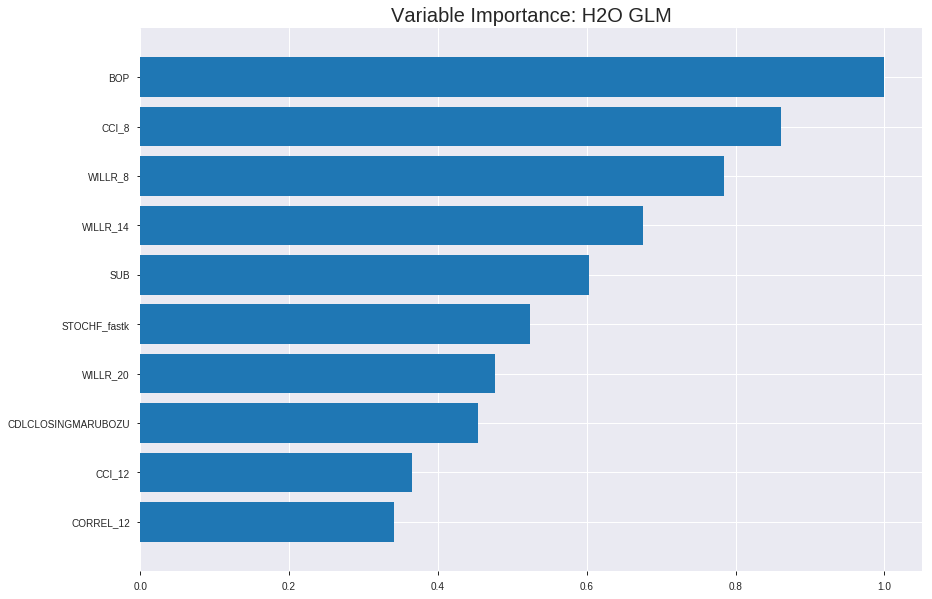

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_141848_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20720868290998387
RMSE: 0.4552018045987778
LogLoss: 0.6014312744531005
Null degrees of freedom: 1752
Residual degrees of freedom: 1721
Null deviance: 2425.2378703291097
Residual deviance: 2108.6180482325703
AIC: 2172.6180482325703
AUC: 0.7357523267501207
pr_auc: 0.7316949535382906
Gini: 0.4715046535002414
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.431698780784909: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      415  415   0.5      (415.0/830.0)
1      142  781   0.1538   (142.0/923.0)
Total  557  1196  0.3177   (557.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431699     0.73714   242
max f2                       0.122749     0.854155  378
max f0point5                 0.554334     0.696376  177
max accuracy                 0.440335     0.6834    238
max precision                0.924723     1         0
max recall                   0.122749     1         378
max specificity              0.924723     1         0
max absolute_mcc             0.440335     0.371526  238
max min_per_class_accuracy   0.543497     0.674973  182
max mean_per_class_accuracy  0.528923     0.678619  190

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.878587           1.68821   1.68821            0.888889         0.895903  0.888889                    0.895903            0.0173348       0.0173348                  68.8215   68.8215
    2        0.0205362                   0.854865           1.68821   1.68821            0.888889         0.863122  0.888889                    0.879512            0.0173348       0.0346696                  68.8215   68.8215
    3        0.0302339                   0.840276           1.6758    1.68423            0.882353         0.844483  0.886792                    0.868276            0.0162514       0.0509209                  67.5801   68.4233
    4        0.040502                    0.832219           1.5827    1.65849            0.833333         0.835832  0.873239                    0.860051            0.0162514       0.0671723                  58.2701   65.8493
    5        0.0501997                   0.823124           1.34064   1.59709            0.705882         0.82778   0.840909                    0.853817            0.0130011       0.0801733                  34.0641   59.709
    6        0.100399                    0.784263           1.44601   1.52155            0.761364         0.803671  0.801136                    0.828744            0.0725894       0.152763                   44.6013   52.1552
    7        0.150029                    0.742534           1.48446   1.50928            0.781609         0.764105  0.794677                    0.807361            0.0736728       0.226436                   48.4465   50.9283
    8        0.200228                    0.71205            1.35968   1.47178            0.715909         0.727096  0.774929                    0.787238            0.0682557       0.294691                   35.9684   47.1777
    9        0.300057                    0.656871           1.3566    1.43346            0.714286         0.685461  0.754753                    0.753377            0.135428        0.430119                   35.6601   43.3458
    10       0.399886                    0.607341           1.23722   1.38447            0.651429         0.632554  0.728959                    0.723214            0.12351         0.553629                   23.722    38.4469
    11       0.500285                    0.548545           1.12228   1.33185            0.590909         0.578165  0.701254                    0.694105            0.112676        0.666306                   12.2279   33.1851
    12       0.600114                    0.480955           0.976753  1.27278            0.514286         0.515327  0.670152                    0.664365            0.0975081       0.763814                   -2.32472  27.2781
    13       0.699943                    0.420527           0.922489  1.22282            0.485714         0.451397  0.643847                    0.633991            0.092091        0.855905                   -7.75112  22.2821
    14       0.799772                    0.34548            0.61861   1.1474             0.325714         0.385707  0.604137                    0.603               0.0617551       0.91766                    -38.139   14.7402
    15       0.899601                    0.223532           0.477524  1.07307            0.251429         0.287167  0.564997                    0.567952            0.0476706       0.96533                    -52.2476  7.30655
    16       1                           0.0177858          0.345317  1                  0.181818         0.155343  0.526526                    0.526526          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2036585639289195
RMSE: 0.4512854572539642
LogLoss: 0.5904441599254124
Null degrees of freedom: 500
Residual degrees of freedom: 469
Null deviance: 694.7772912382
Residual deviance: 591.6250482452633
AIC: 655.6250482452633
AUC: 0.7497369260204082
pr_auc: 0.762106226361847
Gini: 0.4994738520408164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28123552434648036: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      67   178  0.7265   (178.0/245.0)
1      12   244  0.0469   (12.0/256.0)
Total  79   422  0.3792   (190.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281236     0.719764  333
max f2                       0.196983     0.852349  367
max f0point5                 0.605612     0.71      153
max accuracy                 0.561884     0.690619  186
max precision                0.937032     1         0
max recall                   0.107049     1         392
max specificity              0.937032     1         0
max absolute_mcc             0.668158     0.394759  108
max min_per_class_accuracy   0.545272     0.679688  200
max mean_per_class_accuracy  0.561884     0.691566  186

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.885638           1.95703   1.95703            1                0.90007   1                           0.90007             0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.865905           1.56563   1.77912            0.8              0.875656  0.909091                    0.888972            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.854206           1.56563   1.7124             0.8              0.857992  0.875                       0.879291            0.015625        0.0546875                  56.5625   71.2402
    4        0.0419162                   0.845452           1.95703   1.77065            1                0.848603  0.904762                    0.871984            0.0195312       0.0742188                  95.7031   77.0647
    5        0.0518962                   0.835668           1.95703   1.80649            1                0.838193  0.923077                    0.865486            0.0195312       0.09375                    95.7031   80.649
    6        0.101796                    0.783398           1.64391   1.72679            0.84             0.804774  0.882353                    0.835725            0.0820312       0.175781                   64.3906   72.6792
    7        0.151697                    0.737436           1.72219   1.72528            0.88             0.7619    0.881579                    0.811441            0.0859375       0.261719                   72.2188   72.5278
    8        0.201597                    0.701385           1.56563   1.68576            0.8              0.718449  0.861386                    0.788423            0.078125        0.339844                   56.5625   68.576
    9        0.301397                    0.639757           1.21336   1.52934            0.62             0.672978  0.781457                    0.750196            0.121094        0.460938                   21.3359   52.9336
    10       0.401198                    0.585068           1.13508   1.43126            0.58             0.613862  0.731343                    0.716282            0.113281        0.574219                   13.5078   43.1262
    11       0.500998                    0.541473           1.0568    1.35667            0.54             0.564779  0.693227                    0.686102            0.105469        0.679688                   5.67969   35.6667
    12       0.600798                    0.478151           0.743672  1.25484            0.38             0.511924  0.641196                    0.657169            0.0742188       0.753906                   -25.6328  25.4841
    13       0.700599                    0.403551           0.665391  1.17087            0.34             0.438737  0.598291                    0.626053            0.0664062       0.820312                   -33.4609  17.0873
    14       0.800399                    0.318501           0.939375  1.14201            0.48             0.363057  0.583541                    0.593261            0.09375         0.914062                   -6.0625   14.2008
    15       0.9002                      0.219716           0.62625   1.08483            0.32             0.268239  0.554324                    0.557227            0.0625          0.976562                   -37.375   8.48289
    16       1                           0.0160388          0.234844  1                  0.12             0.159642  0.510978                    0.517548           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:18:49  0.000 sec   2            .17E2     32            1.3659413161630731  1.370841545069258
     2019-08-27 14:18:49  0.008 sec   4            .11E2     32            1.3581937630022076  1.3636160679888683
     2019-08-27 14:18:49  0.015 sec   6            .66E1     32            1.3483525858497871  1.3541924988098046
     2019-08-27 14:18:49  0.022 sec   8            .41E1     32            1.3364825659746489  1.342376792181965
     2019-08-27 14:18:49  0.030 sec   10           .25E1     32            1.322664541388098   1.327915713000576
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:18:49  0.164 sec   40           .12E-2    32            1.2025678224112528  1.1809515024829789
     2019-08-27 14:18:49  0.173 sec   41           .77E-3    32            1.2023877005646013  1.1811302816863707
     2019-08-27 14:18:49  0.179 sec   42           .48E-3    32            1.2022882604333285  1.181343008486584
     2019-08-27 14:18:49  0.185 sec   43           .3E-3     32            1.2022386064109756  1.1815418877859107
     2019-08-27 14:18:49  0.190 sec   44           .19E-3    32            1.202215469804126   1.1816905273028944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7393939393939394)

('auc', 0.7123104371097235)

('logloss', 0.62977093703236)

('mean_per_class_error', 0.3105008283420416)

('rmse', 0.4654977053529872)

('mse', 0.21668811368889648)

glm prediction progress: |████████████████████████████████████████████████| 100%


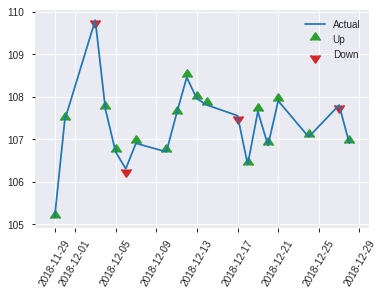


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21668811368889648
RMSE: 0.4654977053529872
LogLoss: 0.62977093703236
Null degrees of freedom: 250
Residual degrees of freedom: 219
Null deviance: 347.07426846610866
Residual deviance: 316.1450103902447
AIC: 380.1450103902447
AUC: 0.7123104371097235
pr_auc: 0.6759199582191847
Gini: 0.42462087421944705
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37829883033324496: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   75   0.6356   (75.0/118.0)
1      11   122  0.0827   (11.0/133.0)
Total  54   197  0.3426   (86.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378299     0.739394  196
max f2                       0.0658322    0.850384  249
max f0point5                 0.524338     0.705795  134
max accuracy                 0.497557     0.693227  143
max precision                0.906824     1         0
max recall                   0.0658322    1         249
max specificity              0.906824     1         0
max absolute_mcc             0.488006     0.383144  151
max min_per_class_accuracy   0.543501     0.677966  128
max mean_per_class_accuracy  0.497557     0.689499  143

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 53.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.876802           1.25815   1.25815            0.666667         0.888566  0.666667                    0.888566            0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.868336           1.25815   1.25815            0.666667         0.872551  0.666667                    0.880558            0.0150376       0.0300752                  25.8145   25.8145
    3        0.0318725                   0.847465           1.88722   1.41541            1                0.855338  0.75                        0.874253            0.0150376       0.0451128                  88.7218   41.5414
    4        0.0438247                   0.829873           0.629073  1.20096            0.333333         0.835427  0.636364                    0.863664            0.0075188       0.0526316                  -37.0927  20.0957
    5        0.0517928                   0.826079           0.943609  1.16136            0.5              0.828123  0.615385                    0.858197            0.0075188       0.0601504                  -5.6391   16.1365
    6        0.103586                    0.771791           1.30654   1.23395            0.692308         0.800621  0.653846                    0.829409            0.0676692       0.12782                    30.6536   23.395
    7        0.151394                    0.747481           1.41541   1.29125            0.75             0.756254  0.684211                    0.806307            0.0676692       0.195489                   41.5414   29.1254
    8        0.203187                    0.720643           1.45171   1.33215            0.769231         0.736673  0.705882                    0.788557            0.075188        0.270677                   45.1706   33.2154
    9        0.302789                    0.660254           1.50977   1.39058            0.8              0.690892  0.736842                    0.75643             0.150376        0.421053                   50.9774   39.0582
    10       0.40239                     0.608932           1.28331   1.36403            0.68             0.637315  0.722772                    0.726946            0.12782         0.548872                   28.3308   36.4029
    11       0.501992                    0.546949           1.20782   1.33303            0.64             0.572715  0.706349                    0.696345            0.120301        0.669173                   20.782    33.3035
    12       0.601594                    0.48913            1.05684   1.28731            0.56             0.513135  0.682119                    0.666012            0.105263        0.774436                   5.68421   28.7308
    13       0.701195                    0.433235           0.754887  1.21168            0.4              0.469375  0.642045                    0.638081            0.075188        0.849624                   -24.5113  21.168
    14       0.800797                    0.353943           0.754887  1.15486            0.4              0.396657  0.61194                     0.608053            0.075188        0.924812                   -24.5113  15.4865
    15       0.900398                    0.254146           0.301955  1.06052            0.16             0.301891  0.561947                    0.574186            0.0300752       0.954887                   -69.8045  6.05163
    16       1                           0.0545789          0.452932  1                  0.24             0.163681  0.52988                     0.533299           

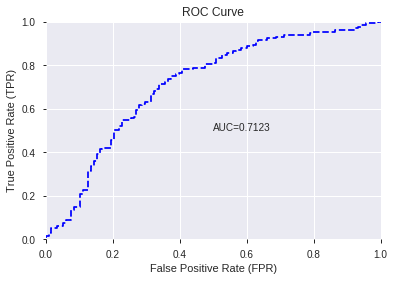

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


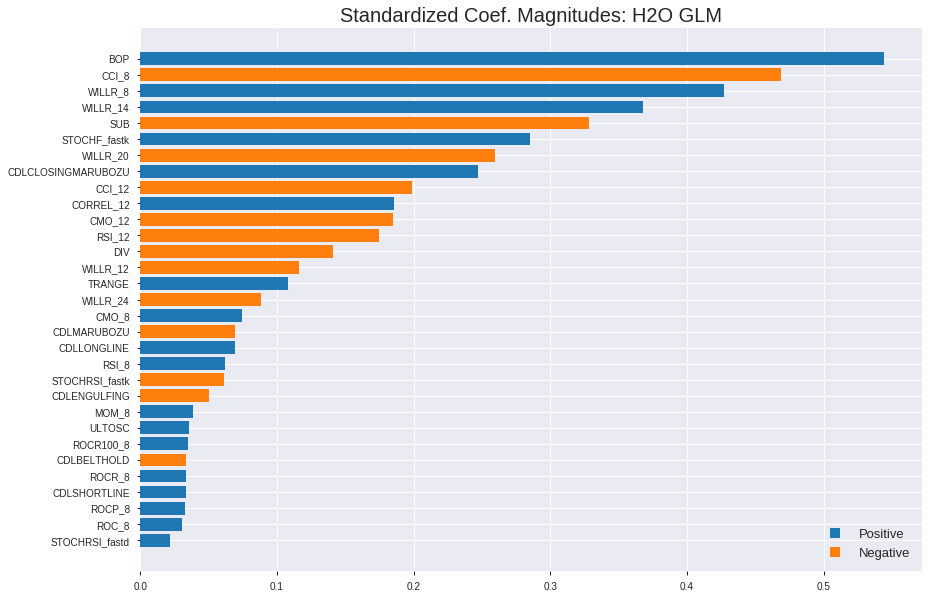

'log_likelihood'
--2019-08-27 14:18:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_141848_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_141848_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'WILLR_8',
 'WILLR_14',
 'SUB',
 'STOCHF_fastk',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'CCI_12',
 'CORREL_12',
 'CMO_12',
 'RSI_12',
 'DIV',
 'WILLR_12',
 'TRANGE',
 'WILLR_24',
 'CMO_8',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'RSI_8',
 'STOCHRSI_fastk',
 'CDLENGULFING',
 'MOM_8',
 'ULTOSC',
 'ROCR100_8',
 'CDLBELTHOLD',
 'ROCR_8',
 'CDLSHORTLINE',
 'ROCP_8',
 'ROC_8',
 'STOCHRSI_fastd']

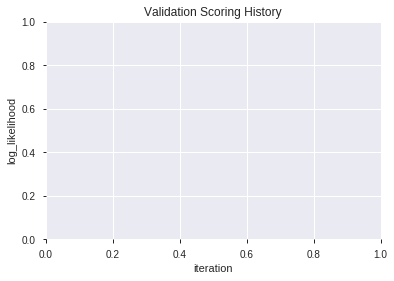

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_141900_model_5  0.749204  0.603776              0.329967  0.451040  0.203437
1               XGBoost_2_AutoML_20190827_141900  0.736332  0.603368              0.321492  0.454079  0.206188
2  XGBoost_grid_1_AutoML_20190827_141900_model_4  0.734421  0.605567              0.332293  0.455488  0.207469
3  XGBoost_grid_1_AutoML_20190827_141900_model_3  0.727475  0.610852              0.316236  0.457487  0.209295
4               XGBoost_1_AutoML_20190827_141900  0.727157  0.617707              0.338919  0.460312  0.211887
5  XGBoost_grid_1_AutoML_20190827_141900_model_2  0.727029  0.613019              0.337008  0.459449  0.211094
6  XGBoost_grid_1_AutoML_20190827_141900_model_6  0.726201  0.613430              0.323340  0.458938  0.210624
7  XGBoost_grid_1_AutoML_20190827_141900_model_1  0.718619  0.623918              0.329903  0.463213  0.214567
8               XGBoost_3_AutoML_20190827_141900  0.717599  0.623398              0.368580  0.462549  0.213952
9  XGBoost_grid_1_AutoML_20190827_141900_model_7  0.696891  0.637665              0.338378  0.469900  0.220806

variable  relative_importance  scaled_importance  percentage
0                  BOP          2669.607422           1.000000    0.102382
1                CCI_8          1863.426758           0.698015    0.071464
2         STOCHF_fastk          1439.929321           0.539379    0.055223
3                MOM_8          1426.503296           0.534349    0.054708
4            CORREL_12          1363.362305           0.510698    0.052286
5               TRANGE          1299.664917           0.486837    0.049844
6                CMO_8          1275.321899           0.477719    0.048910
7                  SUB          1221.484131           0.457552    0.046845
8               ULTOSC          1179.834961           0.441951    0.045248
9       STOCHRSI_fastd          1167.107788           0.437183    0.044760
10                 DIV          1052.804810           0.394367    0.040376
11            WILLR_12          1033.828857           0.387259    0.039648
12              CCI_12          1021.830261           0.382764    0.039188
13             WILLR_8          1019.933167           0.382054    0.039115
14               ROC_8           889.004944           0.333010    0.034094
15            WILLR_20           831.204956           0.311358    0.031878
16              CMO_12           767.072510           0.287335    0.029418
17            WILLR_14           736.316956           0.275815    0.028239
18            WILLR_24           712.538330           0.266908    0.027327
19      STOCHRSI_fastk           573.214111           0.214719    0.021983
20               RSI_8           522.430542           0.195696    0.020036
21              RSI_12           521.567810           0.195372    0.020003
22              ROCP_8           488.947174           0.183153    0.018752
23           ROCR100_8           203.754761           0.076324    0.007814
24              ROCR_8           181.663666           0.068049    0.006967
25  CDLCLOSINGMARUBOZU           172.177460           0.064495    0.006603
26         CDLLONGLINE           125.828209           0.047134    0.004826
27        CDLENGULFING           116.875511           0.043780    0.004482
28         CDLBELTHOLD            95.085136           0.035618    0.003647
29        CDLSHORTLINE            81.948196           0.030697    0.003143
30         CDLMARUBOZU            20.642107           0.007732    0.000792

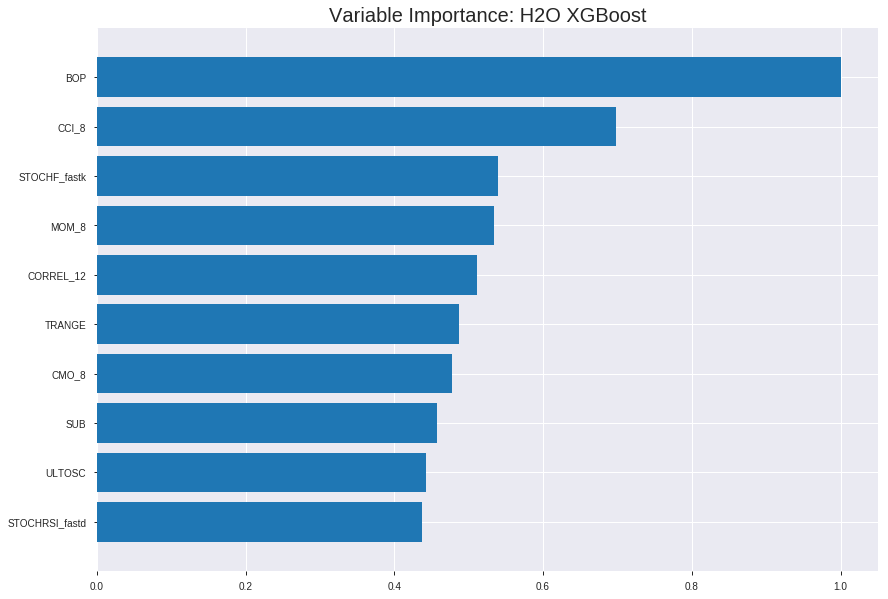

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_141900_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03176855766333862
RMSE: 0.17823736326409967
LogLoss: 0.17859521191345312
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9989165763813651
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5345690846443176: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      830  0    0        (0.0/830.0)
1      0    923  0        (0.0/923.0)
Total  830  923  0        (0.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.534569     1        196
max f2                       0.534569     1        196
max f0point5                 0.534569     1        196
max accuracy                 0.534569     1        196
max precision                0.96893      1        0
max recall                   0.534569     1        196
max specificity              0.96893      1        0
max absolute_mcc             0.534569     1        196
max min_per_class_accuracy   0.534569     1        196
max mean_per_class_accuracy  0.534569     1        196

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.950708           1.89924   1.89924            1                0.957048   1                           0.957048            0.0195016       0.0195016                  89.9242   89.9242
    2        0.0205362                   0.945071           1.89924   1.89924            1                0.948227   1                           0.952637            0.0195016       0.0390033                  89.9242   89.9242
    3        0.0302339                   0.937242           1.89924   1.89924            1                0.940934   1                           0.948883            0.0184182       0.0574215                  89.9242   89.9242
    4        0.040502                    0.93272            1.89924   1.89924            1                0.934903   1                           0.945339            0.0195016       0.0769231                  89.9242   89.9242
    5        0.0501997                   0.9276             1.89924   1.89924            1                0.929616   1                           0.942302            0.0184182       0.0953413                  89.9242   89.9242
    6        0.100399                    0.906886           1.89924   1.89924            1                0.917028   1                           0.929665            0.0953413       0.190683                   89.9242   89.9242
    7        0.150029                    0.894437           1.89924   1.89924            1                0.900328   1                           0.91996             0.0942579       0.28494                    89.9242   89.9242
    8        0.200228                    0.879602           1.89924   1.89924            1                0.887176   1                           0.911741            0.0953413       0.380282                   89.9242   89.9242
    9        0.300057                    0.849947           1.89924   1.89924            1                0.865795   1                           0.896455            0.189599        0.569881                   89.9242   89.9242
    10       0.399886                    0.811489           1.89924   1.89924            1                0.83121    1                           0.880167            0.189599        0.75948                    89.9242   89.9242
    11       0.500285                    0.705612           1.89924   1.89924            1                0.770952   1                           0.858249            0.190683        0.950163                   89.9242   89.9242
    12       0.600114                    0.260601           0.499229  1.66635            0.262857         0.407646   0.877376                    0.783291            0.0498375       1                          -50.0771  66.635
    13       0.699943                    0.191124           0         1.42869            0                0.222787   0.752241                    0.70335             0               1                          -100      42.8688
    14       0.799772                    0.13739            0         1.25036            0                0.162413   0.658345                    0.635829            0               1                          -100      25.0357
    15       0.899601                    0.0882791          0         1.1116             0                0.112948   0.585289                    0.577805            0               1                          -100      11.1604
    16       1                           0.02767            0         1                  0                0.0646821  0.526526                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.214588507916637
RMSE: 0.463236988933998
LogLoss: 0.6172250786417174
Mean Per-Class Error: 0.32759088010204085
AUC: 0.7197863520408163
pr_auc: 0.7173229263764278
Gini: 0.4395727040816326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3014058768749237: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   160  0.6531   (160.0/245.0)
1      21   235  0.082    (21.0/256.0)
Total  106  395  0.3613   (181.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301406     0.721966  313
max f2                       0.145462     0.846206  369
max f0point5                 0.503019     0.679348  208
max accuracy                 0.503019     0.672655  208
max precision                0.949006     1         0
max recall                   0.0854766    1         388
max specificity              0.949006     1         0
max absolute_mcc             0.503019     0.34489   208
max min_per_class_accuracy   0.508638     0.667969  205
max mean_per_class_accuracy  0.503019     0.672409  208

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 51.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.920177           1.95703   1.95703            1                0.932484  1                           0.932484            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.907391           1.56563   1.77912            0.8              0.911145  0.909091                    0.922785            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.896868           1.56563   1.7124             0.8              0.903206  0.875                       0.916666            0.015625        0.0546875                  56.5625   71.2402
    4        0.0419162                   0.891087           1.95703   1.77065            1                0.893146  0.904762                    0.911066            0.0195312       0.0742188                  95.7031   77.0647
    5        0.0518962                   0.88356            1.17422   1.65595            0.6              0.886678  0.846154                    0.906376            0.0117188       0.0859375                  17.4219   65.595
    6        0.101796                    0.839726           1.48734   1.5733             0.76             0.859453  0.803922                    0.883374            0.0742188       0.160156                   48.7344   57.33
    7        0.151697                    0.779925           1.72219   1.62228            0.88             0.813736  0.828947                    0.860467            0.0859375       0.246094                   72.2188   62.2276
    8        0.201597                    0.742346           1.33078   1.55012            0.68             0.757325  0.792079                    0.834937            0.0664062       0.3125                     33.0781   55.0124
    9        0.301397                    0.661734           1.13508   1.41269            0.58             0.702842  0.721854                    0.791197            0.113281        0.425781                   13.5078   41.2691
    10       0.401198                    0.590681           1.09594   1.3339             0.56             0.62626   0.681592                    0.750168            0.109375        0.535156                   9.59375   33.3897
    11       0.500998                    0.508688           1.29164   1.32548            0.66             0.547583  0.677291                    0.709812            0.128906        0.664062                   29.1641   32.5479
    12       0.600798                    0.442938           0.861094  1.24834            0.44             0.479763  0.637874                    0.671598            0.0859375       0.75                       -13.8906  24.8339
    13       0.700599                    0.369906           0.743672  1.17645            0.38             0.403225  0.60114                     0.633368            0.0742188       0.824219                   -25.6328  17.6449
    14       0.800399                    0.289172           0.978516  1.15177            0.5              0.33177   0.588529                    0.595762            0.0976562       0.921875                   -2.14844  15.1769
    15       0.9002                      0.181302           0.430547  1.07181            0.22             0.245841  0.547672                    0.556968            0.0429688       0.964844                   -56.9453  7.18109
    16       1                           0.0403745          0.352266  1                  0.18             0.11769   0.510978                    0.513128            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:19:10  4.829 sec   0                  0.5              0.693147            0.5             0                  1                0.473474                         0.5                0.693147              0.5               0                    1                  0.489022
    2019-08-27 14:19:10  5.171 sec   5                  0.446279         0.590599            0.971046        0.971399           1.89924          0.0889903                        0.484385           0.662147              0.691701          0.687509             1.95703            0.40519
    2019-08-27 14:19:11  5.488 sec   10                 0.403873         0.515373            0.991216        0.989951           1.89924          0.0399315                        0.47598            0.645247              0.703659          0.710398             1.95703            0.363273
    2019-08-27 14:19:11  5.814 sec   15                 0.372174         0.461644            0.995256        0.995021           1.89924          0.0296634                        0.478325           0.649677              0.684216          0.680624             1.95703            0.383234
    2019-08-27 14:19:11  6.165 sec   20                 0.363006         0.44609             0.996247        0.995881           1.89924          0.0262407                        0.469234           0.630673              0.702073          0.697023             1.95703            0.355289
    2019-08-27 14:19:12  6.532 sec   25                 0.336547         0.402843            0.998489        0.997663           1.89924          0.0159726                        0.470241           0.632491              0.6978            0.687895             1.95703            0.39521
    2019-08-27 14:19:12  6.873 sec   30                 0.322409         0.379468            0.998871        0.997962           1.89924          0.0142613                        0.472618           0.637455              0.692634          0.68161              1.95703            0.381238
    2019-08-27 14:19:12  7.207 sec   35                 0.303098         0.350003            0.999014        0.998118           1.89924          0.0125499                        0.463872           0.618534              0.713098          0.706891             1.95703            0.367265
    2019-08-27 14:19:13  7.591 sec   40                 0.295475         0.33716             0.999473        0.996302           1.89924          0.00912721                       0.465425           0.621729              0.707358          0.689816             1.63086            0.367265
    2019-08-27 14:19:13  7.950 sec   45                 0.268601         0.298259            0.999941        0.998865           1.89924          0.00171135                       0.465065           0.621602              0.709319          0.703831             1.95703            0.409182
    2019-08-27 14:19:14  8.539 sec   50                 0.257475         0.281716            0.999779        0.998726           1.89924          0.00456361                       0.462803           0.616897              0.716366          0.708094             1.95703            0.335329
    2019-08-27 14:19:14  8.899 sec   55                 0.247412         0.26783             0.999959        0.99888            1.89924          0.0034227                        0.464168           0.618166              0.709224          0.7

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           2669.607421875         1.0                   0.10238222066016041
CCI_8         1863.4267578125        0.6980152746592686    0.07146435387432772
STOCHF_fastk  1439.9293212890625     0.5393786777374658    0.055222786803502774
MOM_8         1426.5032958984375     0.5343494643480322    0.054707884768518754
CORREL_12     1363.3623046875        0.5106976754394629    0.05228636209747407
---           ---                    ---                   ---
CDLLONGLINE   125.82820892333984     0.04713360020364505   0.004825642656557369
CDLENGULFING  116.8755111694336      0.04378003679932311   0.004482297388098242
CDLBELTHOLD   95.08513641357422      0.03561764761156947   0.0036466138571635406
CDLSHORTLINE  81.94819641113281      0.030696721824955243  0.0031427985474261296
CDLMARUBOZU   20.642107009887695     0.00773226311881831   0.0007916462688332763


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.756923076923077)

('auc', 0.7492035172677457)

('logloss', 0.6037755960475164)

('mean_per_class_error', 0.2973110742959093)

('rmse', 0.4510398313673471)

('mse', 0.20343692947988493)

xgboost prediction progress: |████████████████████████████████████████████| 100%


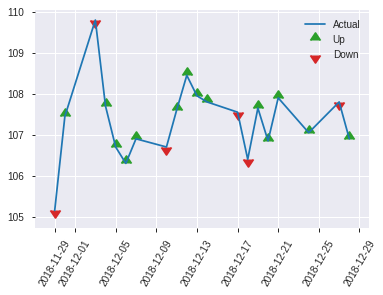


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20343692947988493
RMSE: 0.4510398313673471
LogLoss: 0.6037755960475164
Mean Per-Class Error: 0.2973110742959093
AUC: 0.7492035172677457
pr_auc: 0.7016502076106316
Gini: 0.4984070345354914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31838124990463257: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   69   0.5847   (69.0/118.0)
1      10   123  0.0752   (10.0/133.0)
Total  59   192  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318381     0.756923  190
max f2                       0.0973995    0.862516  237
max f0point5                 0.521292     0.718433  137
max accuracy                 0.521292     0.705179  137
max precision                0.764513     0.821429  55
max recall                   0.0973995    1         237
max specificity              0.948966     0.991525  0
max absolute_mcc             0.436018     0.410942  159
max min_per_class_accuracy   0.539775     0.684211  126
max mean_per_class_accuracy  0.521292     0.702689  137

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 52.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.926962           0         0                  0                0.939731  0                           0.939731            0               0                          -100      -100
    2        0.0239044                   0.909338           1.25815   0.629073           0.666667         0.915672  0.333333                    0.927701            0.0150376       0.0150376                  25.8145   -37.0927
    3        0.0318725                   0.897609           1.88722   0.943609           1                0.903822  0.5                         0.921731            0.0150376       0.0300752                  88.7218   -5.6391
    4        0.0438247                   0.874308           1.25815   1.02939            0.666667         0.882906  0.545455                    0.911143            0.0150376       0.0451128                  25.8145   2.93917
    5        0.0517928                   0.862279           0.943609  1.01619            0.5              0.866138  0.538462                    0.904219            0.0075188       0.0526316                  -5.6391   1.61943
    6        0.103586                    0.821299           1.74205   1.37912            0.923077         0.83581   0.730769                    0.870015            0.0902256       0.142857                   74.2047   37.9121
    7        0.151394                    0.787762           1.57268   1.44025            0.833333         0.799554  0.763158                    0.847764            0.075188        0.218045                   57.2682   44.0245
    8        0.203187                    0.768914           1.74205   1.51718            0.923077         0.776711  0.803922                    0.829652            0.0902256       0.308271                   74.2047   51.7175
    9        0.302789                    0.699102           1.3588    1.46508            0.72             0.743678  0.776316                    0.801371            0.135338        0.443609                   35.8797   46.5077
    10       0.40239                     0.616458           1.28331   1.42008            0.68             0.659492  0.752475                    0.766253            0.12782         0.571429                   28.3308   42.0085
    11       0.501992                    0.553113           1.05684   1.34801            0.56             0.582991  0.714286                    0.729891            0.105263        0.676692                   5.68421   34.8013
    12       0.601594                    0.461499           0.981353  1.28731            0.52             0.507772  0.682119                    0.693117            0.0977444       0.774436                   -1.86466  28.7308
    13       0.701195                    0.387507           0.905865  1.23313            0.48             0.428109  0.653409                    0.655474            0.0902256       0.864662                   -9.41353  23.3125
    14       0.800797                    0.267661           0.754887  1.17364            0.4              0.328968  0.621891                    0.614863            0.075188        0.93985                    -24.5113  17.3643
    15       0.900398                    0.14703            0.226466  1.06887            0.12             0.214728  0.566372                    0.570601            0.0225564       0.962406                   -77.3534  6.88669
    16       1                           0.0515933          0.377444  1                  0.2              0.10121   0.52988                     0.523849           

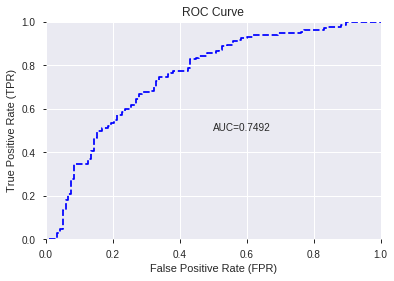

This function is available for GLM models only


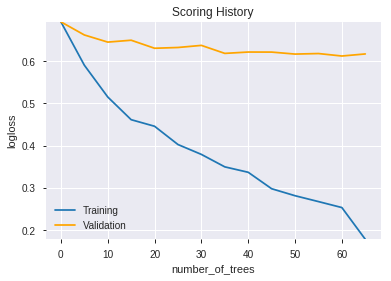

--2019-08-27 14:19:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_141900_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_141900_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'CCI_8',
 'STOCHF_fastk',
 'MOM_8',
 'CORREL_12',
 'TRANGE',
 'CMO_8',
 'SUB',
 'ULTOSC',
 'STOCHRSI_fastd',
 'DIV',
 'WILLR_12',
 'CCI_12',
 'WILLR_8',
 'ROC_8',
 'WILLR_20',
 'CMO_12',
 'WILLR_14',
 'WILLR_24',
 'STOCHRSI_fastk',
 'RSI_8',
 'RSI_12',
 'ROCP_8',
 'ROCR100_8',
 'ROCR_8',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

57

['BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_middleband_14_7_4',
 'BBANDS_upperband_30_2_3',
 'BOP',
 'aroonup_8',
 'CMO_8',
 'MINUS_DM_8',
 'MOM_8',
 'WILLR_8',
 'CCI_12',
 'MFI_12',
 'PLUS_DI_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'CCI_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'aroonup_20',
 'MACDFIX_20',
 'MACDFIX_signal_20',
 'MFI_20',
 'MINUS_DI_20',
 'MINUS_DM_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROCR100_20',
 'WILLR_20',
 'MFI_24',
 'PLUS_DI_24',
 'ROCR_24',
 'WILLR_24',
 'aroonup_30',
 'MINUS_DI_30',
 'ROCP_30',
 'WILLR_30',
 'MACDEXT_signal',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'OBV',
 'ATR_12',
 'ATR_20',
 'TRANGE',
 'HT_PHASOR_inphase',
 'CORREL_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'VAR_12',
 'CORREL_14',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14',
 'VAR_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_142148_model_8  0.711164  0.658049              0.302504  0.473161  0.223881
1               DeepLearning_1_AutoML_20190827_142148  0.708870  0.642985              0.366191  0.469503  0.220433
2  DeepLearning_grid_1_AutoML_20190827_142148_model_9  0.703326  0.629427              0.351090  0.468195  0.219206
3  DeepLearning_grid_1_AutoML_20190827_142148_model_3  0.694533  0.752041              0.356697  0.495212  0.245235
4  DeepLearning_grid_1_AutoML_20190827_142148_model_6  0.693705  0.634678              0.403912  0.470987  0.221828
5  DeepLearning_grid_1_AutoML_20190827_142148_model_1  0.681853  0.908519              0.406238  0.514983  0.265208
6  DeepLearning_grid_1_AutoML_20190827_142148_model_4  0.681088  0.728338              0.364279  0.495947  0.245964
7  DeepLearning_grid_1_AutoML_20190827_142148_model_2  0.677201  0.817406              0.365649  0.506973  0.257022
8  DeepLearning_grid_1_AutoML_20190827_142148_model_7  0.669173  0.700175              0.431662  0.495609  0.245629
9  DeepLearning_grid_1_AutoML_20190827_142148_model_5  0.653243  0.697052              0.385530  0.492899  0.242949

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.047304
1                     TRANGE             0.756612           0.756612    0.035791
2                  aroonup_8             0.441806           0.441806    0.020899
3               aroondown_14             0.435814           0.435814    0.020616
4                 aroonup_20             0.433159           0.433159    0.020490
5                   CORREL_8             0.432966           0.432966    0.020481
6                      MOM_8             0.426169           0.426169    0.020159
7                  CORREL_14             0.420468           0.420468    0.019890
8                     ULTOSC             0.415175           0.415175    0.019639
9             STOCHRSI_fastk             0.412590           0.412590    0.019517
10              STOCHF_fastk             0.404042           0.404042    0.019113
11                aroonup_14             0.403075           0.403075    0.019067
12         HT_PHASOR_inphase             0.395831           0.395831    0.018724
13                aroonup_30             0.371747           0.371747    0.017585
14                    CCI_12             0.370979           0.370979    0.017549
15              aroondown_20             0.370270           0.370270    0.017515
16               MINUS_DI_30             0.370052           0.370052    0.017505
17         LINEARREG_ANGLE_8             0.369089           0.369089    0.017459
18            STOCHRSI_fastd             0.367002           0.367002    0.017361
19                    MFI_24             0.364151           0.364151    0.017226
20                  WILLR_14             0.360077           0.360077    0.017033
21               MINUS_DI_20             0.359300           0.359300    0.016996
22               STOCH_slowk             0.358016           0.358016    0.016936
23                   ROCP_30             0.357034           0.357034    0.016889
24                   WILLR_8             0.356472           0.356472    0.016863
25                    MFI_12             0.350294           0.350294    0.016570
26                    ATR_12             0.349034           0.349034    0.016511
27            MACDEXT_signal             0.348426           0.348426    0.016482
28                       OBV             0.347119           0.347119    0.016420
29                  WILLR_30             0.345957           0.345957    0.016365
30         LINEARREG_SLOPE_8             0.344047           0.344047    0.016275
31         MACDFIX_signal_20             0.343924           0.343924    0.016269
32                   ROCR_24             0.342806           0.342806    0.016216
33                PLUS_DI_24             0.338655           0.338655    0.016020
34                PLUS_DI_20             0.336468           0.336468    0.015916
35   BBANDS_lowerband_14_5_5             0.336452           0.336452    0.015916
36                    MOM_20             0.335510           0.335510    0.015871
37                    VAR_14             0.334201           0.334201    0.015809
38                  WILLR_24             0.333764           0.333764    0.015788
39                    ATR_20             0.333626           0.333626    0.015782
40                MINUS_DM_8             0.332638           0.332638    0.015735
41                ROCR100_20             0.331897           0.331897    0.015700
42                PLUS_DI_12             0.330354           0.330354    0.015627
43   BBANDS_lowerband_14_7_3             0.327746           0.327746    0.015504
44                    VAR_12             0.320943           0.320943    0.015182
45               MINUS_DM_20             0.319720           0.319720    0.015124
46   BBANDS_upperband_30_2_3             0.317531           0.317531    0.015020
47  BBANDS_middleband_14_7_4             0.317390           0.317390    0.015014
48                    MFI_20             0.317011  

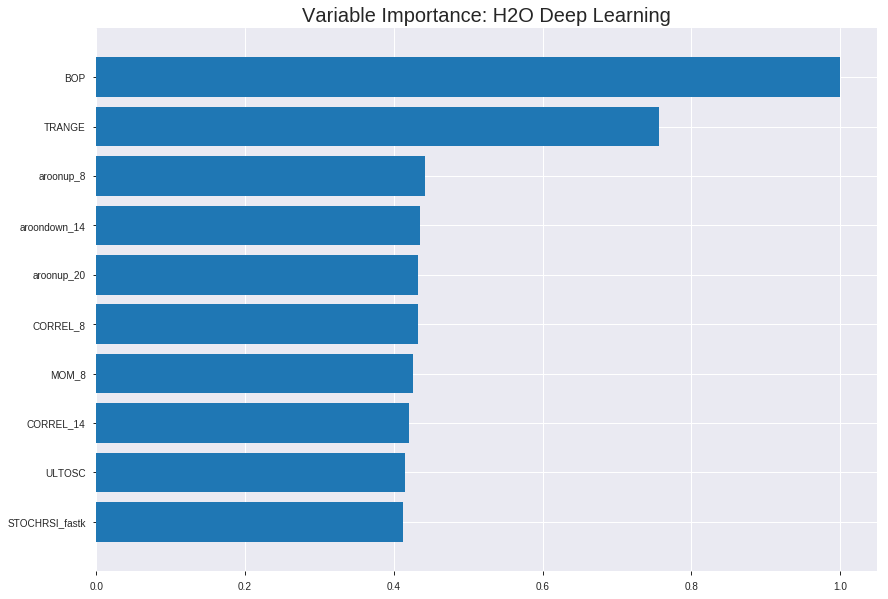

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_142148_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1973749897228349
RMSE: 0.4442690510522142
LogLoss: 0.5777744484277777
Mean Per-Class Error: 0.29617734208774427
AUC: 0.7558100223211373
pr_auc: 0.7249472222643609
Gini: 0.5116200446422745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36924529260463124: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      366  464   0.559    (464.0/830.0)
1      70   853   0.0758   (70.0/923.0)
Total  436  1317  0.3046   (534.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369245     0.761607  270
max f2                       0.156757     0.865312  343
max f0point5                 0.500768     0.713861  207
max accuracy                 0.49544      0.7085    210
max precision                0.914956     1         0
max recall                   0.047358     1         386
max specificity              0.914956     1         0
max absolute_mcc             0.369245     0.42174   270
max min_per_class_accuracy   0.545994     0.691566  182
max mean_per_class_accuracy  0.49544      0.703823  210

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 51.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.881033           1.5827    1.5827             0.833333         0.894793   0.833333                    0.894793            0.0162514       0.0162514                  58.2701   58.2701
    2        0.0205362                   0.859906           1.37167   1.47719            0.722222         0.869855   0.777778                    0.882324            0.0140845       0.0303359                  37.1674   47.7188
    3        0.0302339                   0.853132           1.45236   1.46922            0.764706         0.856745   0.773585                    0.874119            0.0140845       0.0444204                  45.2361   46.9225
    4        0.040502                    0.844795           1.47719   1.47124            0.777778         0.848068   0.774648                    0.867515            0.0151679       0.0595883                  47.7188   47.1243
    5        0.0501997                   0.836259           1.56408   1.48918            0.823529         0.840126   0.784091                    0.862224            0.0151679       0.0747562                  56.4081   48.9178
    6        0.100399                    0.793623           1.40285   1.44601            0.738636         0.813787   0.761364                    0.838006            0.0704225       0.145179                   40.2849   44.6013
    7        0.150029                    0.759476           1.41897   1.43707            0.747126         0.774836   0.756654                    0.817109            0.0704225       0.215601                   41.8974   43.7069
    8        0.200228                    0.723729           1.48918   1.45013            0.784091         0.741398   0.763533                    0.798127            0.0747562       0.290358                   48.9178   45.0133
    9        0.300057                    0.665812           1.36745   1.42263            0.72             0.692646   0.749049                    0.763034            0.136511        0.426869                   36.7454   42.2626
    10       0.399886                    0.609656           1.30234   1.3926             0.685714         0.636121   0.733238                    0.731351            0.130011        0.55688                    30.2337   39.2597
    11       0.500285                    0.551745           1.23019   1.36               0.647727         0.583662   0.716078                    0.701712            0.12351         0.68039                    23.0191   36.0004
    12       0.600114                    0.494129           1.12869   1.32153            0.594286         0.522359   0.695817                    0.671877            0.112676        0.793066                   12.8692   32.1526
    13       0.699943                    0.423869           0.824813  1.25068            0.434286         0.46117    0.658517                    0.641825            0.0823402       0.875406                   -17.5187  25.0682
    14       0.799772                    0.316218           0.748844  1.18804            0.394286         0.370206   0.625535                    0.607921            0.0747562       0.950163                   -25.1156  18.8042
    15       0.899601                    0.148139           0.368996  1.09715            0.194286         0.236724   0.577679                    0.566729            0.0368364       0.986999                   -63.1004  9.71523
    16       1                           0.0023407          0.129494  1                  0.0681818        0.0811664  0.526526                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2111770268736944
RMSE: 0.4595400166184599
LogLoss: 0.622246970879245
Mean Per-Class Error: 0.31170280612244894
AUC: 0.7385762117346939
pr_auc: 0.7390390548635642
Gini: 0.4771524234693878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23453729059546857: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   159  0.649    (159.0/245.0)
1      26   230  0.1016   (26.0/256.0)
Total  112  389  0.3693   (185.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.234537     0.713178  309
max f2                       0.111338     0.845687  364
max f0point5                 0.483091     0.694444  202
max accuracy                 0.483091     0.688623  202
max precision                0.874939     1         0
max recall                   0.00153509   1         399
max specificity              0.874939     1         0
max absolute_mcc             0.483091     0.376775  202
max min_per_class_accuracy   0.487343     0.677551  198
max mean_per_class_accuracy  0.483091     0.688297  202

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 46.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.851013           1.95703   1.95703            1                0.86186    1                           0.86186             0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.834596           1.56563   1.77912            0.8              0.841178   0.909091                    0.852459            0.015625        0.0390625                  56.5625   77.9119
    3        0.0319361                   0.819178           1.56563   1.7124             0.8              0.827221   0.875                       0.844572            0.015625        0.0546875                  56.5625   71.2402
    4        0.0419162                   0.814877           1.95703   1.77065            1                0.81664    0.904762                    0.837922            0.0195312       0.0742188                  95.7031   77.0647
    5        0.0518962                   0.801765           1.95703   1.80649            1                0.809062   0.923077                    0.832372            0.0195312       0.09375                    95.7031   80.649
    6        0.101796                    0.764121           1.56563   1.68842            0.8              0.781363   0.862745                    0.807367            0.078125        0.171875                   56.5625   68.8419
    7        0.151697                    0.715626           1.48734   1.62228            0.76             0.736951   0.828947                    0.784204            0.0742188       0.246094                   48.7344   62.2276
    8        0.201597                    0.685406           1.48734   1.58888            0.76             0.698973   0.811881                    0.763107            0.0742188       0.320312                   48.7344   58.8877
    9        0.301397                    0.613253           1.2525    1.47749            0.64             0.645019   0.754967                    0.724005            0.125           0.445312                   25.25     47.7494
    10       0.401198                    0.537913           1.2525    1.42153            0.64             0.578568   0.726368                    0.687827            0.125           0.570312                   25.25     42.1525
    11       0.500998                    0.489318           1.0568    1.34887            0.54             0.51069    0.689243                    0.652541            0.105469        0.675781                   5.67969   34.887
    12       0.600798                    0.435505           0.900234  1.27435            0.46             0.465133   0.651163                    0.62141             0.0898438       0.765625                   -9.97656  27.4346
    13       0.700599                    0.342651           0.704531  1.19318            0.36             0.389866   0.609687                    0.588426            0.0703125       0.835938                   -29.5469  19.3176
    14       0.800399                    0.210189           0.704531  1.13225            0.36             0.275878   0.578554                    0.549455            0.0703125       0.90625                    -29.5469  13.2248
    15       0.9002                      0.118283           0.62625   1.07615            0.32             0.16204    0.549889                    0.506504            0.0625          0.96875                    -37.375   7.61502
    16       1                           0.00153509         0.313125  1                  0.16             0.0665893  0.510978                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:27:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:27:46  1 min 22.179 sec  540 obs/sec       0.501997  1             880        0.512048         0.755583            -0.0517337     0.643431        0.637244           1.5827           0.397034                         0.509743           0.741293              -0.039855        0.680827          0.660665             1.63086            0.367265
    2019-08-27 14:27:58  1 min 34.025 sec  867 obs/sec       6.10154   12            10696      0.468949         0.629351            0.117864       0.723306        0.703878           1.47719          0.35482                          0.466818           0.625512              0.127904         0.738417          0.733833             1.63086            0.347305
    2019-08-27 14:28:09  1 min 45.625 sec  987 obs/sec       12.8397   25            22508      0.461208         0.613625            0.146746       0.727804        0.714981           1.68821          0.335995                         0.46741            0.627049              0.125691         0.722361          0.719468             1.63086            0.40519
    2019-08-27 14:28:21  1 min 57.033 sec  1059 obs/sec      20.0051   39            35069      0.456672         0.605139            0.163446       0.741132        0.71709            1.5827           0.338848                         0.469411           0.632878              0.118188         0.729377          0.731942             1.63086            0.39521
    2019-08-27 14:28:32  2 min  8.402 sec  1121 obs/sec      27.7125   54            48580      0.444269         0.577774            0.208272       0.75581         0.724947           1.5827           0.304621                         0.45954            0.622247              0.154884         0.738576          0.739039             1.95703            0.369261
    2019-08-27 14:28:44  2 min 20.035 sec  1171 obs/sec      35.9817   70            63076      0.440497         0.568317            0.22166        0.770069        0.756304           1.68821          0.298916                         0.473281           0.661                 0.10359          0.725486          0.731557             1.95703            0.357285
    2019-08-27 14:28:55  2 min 31.255 sec  1210 obs/sec      44.1375   86            77373      0.435543         0.556945            0.239067       0.782745        0.779296           1.89924          0.29093                          0.471187           0.654447              0.111503         0.727105          0.735026             1.63086            0.373253
    2019-08-27 14:28:56  2 min 32.439 sec  1209 obs/sec      44.1375   86            77373      0.444269         0.577774            0.208272       0.75581         0.724947           1.5827           0.304621                         0.45954            0.622247              0.154884         0.738576          0.739039             1.95703            0.369261

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
BOP           1.0                    1.0                  0.04730398087634384
TRANGE        0.7566121816635132     0.7566121816635132   0.03579076817221962
aroonup_8     0.4418056011199951     0.4418056011199951   0.020899163706441844
aroondown_14  0.4358140230178833     0.4358140230178833   0.020615738210480426
aroonup_20    0.4331589639186859     0.4331589639186859   0.02049014334562643
---           ---                    ---                  ---
WILLR_20      0.29469239711761475    0.29469239711761475  0.013940123517655573
WILLR_12      0.289793998003006      0.289793998003006    0.01370840973961342
RSI_14        0.28342628479003906    0.28342628479003906  0.013407191555561191
MACDFIX_20    0.2737025022506714     0.2737025022506714   0.012947217932273216
CMO_8         0.26811501383781433    0.26811501383781433  0.012682907487244634


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.7292418772563176)

('auc', 0.7111635019752771)

('logloss', 0.6580494852042459)

('mean_per_class_error', 0.2973110742959093)

('rmse', 0.4731611321243653)

('mse', 0.22388145695321104)

deeplearning prediction progress: |███████████████████████████████████████| 100%


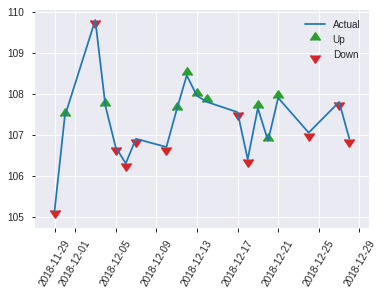


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22388145695321104
RMSE: 0.4731611321243653
LogLoss: 0.6580494852042459
Mean Per-Class Error: 0.2973110742959093
AUC: 0.7111635019752771
pr_auc: 0.7093078391916074
Gini: 0.4223270039505542
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.476397927163245: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   43   0.3644   (43.0/118.0)
1      32   101  0.2406   (32.0/133.0)
Total  107  144  0.2988   (75.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476398     0.729242  143
max f2                       0.0388047    0.855856  244
max f0point5                 0.487371     0.718433  138
max accuracy                 0.487371     0.705179  138
max precision                0.931276     1         0
max recall                   0.0388047    1         244
max specificity              0.931276     1         0
max absolute_mcc             0.487371     0.407015  138
max min_per_class_accuracy   0.538789     0.661654  121
max mean_per_class_accuracy  0.487371     0.702689  138

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 48.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.887887           1.25815   1.25815            0.666667         0.917153   0.666667                    0.917153            0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.865954           1.25815   1.25815            0.666667         0.871723   0.666667                    0.894438            0.0150376       0.0300752                  25.8145   25.8145
    3        0.0318725                   0.851667           1.88722   1.41541            1                0.85757    0.75                        0.885221            0.0150376       0.0451128                  88.7218   41.5414
    4        0.0438247                   0.843967           1.88722   1.54409            1                0.845337   0.818182                    0.874344            0.0225564       0.0676692                  88.7218   54.4087
    5        0.0517928                   0.836841           0.943609  1.45171            0.5              0.83816    0.769231                    0.868777            0.0075188       0.075188                   -5.6391   45.1706
    6        0.103586                    0.784292           1.74205   1.59688            0.923077         0.805108   0.846154                    0.836943            0.0902256       0.165414                   74.2047   59.6877
    7        0.151394                    0.751986           1.25815   1.48991            0.666667         0.767071   0.789474                    0.814878            0.0601504       0.225564                   25.8145   48.9909
    8        0.203187                    0.71917            1.45171   1.48017            0.769231         0.734974   0.784314                    0.79451             0.075188        0.300752                   45.1706   48.0171
    9        0.302789                    0.663522           1.28331   1.41541            0.68             0.688049   0.75                        0.75949             0.12782         0.428571                   28.3308   41.5414
    10       0.40239                     0.591321           1.28331   1.38271            0.68             0.627987   0.732673                    0.72694             0.12782         0.556391                   28.3308   38.2714
    11       0.501992                    0.52513            1.05684   1.31806            0.56             0.561135   0.698413                    0.694042            0.105263        0.661654                   5.68421   31.8057
    12       0.601594                    0.459041           0.981353  1.26231            0.52             0.489896   0.668874                    0.660243            0.0977444       0.759398                   -1.86466  26.2311
    13       0.701195                    0.328907           0.60391   1.16879            0.32             0.397311   0.619318                    0.622895            0.0601504       0.819549                   -39.609   16.8788
    14       0.800797                    0.230254           0.452932  1.07975            0.24             0.280429   0.572139                    0.5803              0.0451128       0.864662                   -54.7068  7.97516
    15       0.900398                    0.126343           0.679398  1.03546            0.36             0.177859   0.548673                    0.535782            0.0676692       0.932331                   -32.0602  3.54648
    16       1                           0.00975138         0.679398  1                  0.36             0.0650574  0.52988                    

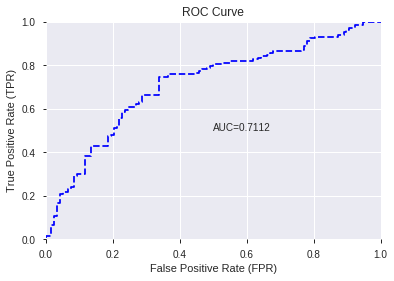

This function is available for GLM models only


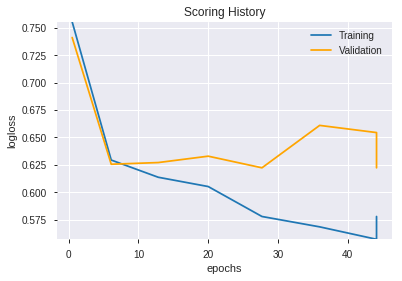

--2019-08-27 14:30:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_142148_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_142148_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'aroonup_8',
 'aroondown_14',
 'aroonup_20',
 'CORREL_8',
 'MOM_8',
 'CORREL_14',
 'ULTOSC',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'aroonup_14',
 'HT_PHASOR_inphase',
 'aroonup_30',
 'CCI_12',
 'aroondown_20',
 'MINUS_DI_30',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastd',
 'MFI_24',
 'WILLR_14',
 'MINUS_DI_20',
 'STOCH_slowk',
 'ROCP_30',
 'WILLR_8',
 'MFI_12',
 'ATR_12',
 'MACDEXT_signal',
 'OBV',
 'WILLR_30',
 'LINEARREG_SLOPE_8',
 'MACDFIX_signal_20',
 'ROCR_24',
 'PLUS_DI_24',
 'PLUS_DI_20',
 'BBANDS_lowerband_14_5_5',
 'MOM_20',
 'VAR_14',
 'WILLR_24',
 'ATR_20',
 'MINUS_DM_8',
 'ROCR100_20',
 'PLUS_DI_12',
 'BBANDS_lowerband_14_7_3',
 'VAR_12',
 'MINUS_DM_20',
 'BBANDS_upperband_30_2_3',
 'BBANDS_middleband_14_7_4',
 'MFI_20',
 'LINEARREG_ANGLE_14',
 'CCI_14',
 'LINEARREG_SLOPE_14',
 'WILLR_20',
 'WILLR_12',
 'RSI_14',
 'MACDFIX_20',
 'CMO_8']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_143023_model_1  0.713202  0.623306               0.33414  0.464072  0.215363

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.604633           1.000000    0.081217
1                      MOM_8             0.408135           0.675013    0.054822
2                     TRANGE             0.398897           0.659734    0.053581
3                   WILLR_14             0.350704           0.580029    0.047108
4                STOCH_slowk             0.335164           0.554327    0.045021
5             STOCHRSI_fastk             0.295126           0.488108    0.039642
6             STOCHRSI_fastd             0.287206           0.475008    0.038579
7                 MINUS_DM_8             0.274619           0.454192    0.036888
8                     CCI_12             0.258656           0.427790    0.034744
9               STOCHF_fastk             0.244428           0.404258    0.032832
10                   ROCP_30             0.202389           0.334730    0.027186
11                    MFI_20             0.200408           0.331454    0.026920
12                    RSI_14             0.171135           0.283040    0.022988
13                    VAR_14             0.169541           0.280403    0.022773
14                aroonup_20             0.168510           0.278699    0.022635
15                    ULTOSC             0.166560           0.275474    0.022373
16                    MOM_20             0.153348           0.253622    0.020598
17                 aroonup_8             0.143140           0.236739    0.019227
18         LINEARREG_ANGLE_8             0.139804           0.231221    0.018779
19        LINEARREG_SLOPE_14             0.135335           0.223830    0.018179
20                MACDFIX_20             0.122855           0.203189    0.016502
21            MACDEXT_signal             0.121113           0.200308    0.016268
22                  CORREL_8             0.119604           0.197813    0.016066
23              aroondown_14             0.117357           0.194097    0.015764
24               MINUS_DI_20             0.116974           0.193463    0.015712
25                PLUS_DI_12             0.112471           0.186015    0.015108
26                   WILLR_8             0.111932           0.185124    0.015035
27        LINEARREG_ANGLE_14             0.107999           0.178619    0.014507
28                    VAR_12             0.107390           0.177612    0.014425
29                   ROCR_24             0.104515           0.172857    0.014039
30                    MFI_24             0.096629           0.159815    0.012980
31                     CMO_8             0.095549           0.158028    0.012834
32                aroonup_14             0.078380           0.129633    0.010528
33                    ATR_12             0.074040           0.122455    0.009945
34                    ATR_20             0.072394           0.119732    0.009724
35               MINUS_DM_20             0.069719           0.115307    0.009365
36               MINUS_DI_30             0.067502           0.111642    0.009067
37   BBANDS_lowerband_14_5_5             0.055116           0.091156    0.007403
38                 CORREL_14             0.054097           0.089472    0.007267
39                    CCI_14             0.050157           0.082954    0.006737
40                PLUS_DI_24             0.048754           0.080634    0.006549
41                  WILLR_20             0.047750           0.078973    0.006414
42         HT_PHASOR_inphase             0.046562           0.077009    0.006254
43                ROCR100_20             0.045881           0.075883    0.006163
44         MACDFIX_signal_20             0.040811           0.067498    0.005482
45                  WILLR_12             0.031879           0.052725    0.004282
46                aroonup_30             0.028519           0.047167    0.003831
47              aroondown_20             0.027371           0.045268    0.003677
48  BBANDS_middleband_14_7_4             0.026792  

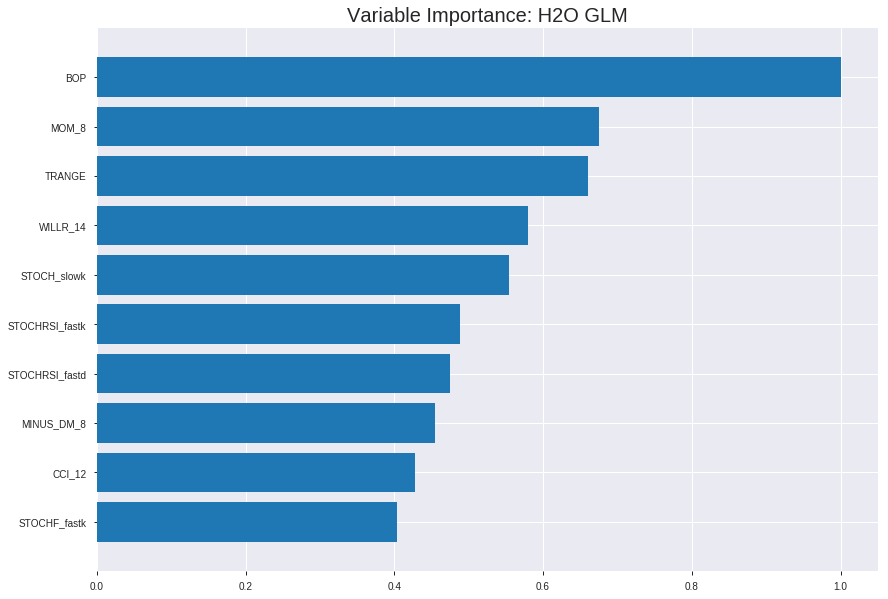

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_143023_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20558393813051196
RMSE: 0.4534136501369494
LogLoss: 0.5982243337112509
Null degrees of freedom: 1752
Residual degrees of freedom: 1695
Null deviance: 2425.2378703291097
Residual deviance: 2097.374513991646
AIC: 2213.374513991646
AUC: 0.738562048845436
pr_auc: 0.7219349584454564
Gini: 0.47712409769087194
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36982055858463425: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      334  496   0.5976   (496.0/830.0)
1      89   834   0.0964   (89.0/923.0)
Total  423  1330  0.3337   (585.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369821     0.740346  275
max f2                       0.179531     0.854023  356
max f0point5                 0.560552     0.701574  177
max accuracy                 0.503953     0.690816  205
max precision                0.825025     0.86      18
max recall                   0.119138     1         376
max specificity              0.926733     0.998795  0
max absolute_mcc             0.503953     0.3785    205
max min_per_class_accuracy   0.550576     0.678223  181
max mean_per_class_accuracy  0.514147     0.687398  201

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.853512           1.37167   1.37167            0.722222         0.865797  0.722222                    0.865797            0.0140845       0.0140845                  37.1674   37.1674
    2        0.0205362                   0.835109           1.89924   1.63546            1                0.841833  0.861111                    0.853815            0.0195016       0.0335861                  89.9242   63.5458
    3        0.0302339                   0.822069           1.56408   1.61256            0.823529         0.8277    0.849057                    0.845438            0.0151679       0.0487541                  56.4081   61.2564
    4        0.040502                    0.810424           1.37167   1.55149            0.722222         0.815919  0.816901                    0.837955            0.0140845       0.0628386                  37.1674   55.1493
    5        0.0501997                   0.8005             1.22892   1.48918            0.647059         0.804844  0.784091                    0.831558            0.0119177       0.0747562                  22.8921   48.9178
    6        0.100399                    0.767101           1.51076   1.49997            0.795455         0.784677  0.789773                    0.808117            0.0758397       0.150596                   51.076    49.9969
    7        0.150029                    0.739427           1.59362   1.53095            0.83908          0.753661  0.806084                    0.790103            0.0790899       0.229686                   59.3617   53.0948
    8        0.200228                    0.714324           1.16544   1.43931            0.613636         0.726448  0.757835                    0.774144            0.0585049       0.288191                   16.5444   43.9311
    9        0.300057                    0.667285           1.41087   1.42985            0.742857         0.69115   0.752852                    0.746532            0.140845        0.429036                   41.0865   42.9847
    10       0.399886                    0.618491           1.26978   1.38989            0.668571         0.642346  0.731812                    0.720523            0.126761        0.555796                   26.9779   38.9887
    11       0.500285                    0.555751           1.16544   1.34484            0.613636         0.588982  0.708096                    0.694125            0.11701         0.672806                   16.5444   34.4845
    12       0.600114                    0.486221           1.00931   1.28903            0.531429         0.52128   0.678707                    0.665372            0.100758        0.773564                   0.931125  28.9029
    13       0.699943                    0.414846           0.813961  1.22127            0.428571         0.447367  0.643032                    0.634279            0.0812568       0.854821                   -18.6039  22.1273
    14       0.799772                    0.336452           0.737991  1.16095            0.388571         0.376851  0.61127                     0.602147            0.0736728       0.928494                   -26.2009  16.0949
    15       0.899601                    0.236524           0.434112  1.08029            0.228571         0.283947  0.568802                    0.566836            0.0433369       0.971831                   -56.5888  8.02915
    16       1                           0.00521163         0.28057   1                  0.147727         0.165339  0.526526                    0.526526         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20031267258078744
RMSE: 0.44756303754978183
LogLoss: 0.5899105865643105
Null degrees of freedom: 500
Residual degrees of freedom: 443
Null deviance: 694.7772912382
Residual deviance: 591.0904077374391
AIC: 707.0904077374391
AUC: 0.7637755102040816
pr_auc: 0.7722998651550749
Gini: 0.5275510204081633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3614046608175809: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  128  0.5224   (128.0/245.0)
1      35   221  0.1367   (35.0/256.0)
Total  152  349  0.3253   (163.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361405     0.730579  275
max f2                       0.186651     0.851279  363
max f0point5                 0.569913     0.720974  155
max accuracy                 0.569913     0.698603  155
max precision                0.8671       1         0
max recall                   0.00620834   1         399
max specificity              0.8671       1         0
max absolute_mcc             0.569913     0.408884  155
max min_per_class_accuracy   0.513254     0.691406  195
max mean_per_class_accuracy  0.569913     0.700781  155

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 48.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.821898           1.95703   1.95703            1                0.840614  1                           0.840614            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.816708           1.95703   1.95703            1                0.818088  1                           0.830375            0.0195312       0.0429688                  95.7031   95.7031
    3        0.0319361                   0.804844           1.95703   1.95703            1                0.809408  1                           0.823823            0.0195312       0.0625                     95.7031   95.7031
    4        0.0419162                   0.795483           1.95703   1.95703            1                0.801505  1                           0.818509            0.0195312       0.0820312                  95.7031   95.7031
    5        0.0518962                   0.77814            1.95703   1.95703            1                0.781445  1                           0.811381            0.0195312       0.101562                   95.7031   95.7031
    6        0.101796                    0.740916           1.40906   1.68842            0.72             0.759162  0.862745                    0.785784            0.0703125       0.171875                   40.9063   68.8419
    7        0.151697                    0.711542           1.72219   1.69953            0.88             0.72368   0.868421                    0.765355            0.0859375       0.257812                   72.2188   69.9527
    8        0.201597                    0.677399           1.64391   1.68576            0.84             0.693861  0.861386                    0.747658            0.0820312       0.339844                   64.3906   68.576
    9        0.301397                    0.630235           1.29164   1.55526            0.66             0.654072  0.794702                    0.716669            0.128906        0.46875                    29.1641   55.5257
    10       0.401198                    0.569959           1.2525    1.47994            0.64             0.601352  0.756219                    0.687984            0.125           0.59375                    25.25     47.9944
    11       0.500998                    0.514607           0.939375  1.37226            0.48             0.547497  0.701195                    0.659998            0.09375         0.6875                     -6.0625   37.2261
    12       0.600798                    0.43695            0.704531  1.26134            0.36             0.476952  0.644518                    0.629592            0.0703125       0.757812                   -29.5469  26.1342
    13       0.700599                    0.359778           1.0568    1.2322             0.54             0.392818  0.62963                     0.595863            0.105469        0.863281                   5.67969   23.2205
    14       0.800399                    0.294285           0.62625   1.15665            0.32             0.325804  0.591022                    0.56219             0.0625          0.925781                   -37.375   15.6649
    15       0.9002                      0.207611           0.508828  1.08483            0.26             0.257122  0.554324                    0.528369            0.0507812       0.976562                   -49.1172  8.48289
    16       1                           0.00620834         0.234844  1                  0.12             0.142075  0.510978                    0.489817          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:30:23  0.000 sec   2            .17E2     58            1.3718719733750466  1.3760478813722739
     2019-08-27 14:30:23  0.015 sec   4            .11E2     58            1.3662602193273619  1.3706123468298632
     2019-08-27 14:30:23  0.030 sec   6            .66E1     58            1.3585727983222649  1.3629410371856472
     2019-08-27 14:30:23  0.044 sec   8            .41E1     58            1.3484576078626846  1.352502114880367
     2019-08-27 14:30:23  0.062 sec   10           .25E1     58            1.3357748422102291  1.3389872968114074
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:30:24  0.284 sec   38           .32E-2    58            1.194225920097773   1.1801700962947947
     2019-08-27 14:30:24  0.300 sec   40           .2E-2     58            1.1925224511797858  1.1809909709598898
     2019-08-27 14:30:24  0.315 sec   42           .12E-2    58            1.1911734297775662  1.1817987065790458
     2019-08-27 14:30:24  0.331 sec   44           .77E-3    58            1.1900557314910134  1.182356167032269
     2019-08-27 14:30:24  0.346 sec   46           .48E-3    58            1.1891000529459292  1.1826359692942858


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.7378640776699029)

('auc', 0.7132024977698483)

('logloss', 0.6233062417846597)

('mean_per_class_error', 0.29587740537785145)

('rmse', 0.4640717369857299)

('mse', 0.21536257706895245)

glm prediction progress: |████████████████████████████████████████████████| 100%


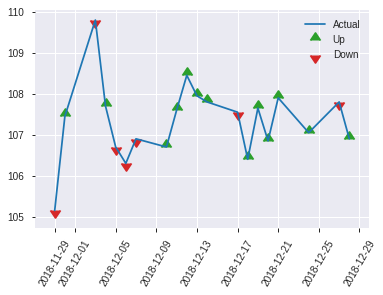


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21536257706895245
RMSE: 0.4640717369857299
LogLoss: 0.6233062417846597
Null degrees of freedom: 250
Residual degrees of freedom: 193
Null deviance: 347.07426846610866
Residual deviance: 312.89973337589913
AIC: 428.89973337589913
AUC: 0.7132024977698483
pr_auc: 0.6974675417931624
Gini: 0.4264049955396967
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3663097121063854: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   62   0.5254   (62.0/118.0)
1      19   114  0.1429   (19.0/133.0)
Total  75   176  0.3227   (81.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36631      0.737864  175
max f2                       0.0938682    0.855856  244
max f0point5                 0.508745     0.721805  132
max accuracy                 0.508745     0.705179  132
max precision                0.880252     1         0
max recall                   0.0938682    1         244
max specificity              0.880252     1         0
max absolute_mcc             0.508745     0.408245  132
max min_per_class_accuracy   0.51452      0.686441  128
max mean_per_class_accuracy  0.508745     0.704123  132

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.849847           1.88722   1.88722            1                0.869947  1                           0.869947            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.835213           1.88722   1.88722            1                0.840897  1                           0.855422            0.0225564       0.0451128                  88.7218   88.7218
    3        0.0318725                   0.81765            0.943609  1.65132            0.5              0.819798  0.875                       0.846516            0.0075188       0.0526316                  -5.6391   65.1316
    4        0.0438247                   0.802244           1.25815   1.54409            0.666667         0.810044  0.818182                    0.836569            0.0150376       0.0676692                  25.8145   54.4087
    5        0.0517928                   0.797564           0.943609  1.45171            0.5              0.799053  0.769231                    0.830797            0.0075188       0.075188                   -5.6391   45.1706
    6        0.103586                    0.762204           1.16136   1.30654            0.615385         0.780179  0.692308                    0.805488            0.0601504       0.135338                   16.1365   30.6536
    7        0.151394                    0.735642           1.25815   1.29125            0.666667         0.748107  0.684211                    0.787368            0.0601504       0.195489                   25.8145   29.1254
    8        0.203187                    0.695695           1.45171   1.33215            0.769231         0.718472  0.705882                    0.769806            0.075188        0.270677                   45.1706   33.2154
    9        0.302789                    0.648053           1.43429   1.36575            0.76             0.669781  0.723684                    0.736903            0.142857        0.413534                   43.4286   36.575
    10       0.40239                     0.592341           1.3588    1.36403            0.72             0.622946  0.722772                    0.708696            0.135338        0.548872                   35.8797   36.4029
    11       0.501992                    0.529027           1.3588    1.36299            0.72             0.553121  0.722222                    0.677828            0.135338        0.684211                   35.8797   36.2991
    12       0.601594                    0.452925           0.981353  1.29981            0.52             0.486182  0.688742                    0.646098            0.0977444       0.781955                   -1.86466  29.9806
    13       0.701195                    0.36631            0.754887  1.2224             0.4              0.399025  0.647727                    0.611003            0.075188        0.857143                   -24.5113  22.2403
    14       0.800797                    0.310372           0.377444  1.11731            0.2              0.335096  0.59204                     0.576686            0.037594        0.894737                   -62.2556  11.7308
    15       0.900398                    0.22781            0.60391   1.06052            0.32             0.267396  0.561947                    0.542472            0.0601504       0.954887                   -39.609   6.05163
    16       1                           0.0385427          0.452932  1                  0.24             0.141306  0.52988                     0.502516          

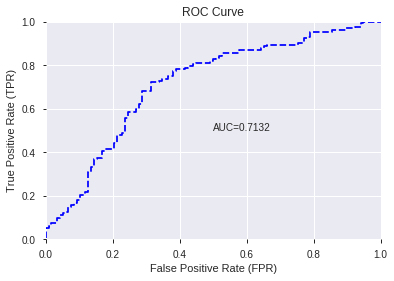

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


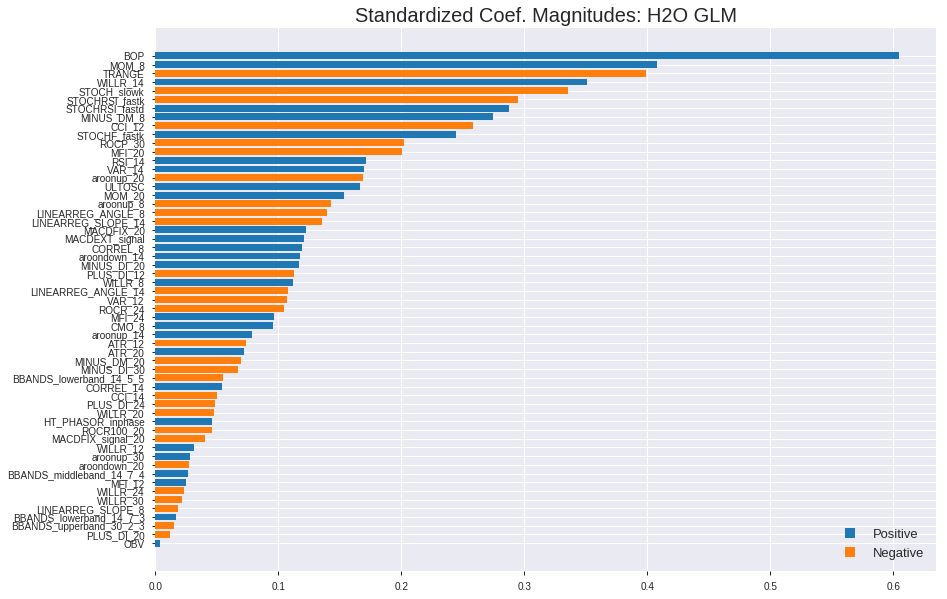

'log_likelihood'
--2019-08-27 14:30:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_143023_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_143023_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'MOM_8',
 'TRANGE',
 'WILLR_14',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'MINUS_DM_8',
 'CCI_12',
 'STOCHF_fastk',
 'ROCP_30',
 'MFI_20',
 'RSI_14',
 'VAR_14',
 'aroonup_20',
 'ULTOSC',
 'MOM_20',
 'aroonup_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_14',
 'MACDFIX_20',
 'MACDEXT_signal',
 'CORREL_8',
 'aroondown_14',
 'MINUS_DI_20',
 'PLUS_DI_12',
 'WILLR_8',
 'LINEARREG_ANGLE_14',
 'VAR_12',
 'ROCR_24',
 'MFI_24',
 'CMO_8',
 'aroonup_14',
 'ATR_12',
 'ATR_20',
 'MINUS_DM_20',
 'MINUS_DI_30',
 'BBANDS_lowerband_14_5_5',
 'CORREL_14',
 'CCI_14',
 'PLUS_DI_24',
 'WILLR_20',
 'HT_PHASOR_inphase',
 'ROCR100_20',
 'MACDFIX_signal_20',
 'WILLR_12',
 'aroonup_30',
 'aroondown_20',
 'BBANDS_middleband_14_7_4',
 'MFI_12',
 'WILLR_24',
 'WILLR_30',
 'LINEARREG_SLOPE_8',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_upperband_30_2_3',
 'PLUS_DI_20',
 'OBV']

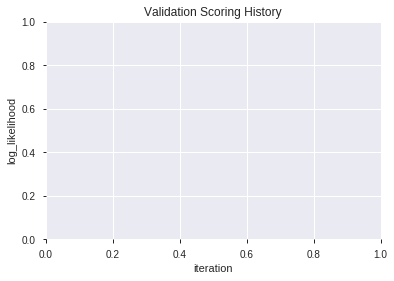

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_143035_model_4  0.736970  0.603810              0.342201  0.455477  0.207459
1  XGBoost_grid_1_AutoML_20190827_143035_model_3  0.731553  0.615099              0.320951  0.459957  0.211560
2  XGBoost_grid_1_AutoML_20190827_143035_model_2  0.731044  0.607278              0.347394  0.457445  0.209256
3               XGBoost_3_AutoML_20190827_143035  0.722378  0.613690              0.392156  0.459945  0.211549
4  XGBoost_grid_1_AutoML_20190827_143035_model_1  0.720976  0.610931              0.299223  0.459679  0.211305
5               XGBoost_1_AutoML_20190827_143035  0.717918  0.619141              0.303938  0.463004  0.214373
6  XGBoost_grid_1_AutoML_20190827_143035_model_6  0.717599  0.615854              0.346916  0.461584  0.213059
7               XGBoost_2_AutoML_20190827_143035  0.716516  0.620682              0.343571  0.463463  0.214798
8  XGBoost_grid_1_AutoML_20190827_143035_model_5  0.713585  0.631929              0.386485  0.466556  0.217675
9  XGBoost_grid_1_AutoML_20190827_143035_model_7  0.709061  0.622028              0.350198  0.464545  0.215802

variable  relative_importance  scaled_importance  percentage
0                        BOP          1518.385742           1.000000    0.321111
1                     TRANGE           321.723236           0.211885    0.068039
2               STOCHF_fastk           215.276459           0.141780    0.045527
3                    WILLR_8           167.392151           0.110243    0.035400
4                   CORREL_8           156.932419           0.103355    0.033188
5                    ROCP_30           141.825623           0.093406    0.029994
6                 PLUS_DI_12           120.797333           0.079556    0.025546
7                  aroonup_8           117.152878           0.077156    0.024776
8                  CORREL_14           107.335159           0.070690    0.022699
9          HT_PHASOR_inphase           105.057098           0.069190    0.022218
10            STOCHRSI_fastd           103.252464           0.068001    0.021836
11                MINUS_DM_8            94.589188           0.062296    0.020004
12                    ATR_12            91.397095           0.060194    0.019329
13                    MFI_24            77.779083           0.051225    0.016449
14            MACDEXT_signal            77.671318           0.051154    0.016426
15                    MFI_20            71.954002           0.047388    0.015217
16                    ULTOSC            70.255440           0.046270    0.014858
17                    MFI_12            69.131256           0.045529    0.014620
18                    CCI_12            64.927032           0.042761    0.013731
19               MINUS_DI_30            61.202641           0.040308    0.012943
20                aroonup_20            58.564487           0.038570    0.012385
21                    CCI_14            53.098671           0.034970    0.011229
22                    VAR_12            52.616219           0.034653    0.011127
23         LINEARREG_ANGLE_8            52.112797           0.034321    0.011021
24            STOCHRSI_fastk            48.840286           0.032166    0.010329
25                    ATR_20            45.439316           0.029926    0.009610
26                PLUS_DI_20            41.660305           0.027437    0.008810
27                     MOM_8            38.552887           0.025391    0.008153
28                    VAR_14            37.040806           0.024395    0.007833
29        LINEARREG_ANGLE_14            36.140766           0.023802    0.007643
30         MACDFIX_signal_20            35.097618           0.023115    0.007423
31                PLUS_DI_24            31.185600           0.020539    0.006595
32               MINUS_DI_20            30.204596           0.019893    0.006388
33   BBANDS_upperband_30_2_3            29.338823           0.019322    0.006205
34                    MOM_20            28.980644           0.019086    0.006129
35                aroonup_14            27.091463           0.017842    0.005729
36                MACDFIX_20            26.587517           0.017510    0.005623
37  BBANDS_middleband_14_7_4            24.814793           0.016343    0.005248
38                       OBV            24.163050           0.015914    0.005110
39               MINUS_DM_20            23.935154           0.015764    0.005062
40                   ROCR_24            21.447643           0.014125    0.004536
41                  WILLR_14            21.375036           0.014077    0.004520
42              aroondown_14            19.885881           0.013097    0.004206
43                     CMO_8            19.865395           0.013083    0.004201
44                ROCR100_20            19.573101           0.012891    0.004139
45                aroonup_30            19.304483           0.012714    0.004083
46   BBANDS_lowerband_14_7_3            19.024973           0.012530    0.004023
47   BBANDS_lowerband_14_5_5            17.662971           0.011633    0.003735
48               STOCH_slowk            14.997271  

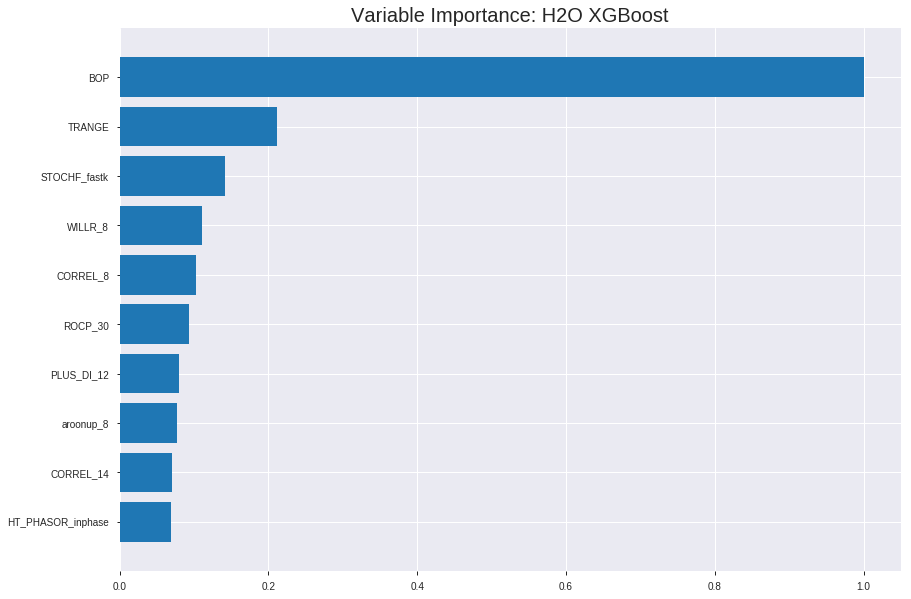

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_143035_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18557987461728817
RMSE: 0.4307898265016111
LogLoss: 0.554139216321799
Mean Per-Class Error: 0.2638488950384419
AUC: 0.808323434583404
pr_auc: 0.8178428647530621
Gini: 0.6166468691668081
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4308894693851471: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      432  398   0.4795   (398.0/830.0)
1      116  807   0.1257   (116.0/923.0)
Total  548  1205  0.2932   (514.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430889     0.758459  245
max f2                       0.258488     0.865916  333
max f0point5                 0.626273     0.759665  131
max accuracy                 0.583749     0.73417   158
max precision                0.835613     1         0
max recall                   0.175788     1         375
max specificity              0.835613     1         0
max absolute_mcc             0.583749     0.472219  158
max min_per_class_accuracy   0.555062     0.73253   174
max mean_per_class_accuracy  0.583749     0.736151  158

Gains/Lift Table: Avg response rate: 52.65 %, avg score: 52.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.802258           1.89924   1.89924            1                0.813133  1                           0.813133            0.0195016       0.0195016                  89.9242   89.9242
    2        0.0205362                   0.790629           1.79373   1.84648            0.944444         0.795504  0.972222                    0.804319            0.0184182       0.0379198                  79.3728   84.6485
    3        0.0302339                   0.781636           1.89924   1.86341            1                0.785414  0.981132                    0.798255            0.0184182       0.056338                   89.9242   86.3407
    4        0.040502                    0.771848           1.68821   1.81899            0.888889         0.776971  0.957746                    0.792859            0.0173348       0.0736728                  68.8215   81.8992
    5        0.0501997                   0.765677           1.6758    1.79133            0.882353         0.768417  0.943182                    0.788137            0.0162514       0.0899242                  67.5801   79.133
    6        0.100399                    0.744814           1.74817   1.76975            0.920455         0.755043  0.931818                    0.77159             0.0877573       0.177681                   74.8166   76.9748
    7        0.150029                    0.723324           1.63728   1.72593            0.862069         0.73394   0.908745                    0.759135            0.0812568       0.258938                   63.7277   72.5927
    8        0.200228                    0.702807           1.4676    1.66116            0.772727         0.713358  0.874644                    0.747659            0.0736728       0.332611                   46.7596   66.116
    9        0.300057                    0.668398           1.45428   1.59233            0.765714         0.684846  0.838403                    0.726761            0.145179        0.47779                    45.4276   59.233
    10       0.399886                    0.623657           1.3349    1.52806            0.702857         0.648089  0.804565                    0.707121            0.133261        0.611051                   33.4896   52.8063
    11       0.500285                    0.564387           1.05753   1.43364            0.556818         0.597431  0.754846                    0.685108            0.106176        0.717226                   5.75323   43.3635
    12       0.600114                    0.496885           0.868225  1.33958            0.457143         0.528808  0.705323                    0.659108            0.0866739       0.8039                     -13.1775  33.9579
    13       0.699943                    0.421932           0.759697  1.25687            0.4              0.458454  0.661777                    0.63049             0.0758397       0.87974                    -24.0303  25.6874
    14       0.799772                    0.327584           0.672874  1.18398            0.354286         0.379078  0.623395                    0.599108            0.0671723       0.946912                   -32.7126  18.3978
    15       0.899601                    0.247271           0.401554  1.09715            0.211429         0.287619  0.577679                    0.564542            0.0400867       0.986999                   -59.8446  9.71523
    16       1                           0.11482            0.129494  1                  0.0681818        0.192049  0.526526                    0.527144            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20235779452073688
RMSE: 0.44984196616227
LogLoss: 0.5915742396212875
Mean Per-Class Error: 0.29210778061224496
AUC: 0.7605787627551021
pr_auc: 0.7642665717516263
Gini: 0.5211575255102041
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42874133586883545: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  117  0.4776   (117.0/245.0)
1      38   218  0.1484   (38.0/256.0)
Total  166  335  0.3094   (155.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428741     0.737733  256
max f2                       0.222334     0.854558  371
max f0point5                 0.556877     0.722997  169
max accuracy                 0.556877     0.706587  169
max precision                0.810859     1         0
max recall                   0.205694     1         377
max specificity              0.810859     1         0
max absolute_mcc             0.556877     0.418212  169
max min_per_class_accuracy   0.533302     0.699219  191
max mean_per_class_accuracy  0.556877     0.707892  169

Gains/Lift Table: Avg response rate: 51.10 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.78572            1.95703   1.95703            1                0.795743  1                           0.795743            0.0234375       0.0234375                  95.7031   95.7031
    2        0.0219561                   0.765709           1.95703   1.95703            1                0.771385  1                           0.784671            0.0195312       0.0429688                  95.7031   95.7031
    3        0.0319361                   0.759803           1.95703   1.95703            1                0.762959  1                           0.777886            0.0195312       0.0625                     95.7031   95.7031
    4        0.0419162                   0.758217           1.95703   1.95703            1                0.758806  1                           0.773343            0.0195312       0.0820312                  95.7031   95.7031
    5        0.0518962                   0.748327           1.56563   1.88176            0.8              0.752499  0.961538                    0.769335            0.015625        0.0976562                  56.5625   88.1761
    6        0.101796                    0.720358           1.48734   1.68842            0.76             0.732349  0.862745                    0.751204            0.0742188       0.171875                   48.7344   68.8419
    7        0.151697                    0.698801           1.72219   1.69953            0.88             0.70739   0.868421                    0.736792            0.0859375       0.257812                   72.2188   69.9527
    8        0.201597                    0.665901           1.33078   1.60825            0.68             0.681187  0.821782                    0.723028            0.0664062       0.324219                   33.0781   60.8253
    9        0.301397                    0.628557           1.36992   1.52934            0.7              0.64604   0.781457                    0.697535            0.136719        0.460938                   36.9922   52.9336
    10       0.401198                    0.575592           1.29164   1.47021            0.66             0.602291  0.751244                    0.673843            0.128906        0.589844                   29.1641   47.0208
    11       0.500998                    0.533144           1.09594   1.39565            0.56             0.554231  0.713147                    0.650016            0.109375        0.699219                   9.59375   39.5652
    12       0.600798                    0.473503           0.782813  1.29385            0.4              0.506142  0.66113                     0.626116            0.078125        0.777344                   -21.7187  29.3851
    13       0.700599                    0.416321           0.861094  1.2322             0.44             0.440243  0.62963                     0.599639            0.0859375       0.863281                   -13.8906  23.2205
    14       0.800399                    0.333431           0.547969  1.14689            0.28             0.366583  0.586035                    0.57058             0.0546875       0.917969                   -45.2031  14.6889
    15       0.9002                      0.258292           0.391406  1.06313            0.2              0.292699  0.543237                    0.539772            0.0390625       0.957031                   -60.8594  6.31323
    16       1                           0.143088           0.430547  1                  0.22             0.203761  0.510978                    0.506238         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:30:45  3.810 sec   0                  0.5              0.693147            0.5             0                  1                0.473474                         0.5                0.693147              0.5               0                    1                  0.489022
    2019-08-27 14:30:46  3.923 sec   5                  0.483665         0.660876            0.747752        0.748056           1.68821          0.356532                         0.485657           0.664761              0.736727          0.697288             1.95703            0.357285
    2019-08-27 14:30:46  3.976 sec   10                 0.471854         0.637739            0.755388        0.746198           1.61436          0.34227                          0.474078           0.64204               0.753516          0.724945             1.95703            0.313373
    2019-08-27 14:30:46  4.054 sec   15                 0.464138         0.622536            0.764014        0.764021           1.68821          0.337707                         0.467972           0.629967              0.753827          0.738961             1.63086            0.301397
    2019-08-27 14:30:46  4.113 sec   20                 0.45752          0.609302            0.769005        0.770306           1.89924          0.338277                         0.462708           0.619397              0.755054          0.740512             1.95703            0.307385
    2019-08-27 14:30:46  4.175 sec   25                 0.452805         0.599736            0.773831        0.777484           1.89924          0.332002                         0.459123           0.612074              0.758139          0.749364             1.95703            0.291417
    2019-08-27 14:30:46  4.243 sec   30                 0.449385         0.592499            0.777121        0.782063           1.79373          0.336566                         0.456563           0.60663               0.759287          0.749746             1.95703            0.307385
    2019-08-27 14:30:46  4.309 sec   35                 0.446173         0.585788            0.780615        0.786228           1.89924          0.330861                         0.45513            0.603378              0.757254          0.748146             1.95703            0.315369
    2019-08-27 14:30:46  4.377 sec   40                 0.443126         0.579417            0.785039        0.794637           1.89924          0.324586                         0.453692           0.600264              0.75739           0.749219             1.95703            0.309381
    2019-08-27 14:30:46  4.445 sec   45                 0.440336         0.573622            0.789904        0.798137           1.89924          0.327439                         0.452469           0.597574              0.759335          0.754044             1.95703            0.319361
    2019-08-27 14:30:46  4.528 sec   50                 0.43781          0.568429            0.79541         0.806727           1.89924          0.325157                         0.452061           0.596646              0.759973          0.757291             1.95703            0.309381
    2019-08-27 14:30:46  4.604 sec   55                 0.435237         0.563176            0.799778        0.810054           1.89924          0.320593                         0.451291           0.594833              0.758873          0

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           1518.3857421875        1.0                   0.32111127887983826
TRANGE        321.7232360839844      0.21188504814361983   0.06803867878491386
STOCHF_fastk  215.27645874023438     0.14177982100259387   0.04552709964149747
WILLR_8       167.39215087890625     0.11024349493544941   0.03540042964690513
CORREL_8      156.9324188232422      0.10335477636740294   0.03318838441767644
---           ---                    ---                   ---
WILLR_30      14.428455352783203     0.009502496600104063  0.0030513588358107306
WILLR_12      14.281542778015137     0.009405740834631441  0.0030202894682208195
RSI_14        10.13363265991211      0.006673951406651672  0.002143081071371814
aroondown_20  8.606996536254883      0.00566851775350248   0.001820224985180249
WILLR_24      8.443646430969238      0.005560936326235974  0.001785679375486983


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7484662576687117)

('auc', 0.7369695425003187)

('logloss', 0.6038101462496172)

('mean_per_class_error', 0.30196253345227475)

('rmse', 0.45547672562795555)

('mse', 0.2074590475887639)

xgboost prediction progress: |████████████████████████████████████████████| 100%


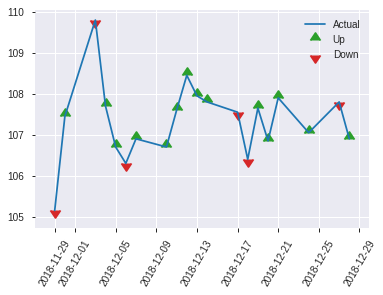


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2074590475887639
RMSE: 0.45547672562795555
LogLoss: 0.6038101462496172
Mean Per-Class Error: 0.30196253345227475
AUC: 0.7369695425003187
pr_auc: 0.7151057482600626
Gini: 0.4739390850006373
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3181290626525879: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   71   0.6017   (71.0/118.0)
1      11   122  0.0827   (11.0/133.0)
Total  58   193  0.3267   (82.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318129     0.748466  192
max f2                       0.205335     0.859375  235
max f0point5                 0.541145     0.718799  124
max accuracy                 0.541145     0.697211  124
max precision                0.811006     1         0
max recall                   0.164637     1         246
max specificity              0.811006     1         0
max absolute_mcc             0.440008     0.396433  164
max min_per_class_accuracy   0.533395     0.691729  126
max mean_per_class_accuracy  0.541145     0.698037  124

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 50.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.781869           1.88722   1.88722            1                0.796216  1                           0.796216            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.776517           1.25815   1.57268            0.666667         0.777516  0.833333                    0.786866            0.0150376       0.037594                   25.8145   57.2682
    3        0.0318725                   0.769742           1.88722   1.65132            1                0.772138  0.875                       0.783184            0.0150376       0.0526316                  88.7218   65.1316
    4        0.0438247                   0.766424           1.25815   1.54409            0.666667         0.767585  0.818182                    0.77893             0.0150376       0.0676692                  25.8145   54.4087
    5        0.0517928                   0.764549           0.943609  1.45171            0.5              0.765242  0.769231                    0.776824            0.0075188       0.075188                   -5.6391   45.1706
    6        0.103586                    0.744163           1.30654   1.37912            0.692308         0.752468  0.730769                    0.764646            0.0676692       0.142857                   30.6536   37.9121
    7        0.151394                    0.704135           1.41541   1.39058            0.75             0.726721  0.736842                    0.75267             0.0676692       0.210526                   41.5414   39.0582
    8        0.203187                    0.683566           1.30654   1.36916            0.692308         0.693686  0.72549                     0.737635            0.0676692       0.278195                   30.6536   36.9158
    9        0.302789                    0.622986           1.50977   1.41541            0.8              0.647926  0.75                        0.708125            0.150376        0.428571                   50.9774   41.5414
    10       0.40239                     0.579653           1.43429   1.42008            0.76             0.601824  0.752475                    0.681813            0.142857        0.571429                   43.4286   42.0085
    11       0.501992                    0.533755           1.13233   1.36299            0.6              0.556674  0.722222                    0.656984            0.112782        0.684211                   13.2331   36.2991
    12       0.601594                    0.470406           0.754887  1.26231            0.4              0.50473   0.668874                    0.631776            0.075188        0.759398                   -24.5113  26.2311
    13       0.701195                    0.387155           0.981353  1.2224             0.52             0.435926  0.647727                    0.603957            0.0977444       0.857143                   -1.86466  22.2403
    14       0.800797                    0.303099           0.679398  1.15486            0.36             0.33835   0.61194                     0.570921            0.0676692       0.924812                   -32.0602  15.4865
    15       0.900398                    0.23351            0.452932  1.07722            0.24             0.272512  0.570796                    0.537911            0.0451128       0.969925                   -54.7068  7.72174
    16       1                           0.142843           0.301955  1                  0.16             0.19378   0.52988                     0.503635         

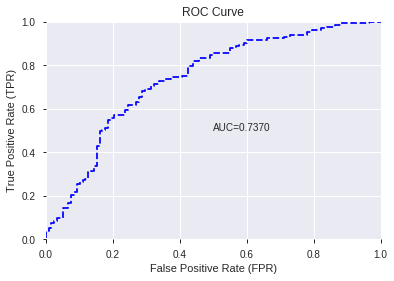

This function is available for GLM models only


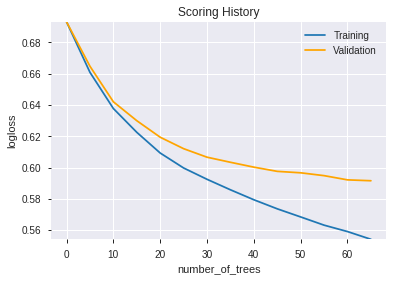

--2019-08-27 14:31:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_143035_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_143035_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9baf',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'WILLR_8',
 'CORREL_8',
 'ROCP_30',
 'PLUS_DI_12',
 'aroonup_8',
 'CORREL_14',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'MINUS_DM_8',
 'ATR_12',
 'MFI_24',
 'MACDEXT_signal',
 'MFI_20',
 'ULTOSC',
 'MFI_12',
 'CCI_12',
 'MINUS_DI_30',
 'aroonup_20',
 'CCI_14',
 'VAR_12',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastk',
 'ATR_20',
 'PLUS_DI_20',
 'MOM_8',
 'VAR_14',
 'LINEARREG_ANGLE_14',
 'MACDFIX_signal_20',
 'PLUS_DI_24',
 'MINUS_DI_20',
 'BBANDS_upperband_30_2_3',
 'MOM_20',
 'aroonup_14',
 'MACDFIX_20',
 'BBANDS_middleband_14_7_4',
 'OBV',
 'MINUS_DM_20',
 'ROCR_24',
 'WILLR_14',
 'aroondown_14',
 'CMO_8',
 'ROCR100_20',
 'aroonup_30',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_lowerband_14_5_5',
 'STOCH_slowk',
 'WILLR_30',
 'WILLR_12',
 'RSI_14',
 'aroondown_20',
 'WILLR_24']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.705
GLM             0.705
XGBoost         0.709
dtype: float64

DeepLearning    GLM  XGBoost
All          0.705  0.689    0.701
DLF          0.693  0.677    0.709
Fwe          0.701  0.693    0.705
RFE          0.705  0.705    0.697
XGBF         0.677  0.677    0.709





F1


DeepLearning    0.744
GLM             0.746
XGBoost         0.757
dtype: float64

DeepLearning    GLM  XGBoost
All          0.734  0.746    0.748
DLF          0.739  0.738    0.752
Fwe          0.744  0.739    0.757
RFE          0.729  0.738    0.748
XGBF         0.727  0.738    0.752





auc


DeepLearning    0.711
GLM             0.713
XGBoost         0.749
dtype: float64

DeepLearning    GLM  XGBoost
All          0.698  0.698    0.736
DLF          0.694  0.691    0.735
Fwe          0.711  0.712    0.749
RFE          0.711  0.713    0.737
XGBF         0.693  0.691    0.735





logloss


DeepLearning    0.658
GLM             0.644
XGBoost         0.608
dtype: float64

DeepLearning    GLM  XGBoost
All          0.653  0.637    0.606
DLF          0.636  0.644    0.608
Fwe          0.648  0.630    0.604
RFE          0.658  0.623    0.604
XGBF         0.651  0.644    0.608





mean_per_class_error


DeepLearning    0.327
GLM             0.329
XGBoost         0.302
dtype: float64

DeepLearning    GLM  XGBoost
All          0.297  0.317    0.301
DLF          0.315  0.329    0.293
Fwe          0.306  0.311    0.297
RFE          0.297  0.296    0.302
XGBF         0.327  0.329    0.293





rmse


DeepLearning    0.479
GLM             0.473
XGBoost         0.456
dtype: float64

DeepLearning    GLM  XGBoost
All          0.479  0.470    0.456
DLF          0.470  0.473    0.456
Fwe          0.469  0.465    0.451
RFE          0.473  0.464    0.455
XGBF         0.476  0.473    0.456





mse


DeepLearning    0.230
GLM             0.223
XGBoost         0.208
dtype: float64

DeepLearning    GLM  XGBoost
All          0.230  0.221    0.208
DLF          0.221  0.223    0.208
Fwe          0.220  0.217    0.203
RFE          0.224  0.215    0.207
XGBF         0.226  0.223    0.208

{'F1':       DeepLearning    GLM  XGBoost
 All          0.734    NaN      NaN
 DLF          0.739    NaN      NaN
 DLF            NaN  0.738      NaN
 DLF            NaN    NaN    0.752
 All            NaN  0.746      NaN
 All            NaN    NaN    0.748
 XGBF         0.727    NaN      NaN
 XGBF           NaN  0.738      NaN
 XGBF           NaN    NaN    0.752
 Fwe          0.744    NaN      NaN
 Fwe            NaN  0.739      NaN
 Fwe            NaN    NaN    0.757
 RFE          0.729    NaN      NaN
 RFE            NaN  0.738      NaN
 RFE            NaN    NaN    0.748,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.705    NaN      NaN
 DLF          0.693    NaN      NaN
 DLF            NaN  0.677      NaN
 DLF            NaN    NaN    0.709
 All            NaN  0.689      NaN
 All            NaN    NaN    0.701
 XGBF         0.677    NaN      NaN
 XGBF           NaN  0.677      NaN
 XGBF           NaN    NaN    0.709
 Fwe          0.701    NaN      NaN
 Fwe     